In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/")
from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct, plotting, umi_deduplicate, pipelines

from tqdm import tqdm  # progress bar

# Control variables

In [5]:
# What sequences to search for?
AD = finder.Barcode(name="AD", preceder="GGCTAGC", post="TGACTAG", length=120)
AD_BC = finder.Barcode(name="AD_BC", preceder="CGCGCC", post="GGGCCC", length=11)
RPTR_BC = finder.Barcode(name="RPTR_BC", preceder="CTCGAG", post="GGCCGC", length=14)

In [19]:
# What file paths to use?
step1_seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Feb2024/A10_A11/results/A11_S2.fastq.gz.assembled.fastq"
step2_new_AD_seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/czb_new_sept2025/MAZ10/ChopTF/results/AD_Assembled/ChopTFstep2_2_AD_concat.fastq"
step2_new_RT_seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/czb_new_sept2025/MAZ10/ChopTF/results/RPTR_Assembled/ChopTFstep2_2_RPTR_concat.fastq"
step2_old_AD_seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Jun2025/MAZ07/MZ_AU_SCU/results/AD_assembled/ChopTF_step2_AD_S1.fastq.gz.assembled.fastq"
step2_old_RT_seq_file = "/global/scratch/projects/fc_mvslab/data/sequencing/CZB_Jun2025/MAZ07/MZ_AU_SCU/results/RPTR_assembled/ChopTF_step2_RPTR_S2.fastq.gz.assembled.fastq"

trebl_AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/2025-10-02_ChopTF_TREBL_spike/results/AD_Assembled/*")
trebl_RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/data/sequencing/2025-10-02_ChopTF_TREBL_spike/results/RPTR_Assembled/*")

design_file_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Marissa/DesignFiles/ChopTFDesign.csv"

In [7]:
# Where to save intermediates and output
db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/ChopTFs_redone.db"
output_path = "../../output/ChopTFs/pipeline_test"

# Setting up

In [8]:
pipeline = pipelines.TreblPipeline(db_path = db_path,
                        design_file_path = design_file_path,
                        error_correction = False,
                        output_path = output_path,
                      test_n_reads = 100000)

# Running analysis

## Step 1

✓ Initial map already exists: step1_AD_AD_BC_RPTR_BC_initial — skipping test map
Base prefix (stable across descriptors): step1_AD_AD_BC_RPTR_BC_
Full prefix for this instance: step1_AD_AD_BC_RPTR_BC_

Using the following step order:
1. initial
2. grouped

Grouping step1_AD_AD_BC_RPTR_BC_initial...


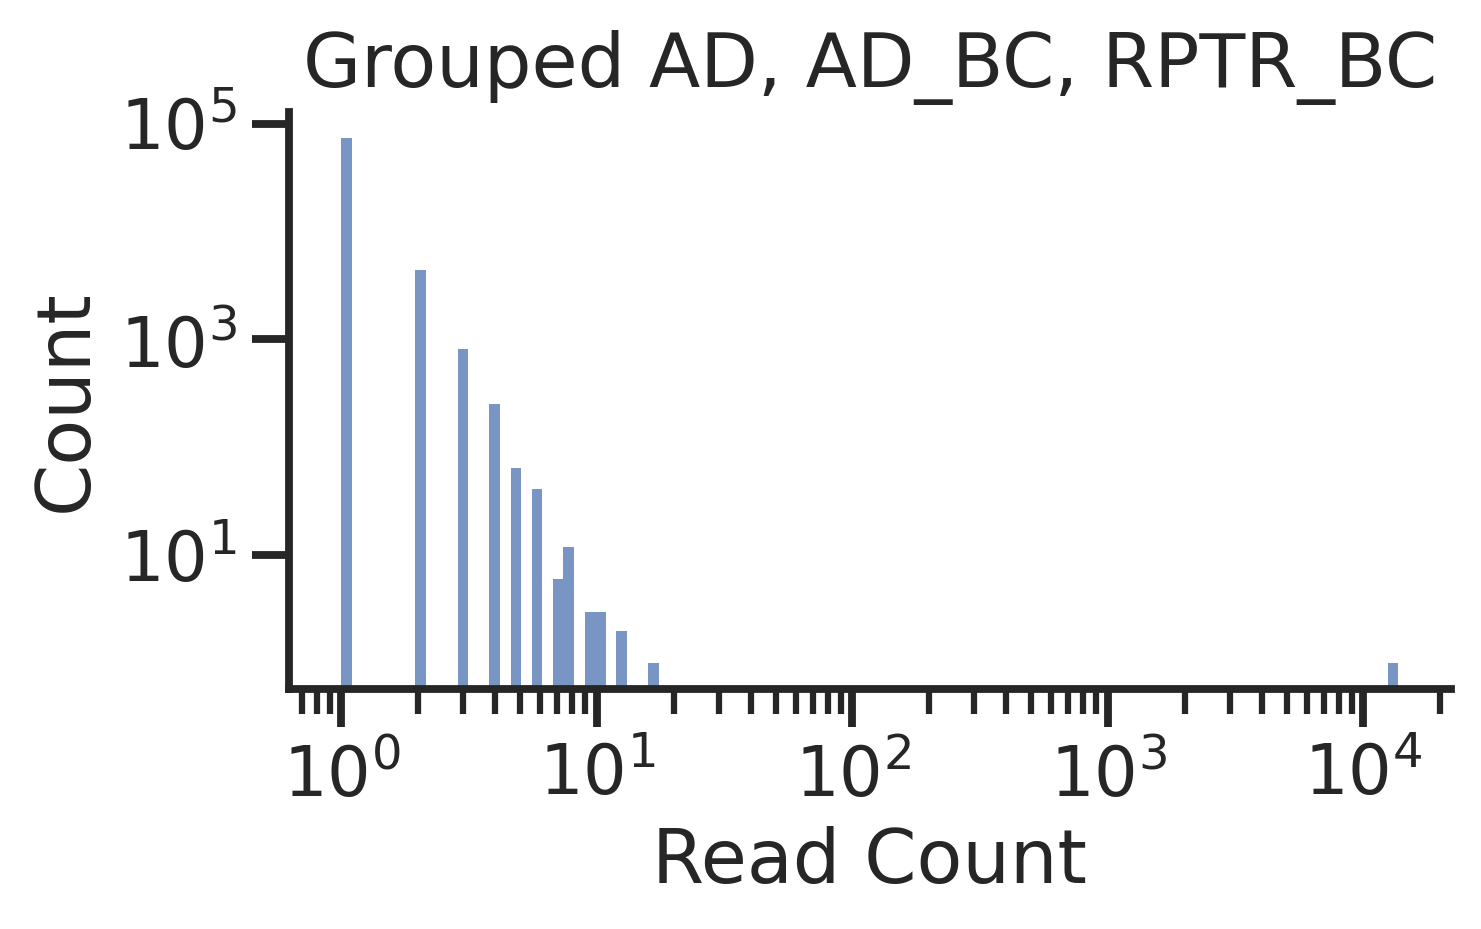

Done in 2.77 seconds.

Done.
Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_loss_summary'
Done in 0.14 seconds.



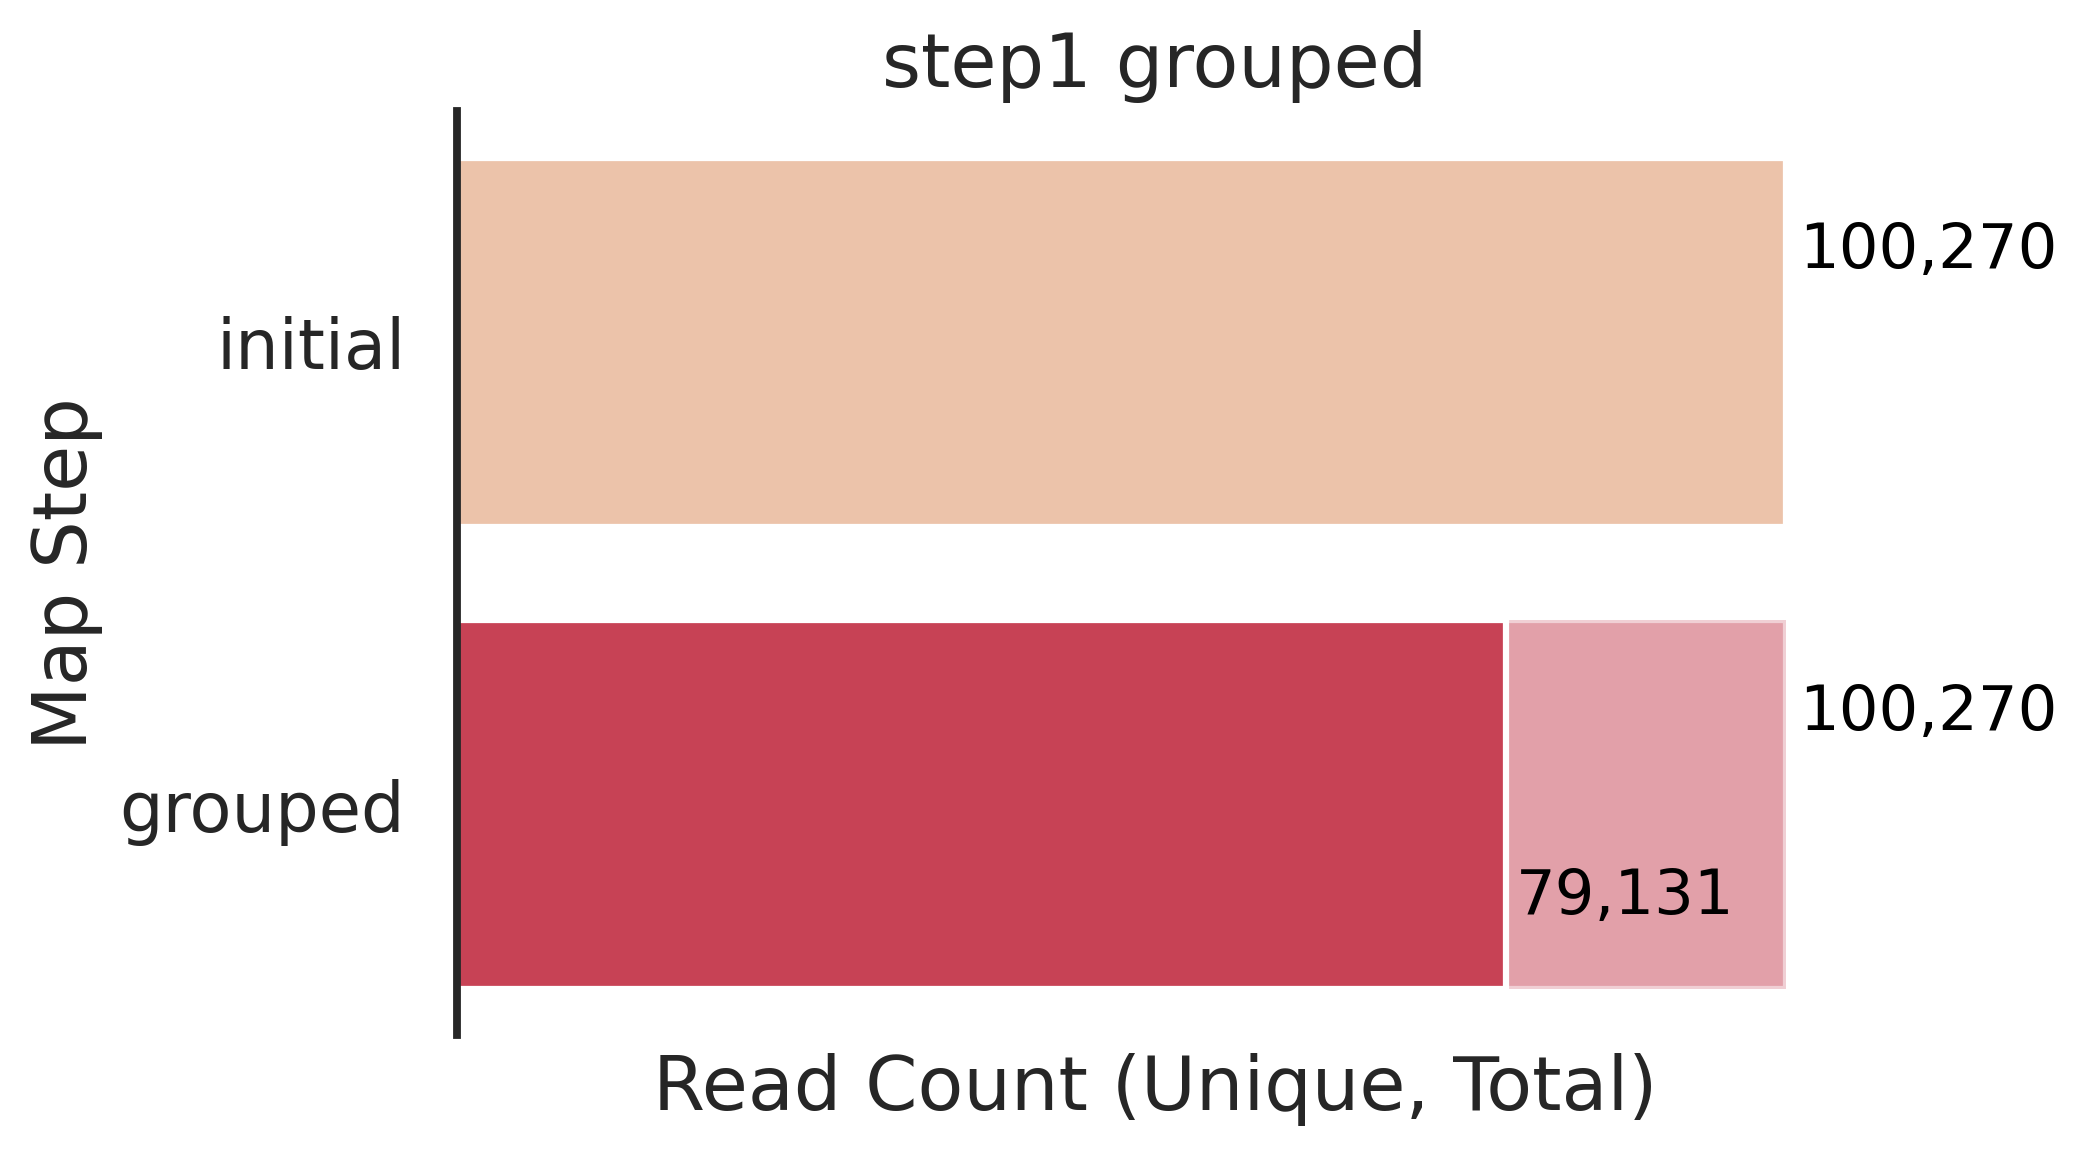

In [23]:
pipeline.step1_reads_distribution(seq_file = step1_seq_file,
                    bc_objects = [AD, AD_BC, RPTR_BC],
                    reverse_complement = True)

✓ Initial map already exists: step1_AD_AD_BC_RPTR_BC_initial — skipping test map
Base prefix (stable across descriptors): step1_AD_AD_BC_RPTR_BC_
Full prefix for this instance: step1_AD_AD_BC_RPTR_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. unique_target
6. quality
7. designed

Grouping step1_AD_AD_BC_RPTR_BC_initial...


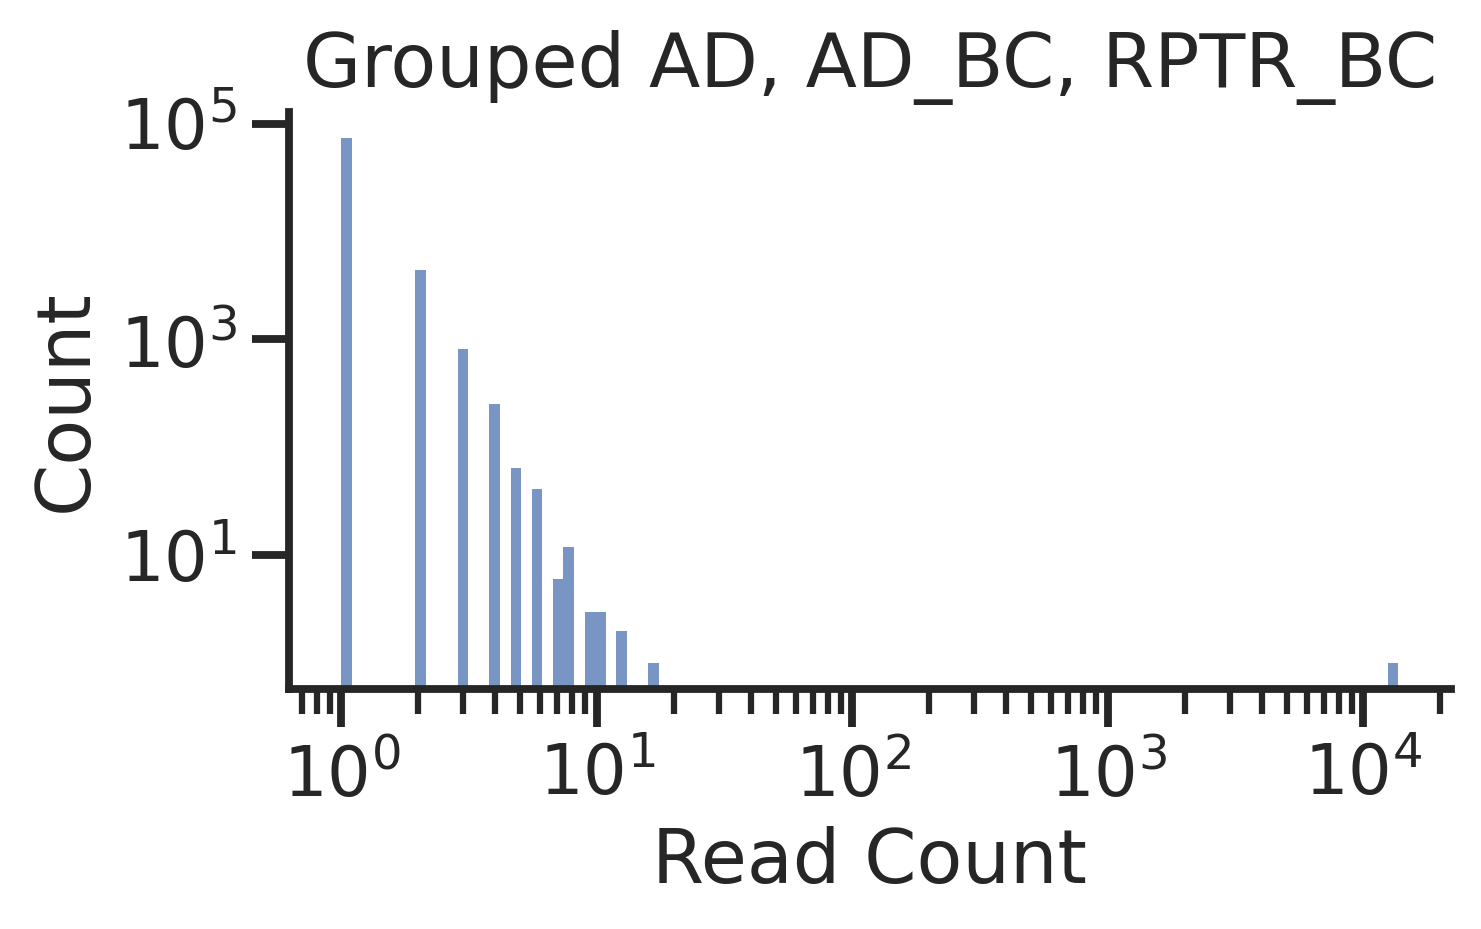

Done in 2.66 seconds.

Thresholding...
Using reads threshold of 1.


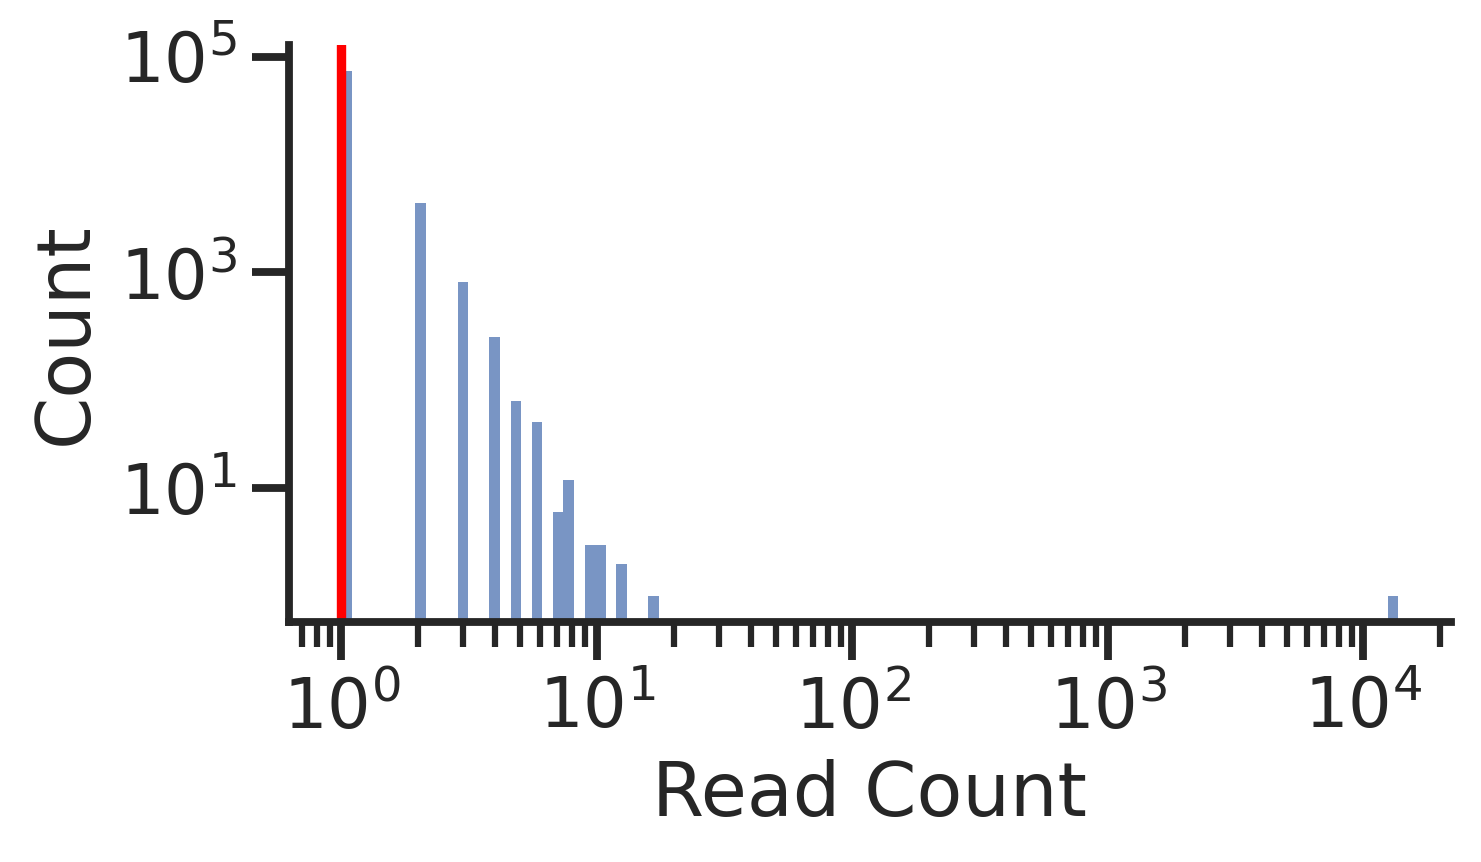

Done in 2.64 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.06 seconds.

Filtering so that at least 90% of reads come from the most abundant target...
	Processing mapping 1: RPTR_BC → AD
Created filtered table: step1_AD_AD_BC_RPTR_BC_unique_target
Done in 0.03 seconds.


Filtering to high-quality reads...
Created table: step1_AD_AD_BC_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.01 seconds.


Filtering to designed sequences...
Created table: step1_AD_AD_BC_RPTR_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_loss_summary'
Done in 0.15 seconds.



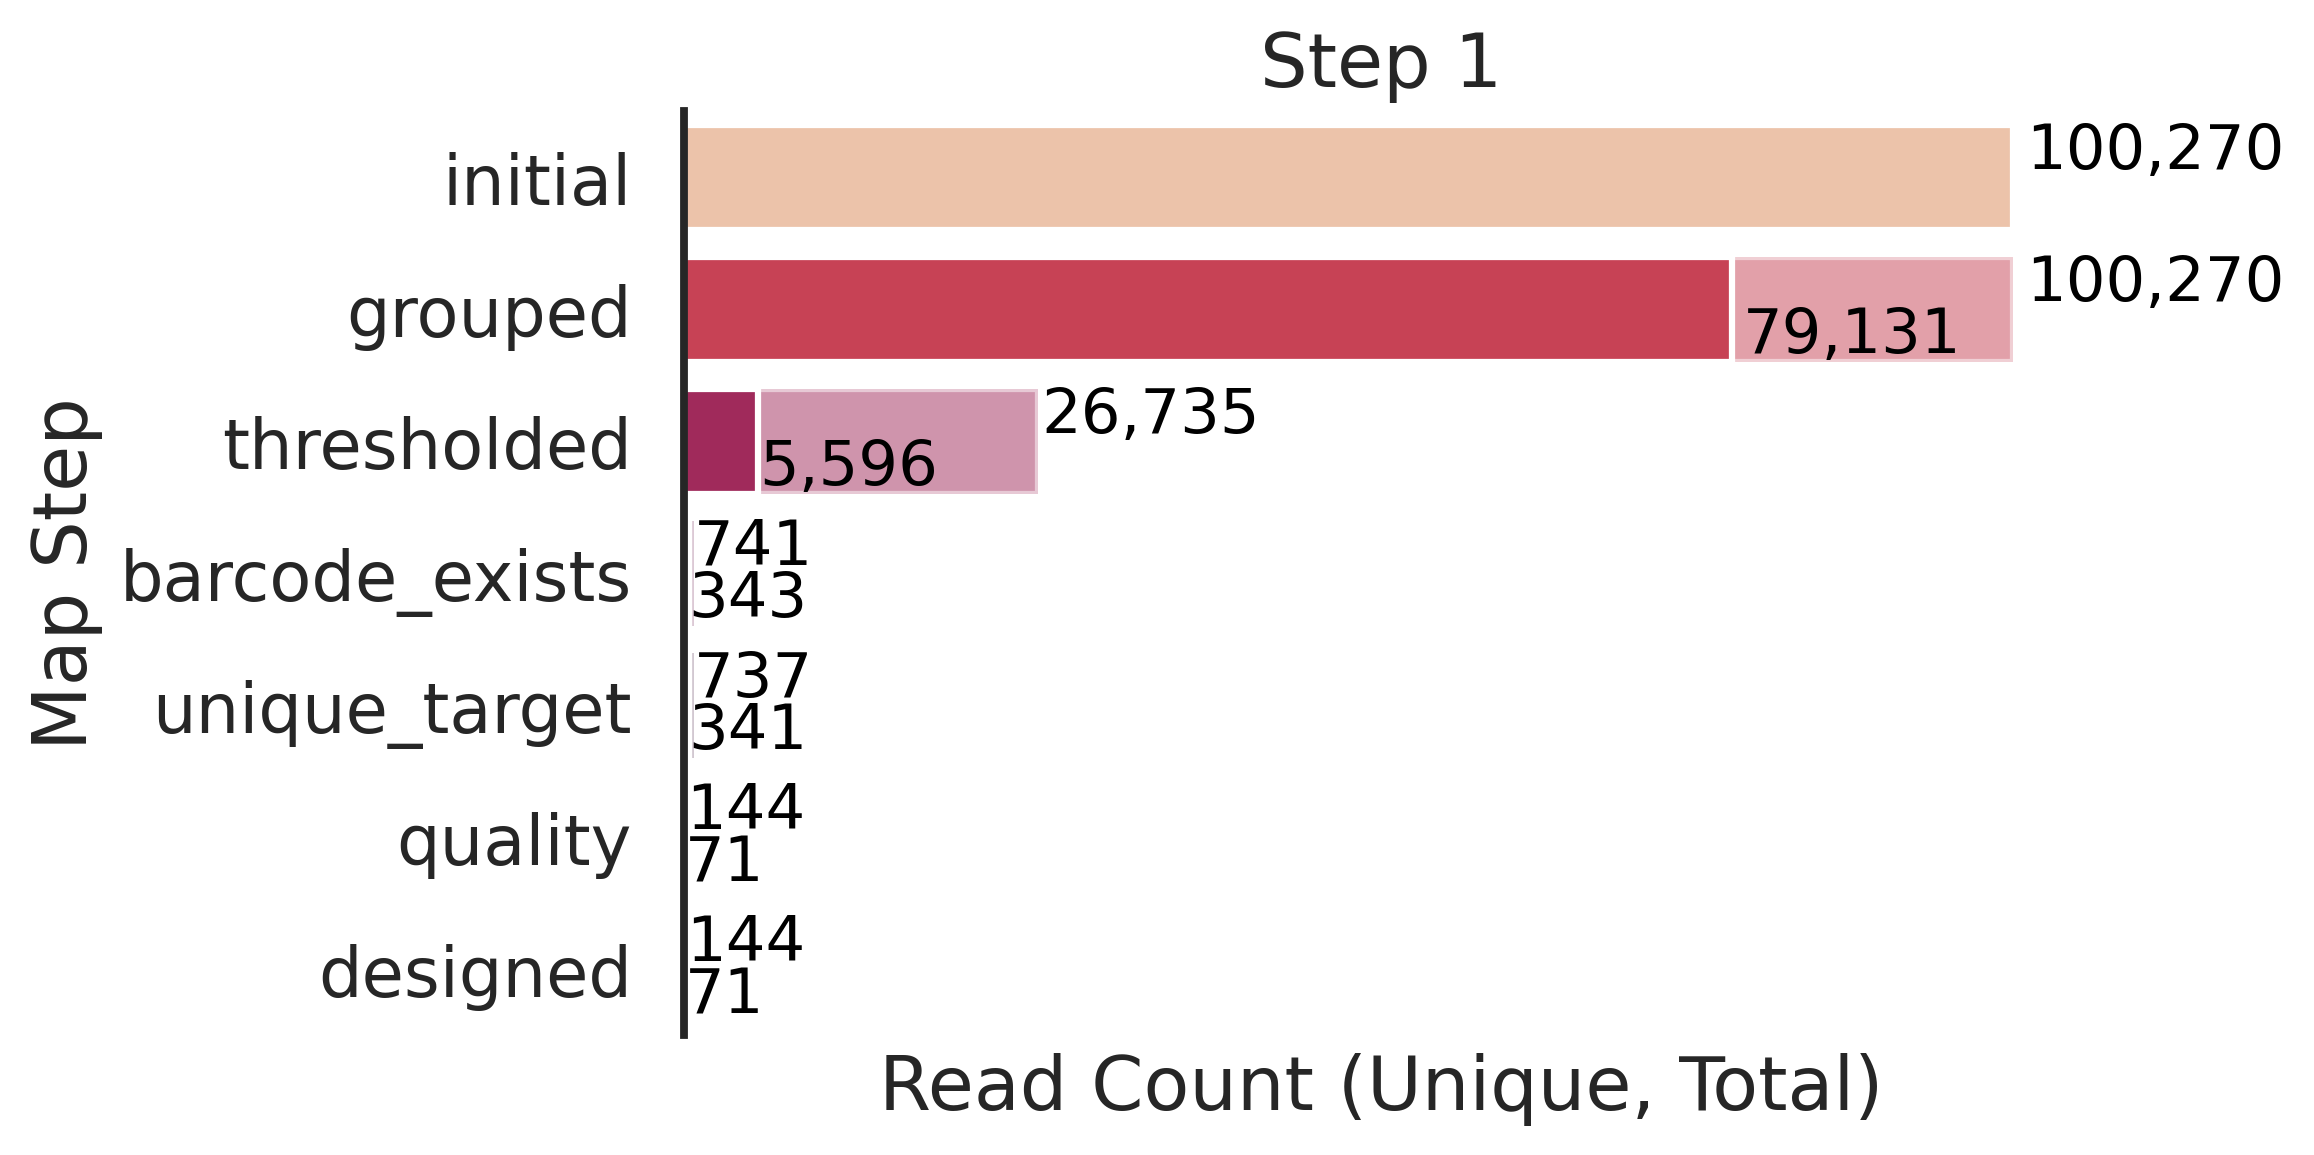

In [25]:
# Step 1
step1 = pipeline.run_step_1(seq_file = step1_seq_file,
                    bc_objects = [AD, AD_BC, RPTR_BC],
                    column_pairs = [("RPTR_BC", "AD")],
                    reads_threshold = 1, # CHANGE TO 10 for full data
                    reverse_complement = True)

In [26]:
step1

AD        AD_BC  \
0   ATTGTTTCTGATAGACAAAGAGATTTGTCTTTGGCTGTTCCAACTC...  GAGGCTGGTTT   
1   TTGAAGAGAAGATCTTCTAAAGATTCTGGTGTTGGTAATAATTCTT...  AGTCGTAGGCA   
2   AATTTGGAATATTATGATCAAGAAACTATTAAATTTATTGCTATTA...  TGTATATCACG   
3   GGTTTGAGACAAGGTCCATTGGCTGGTGGTGGTTCTAAAGAACAAA...  CCTCCCGCGTG   
4   GATGTTACTCCAGCTTCTCCAATGATTAGAACTACTTCTTCTAGAG...  CGGGGCGGACA   
..                                                ...          ...   
66  GATTCTCCAGGTCCAGGATTTACTCCACATGATTCTGCTCCATATG...  AAGAAGGAGAC   
67  CCAAAATCTAAGAGAGGTGATGCTTCTGCTAATAATGATGGTTCTT...  ATAGCCCCTGA   
68  GAATCTGAAGATTCTTCTGATGAAGATAATACTTCTGATGATAAAG...  ATACGAAGTCC   
69  CCACCAACTGATGTTTCTGCTGGTGATGAAGCTCATGCTGATGGTG...  GCGCCGCCAAC   
70  ACTTGTTTGTTCTGTAAGAGATCTCATGTTGTTTGTGATAAACAAA...  ATTGTACTGGC   

           RPTR_BC  count  AD_qual  AD_BC_qual  RPTR_BC_qual  Designed  
0   TGAAAGAGTCCGTA      3     True        True          True         1  
1   AGTGGTGACAGCGC      3     True        True          True         1  
2   CTGACCGGTGTAAA      2     True        True          True         1  
3   CCATCAGACTAACC      2     True        True          True         1  
4   TCAGCACGTGCAGT      2     True        True          True         1  
..             ...    ...      ...         ...           ...       ...  
66  TTCGAATTATGTTG      2     True        True          True         1  
67  CGTAAGCTGCGAGC      2     True        True          True         1  
68  GACTGACGTGGCAA      2     True        True          True         1  
69  CAGCCGGTACAACC      2     True        True          True         1  
70  CACTATGTGTTACT      2     True        True          True         1  

[71 rows x 8 columns]

## Step 2 New

✓ Initial map already exists: step2_new_AD_AD_BC_initial — skipping test map
Base prefix (stable across descriptors): step2_new_AD_AD_BC_
Full prefix for this instance: step2_new_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping step2_new_AD_AD_BC_initial...


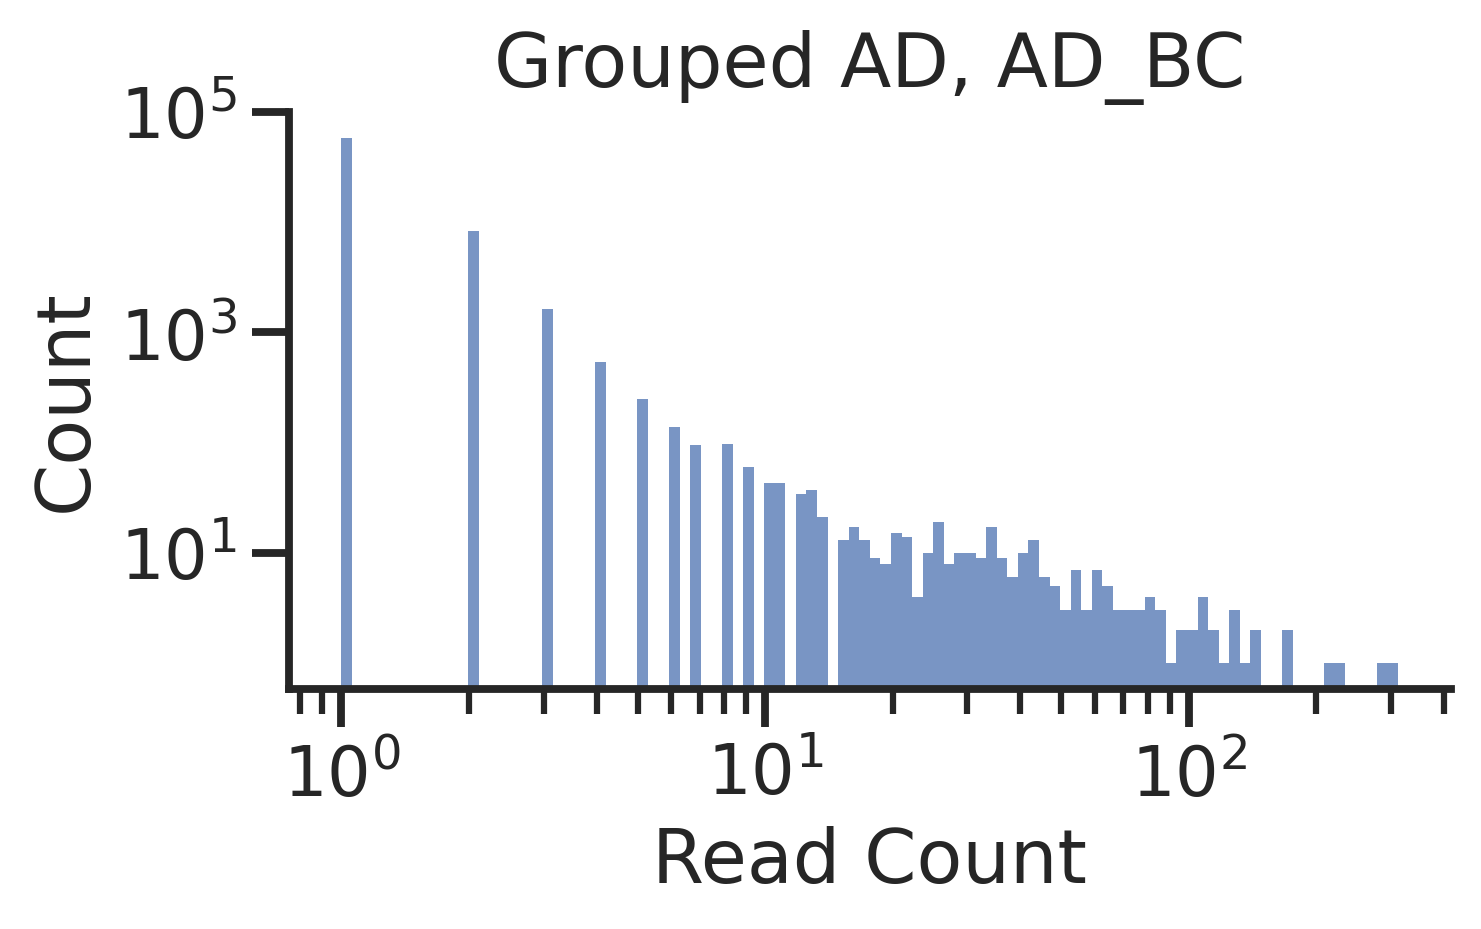

Done in 2.67 seconds.

Done.
Saved loss summary table as 'step2_new_AD_AD_BC_loss_summary'
Done in 1.23 seconds.

✓ Initial map already exists: step2_new_RPTR_BC_initial — skipping test map
Base prefix (stable across descriptors): step2_new_RPTR_BC_
Full prefix for this instance: step2_new_RPTR_BC_

Using the following step order:
1. initial
2. grouped

Grouping step2_new_RPTR_BC_initial...


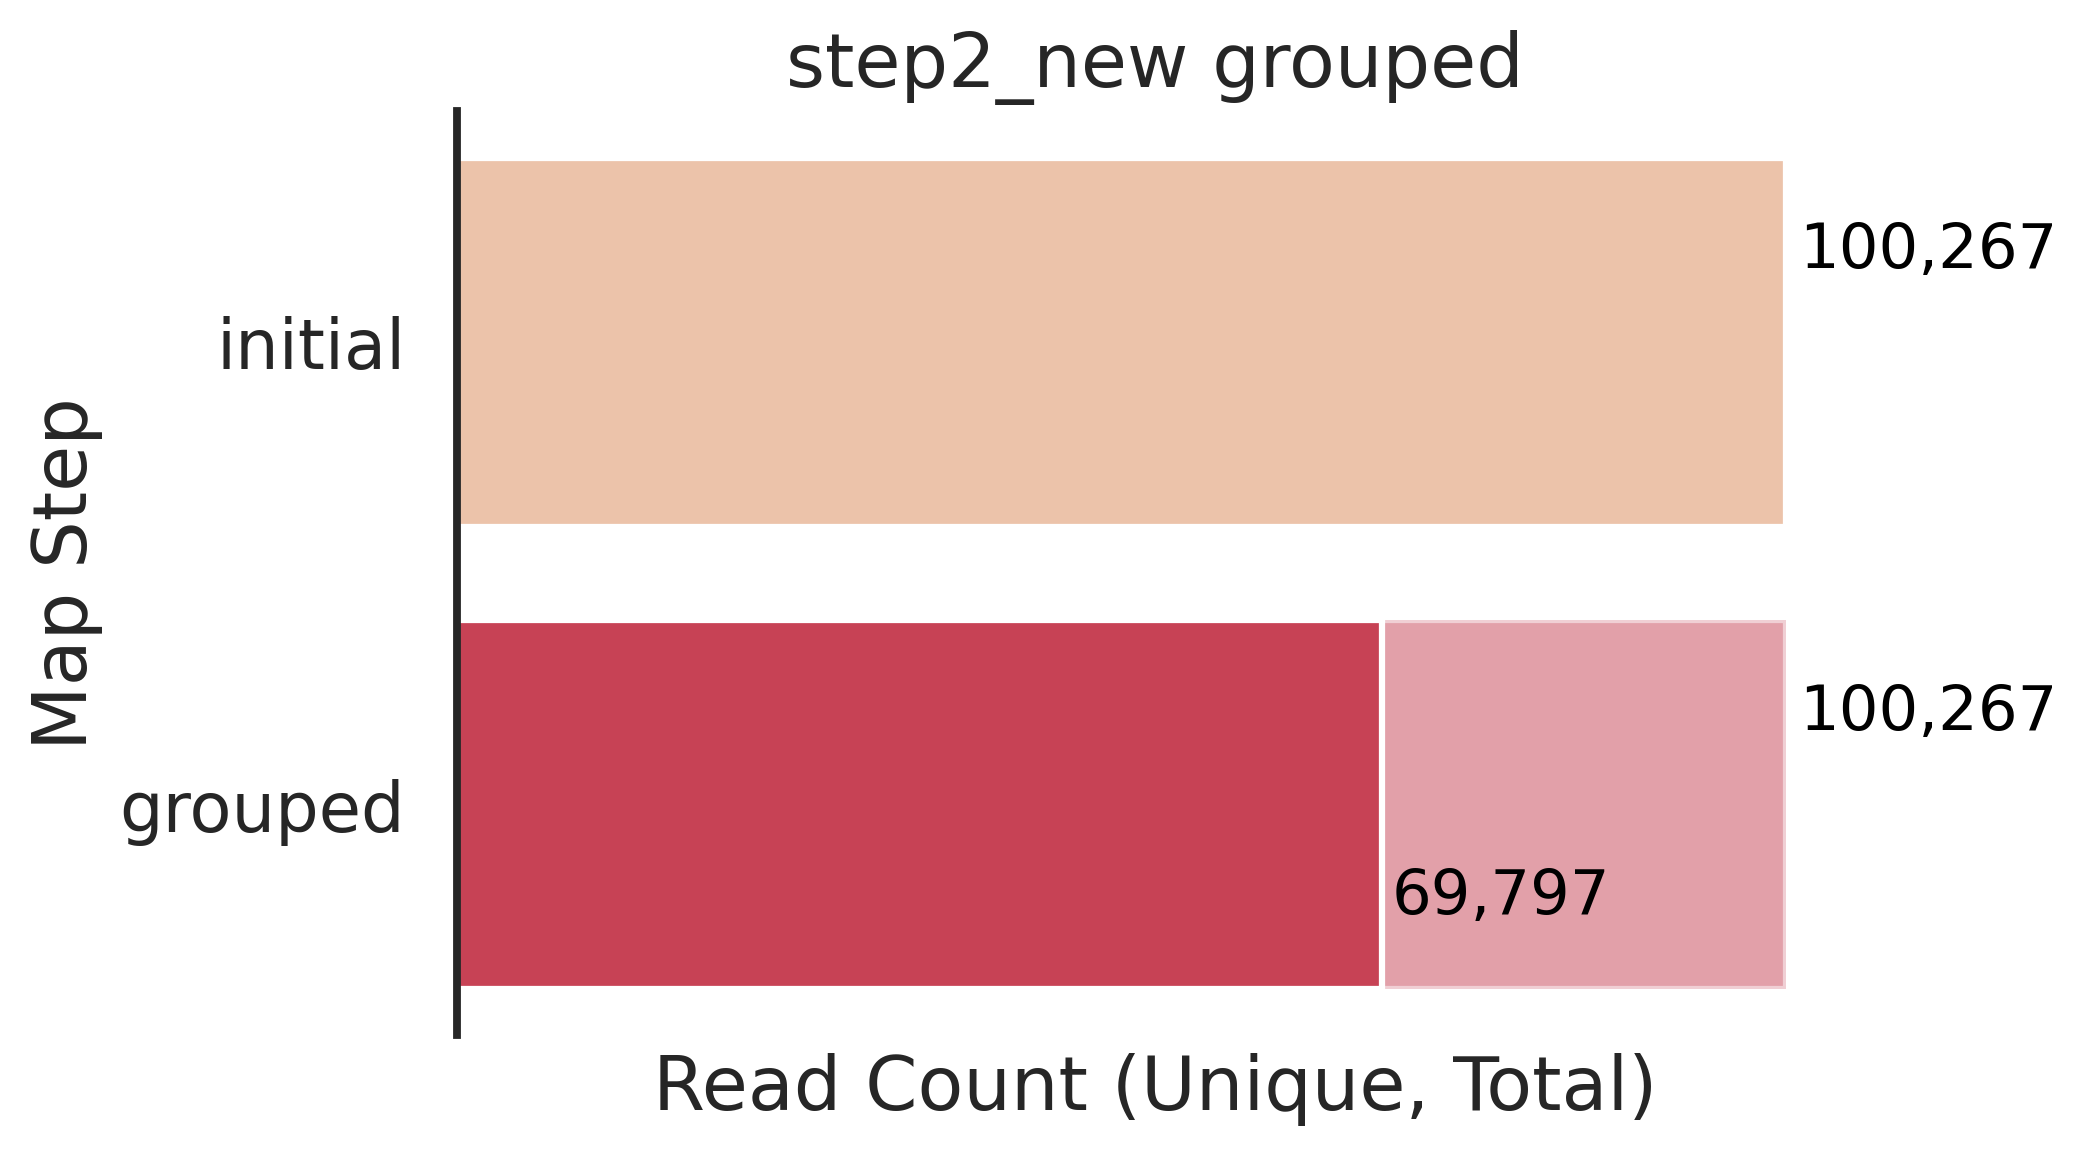

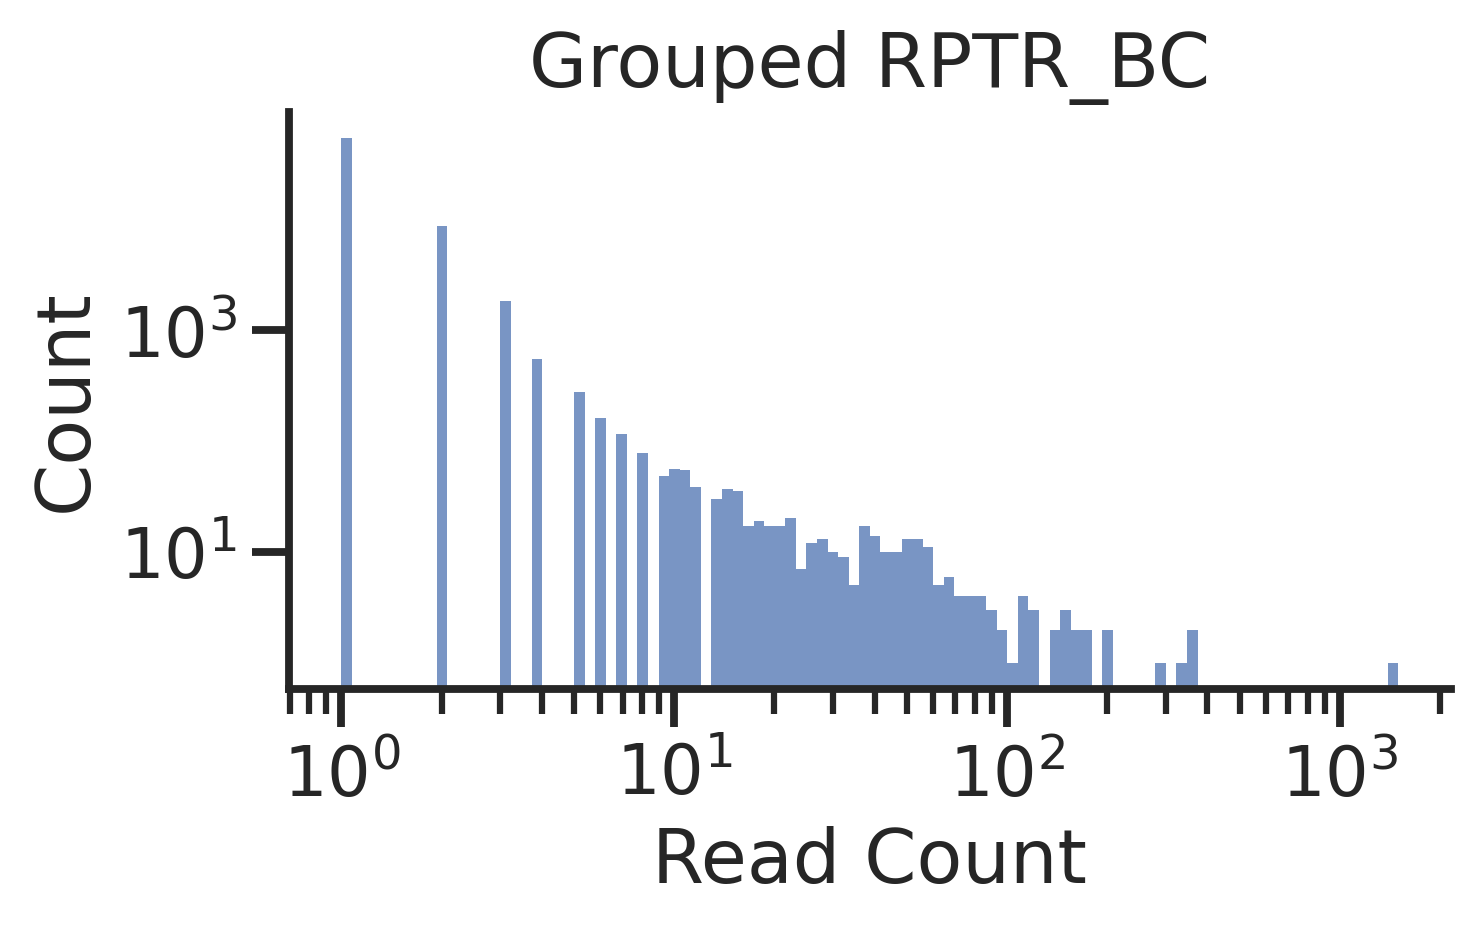

Done in 2.54 seconds.

Done.
Saved loss summary table as 'step2_new_RPTR_BC_loss_summary'
Done in 0.03 seconds.



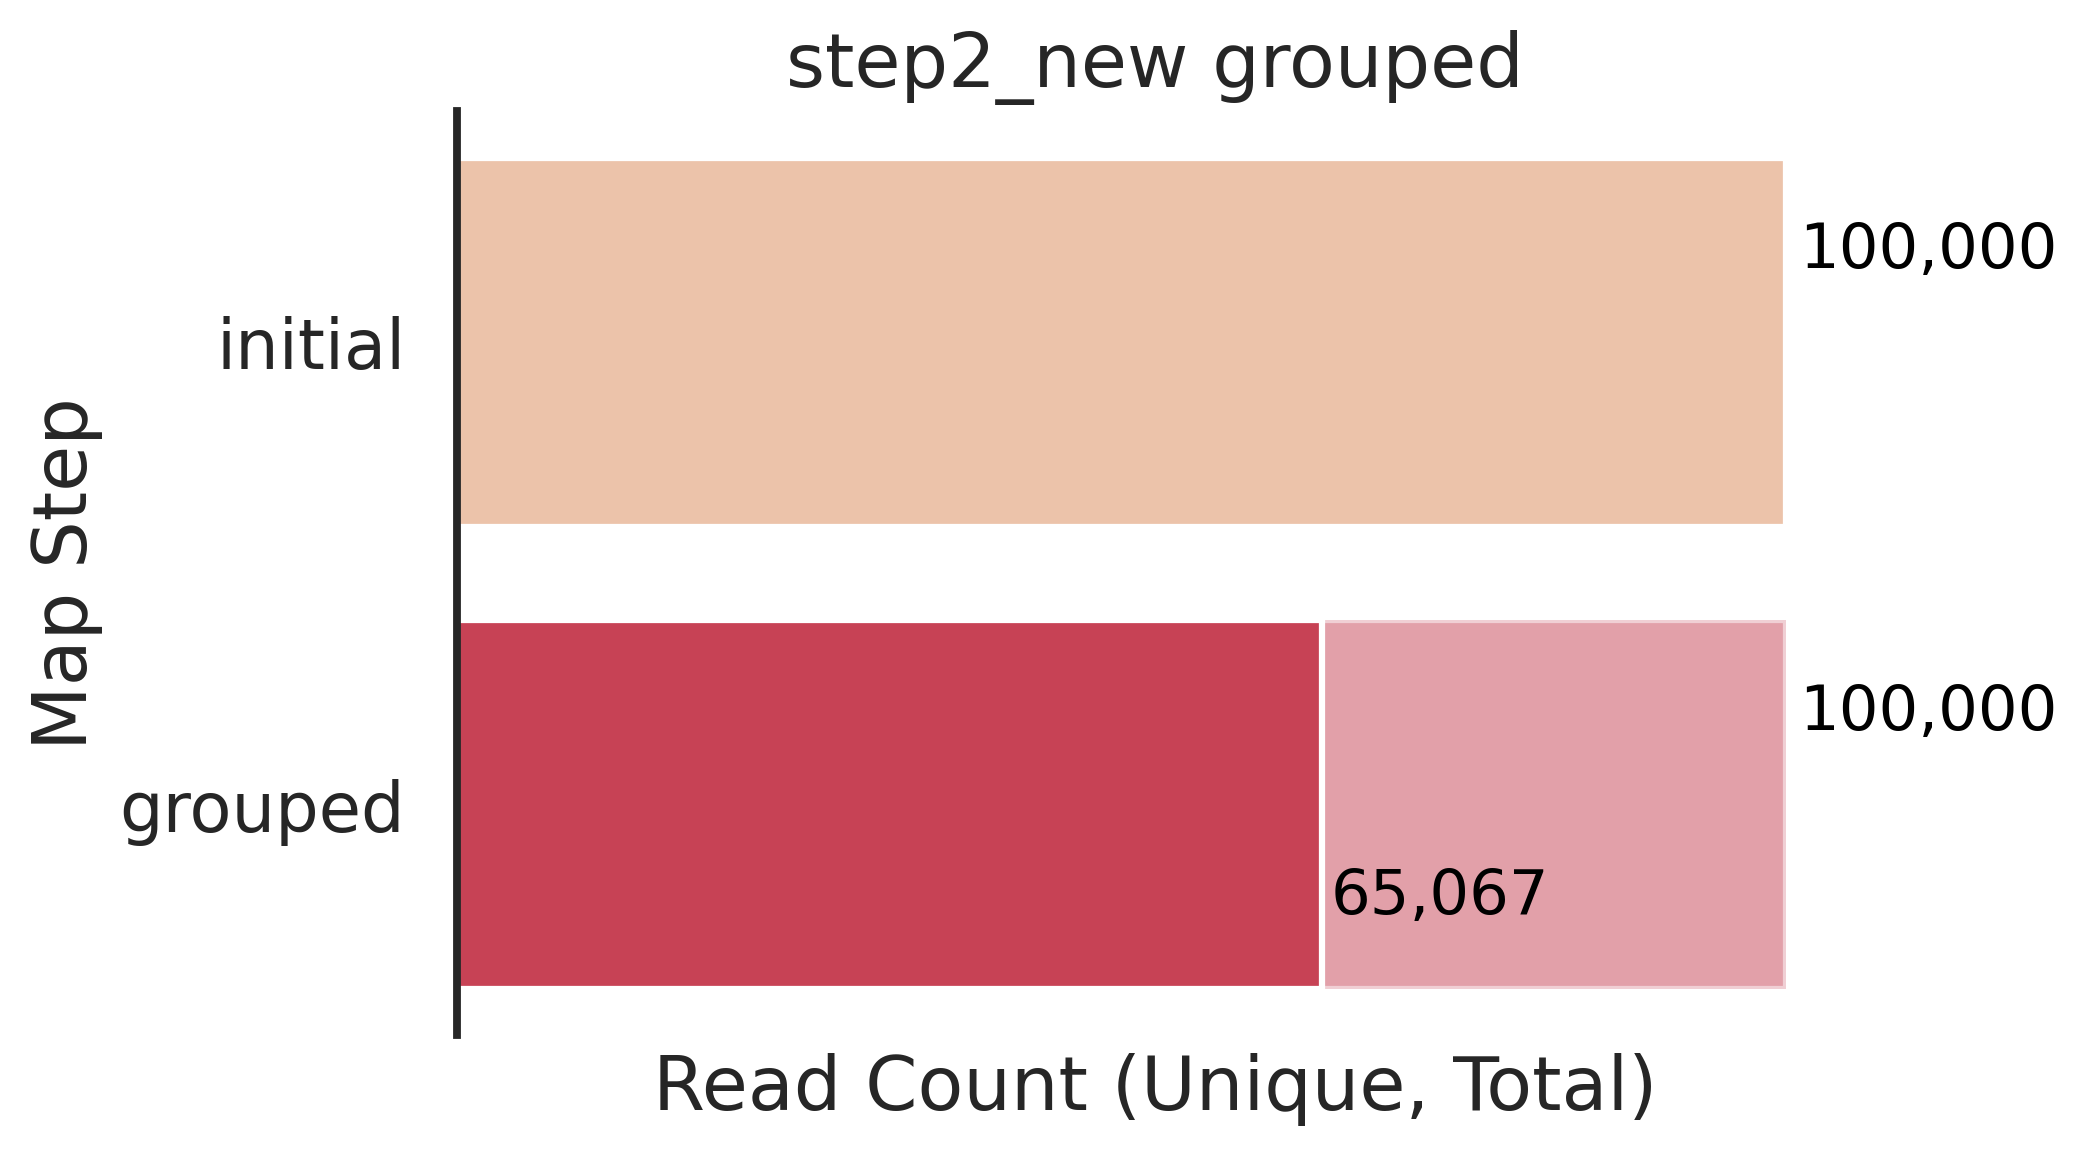

In [10]:
pipeline.step2_reads_distribution(AD_seq_file = step2_new_AD_seq_file,
                                  AD_bc_objects = [AD, AD_BC],
                                  RT_seq_file = step2_new_RT_seq_file,
                                  RT_bc_objects = [RPTR_BC],
                                  reverse_complement = True,
                                  step_suffix= "_new")

✓ Initial map already exists: step2_AD_AD_BC_initial — skipping test map
✓ Initial map already exists: step2_RPTR_BC_initial — skipping test map
Base prefix (stable across descriptors): step2_AD_AD_BC_
Full prefix for this instance: step2_AD_AD_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. quality
6. designed

Base prefix (stable across descriptors): step2_RPTR_BC_
Full prefix for this instance: step2_RPTR_BC_

Using the following step order:
1. initial
2. grouped
3. thresholded
4. barcode_exists
5. quality
6. designed

Grouping step2_AD_AD_BC_initial...


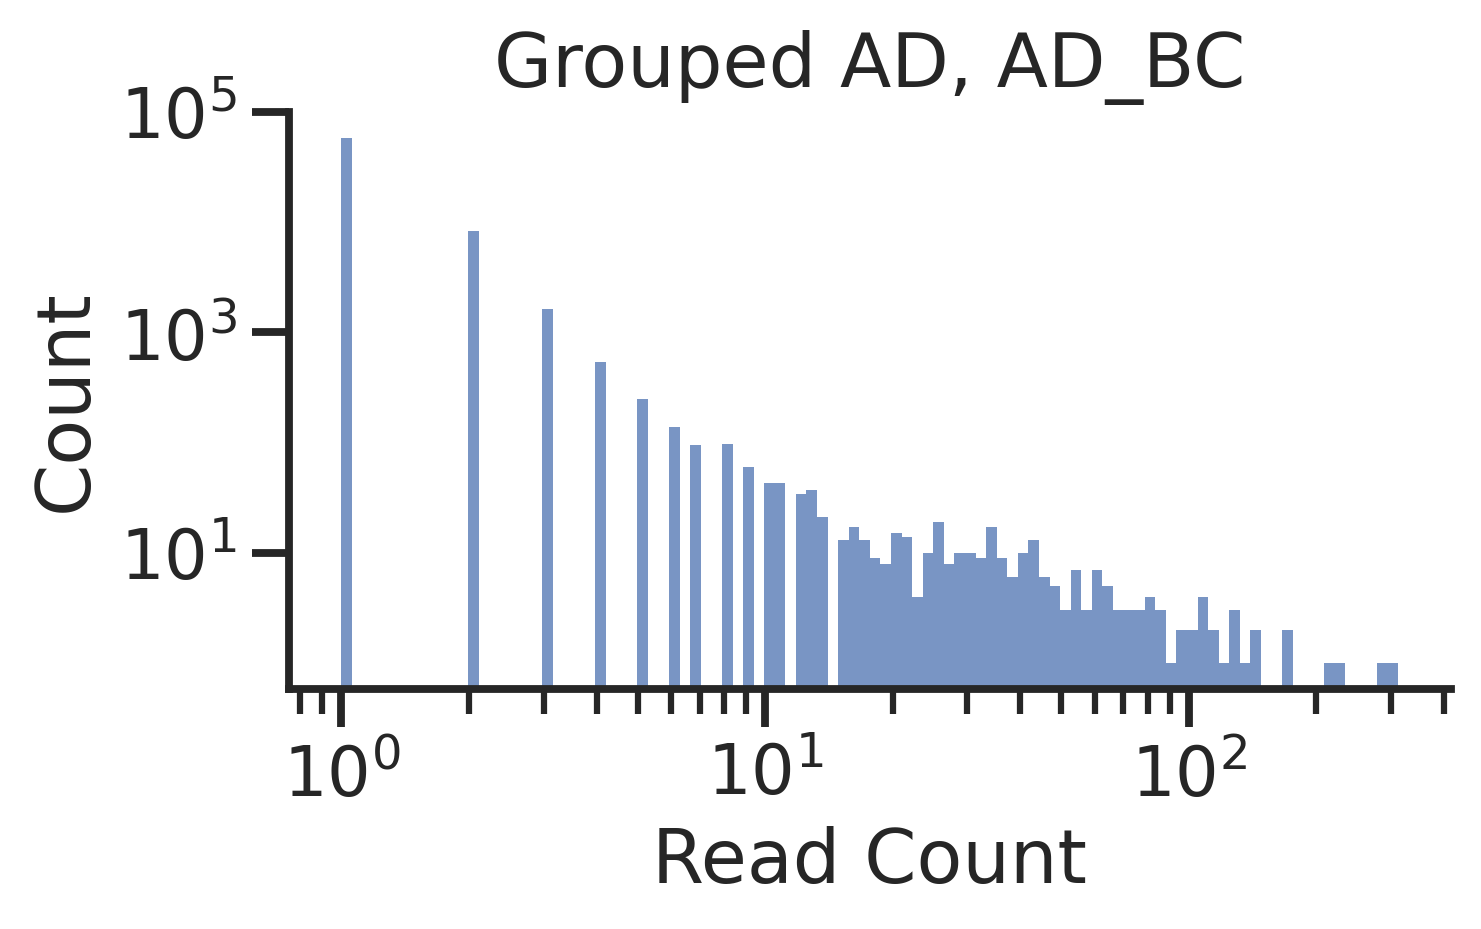

Done in 2.63 seconds.

Thresholding...
Using reads threshold of 10.


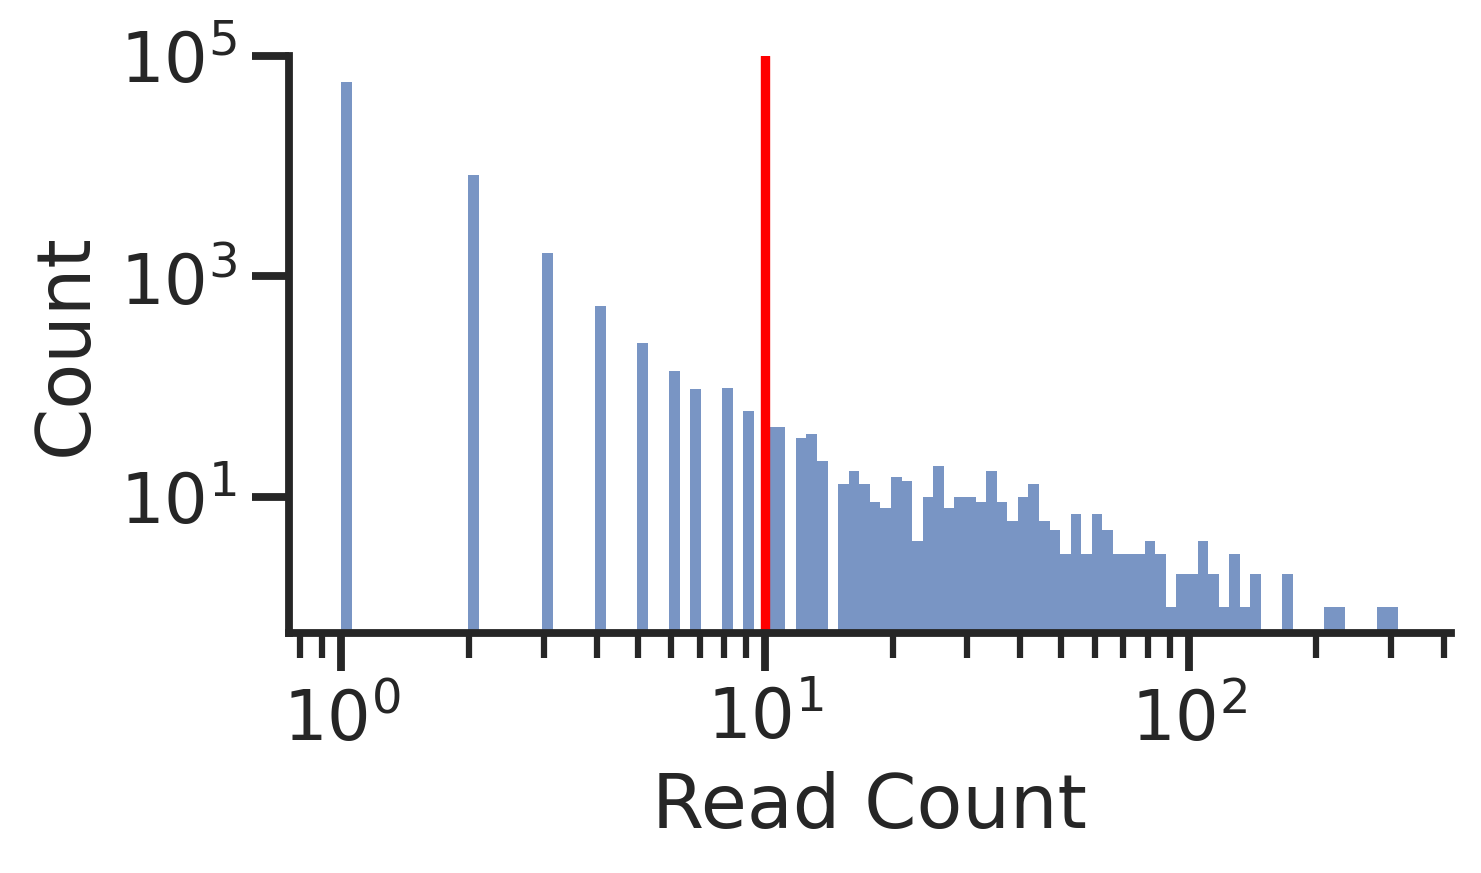

Done in 1.89 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.01 seconds.


Filtering to high-quality reads...
Created table: step2_AD_AD_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.01 seconds.


Filtering to designed sequences...
Created table: step2_AD_AD_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'step2_AD_AD_BC_loss_summary'
Done in 0.14 seconds.

Grouping step2_RPTR_BC_initial...


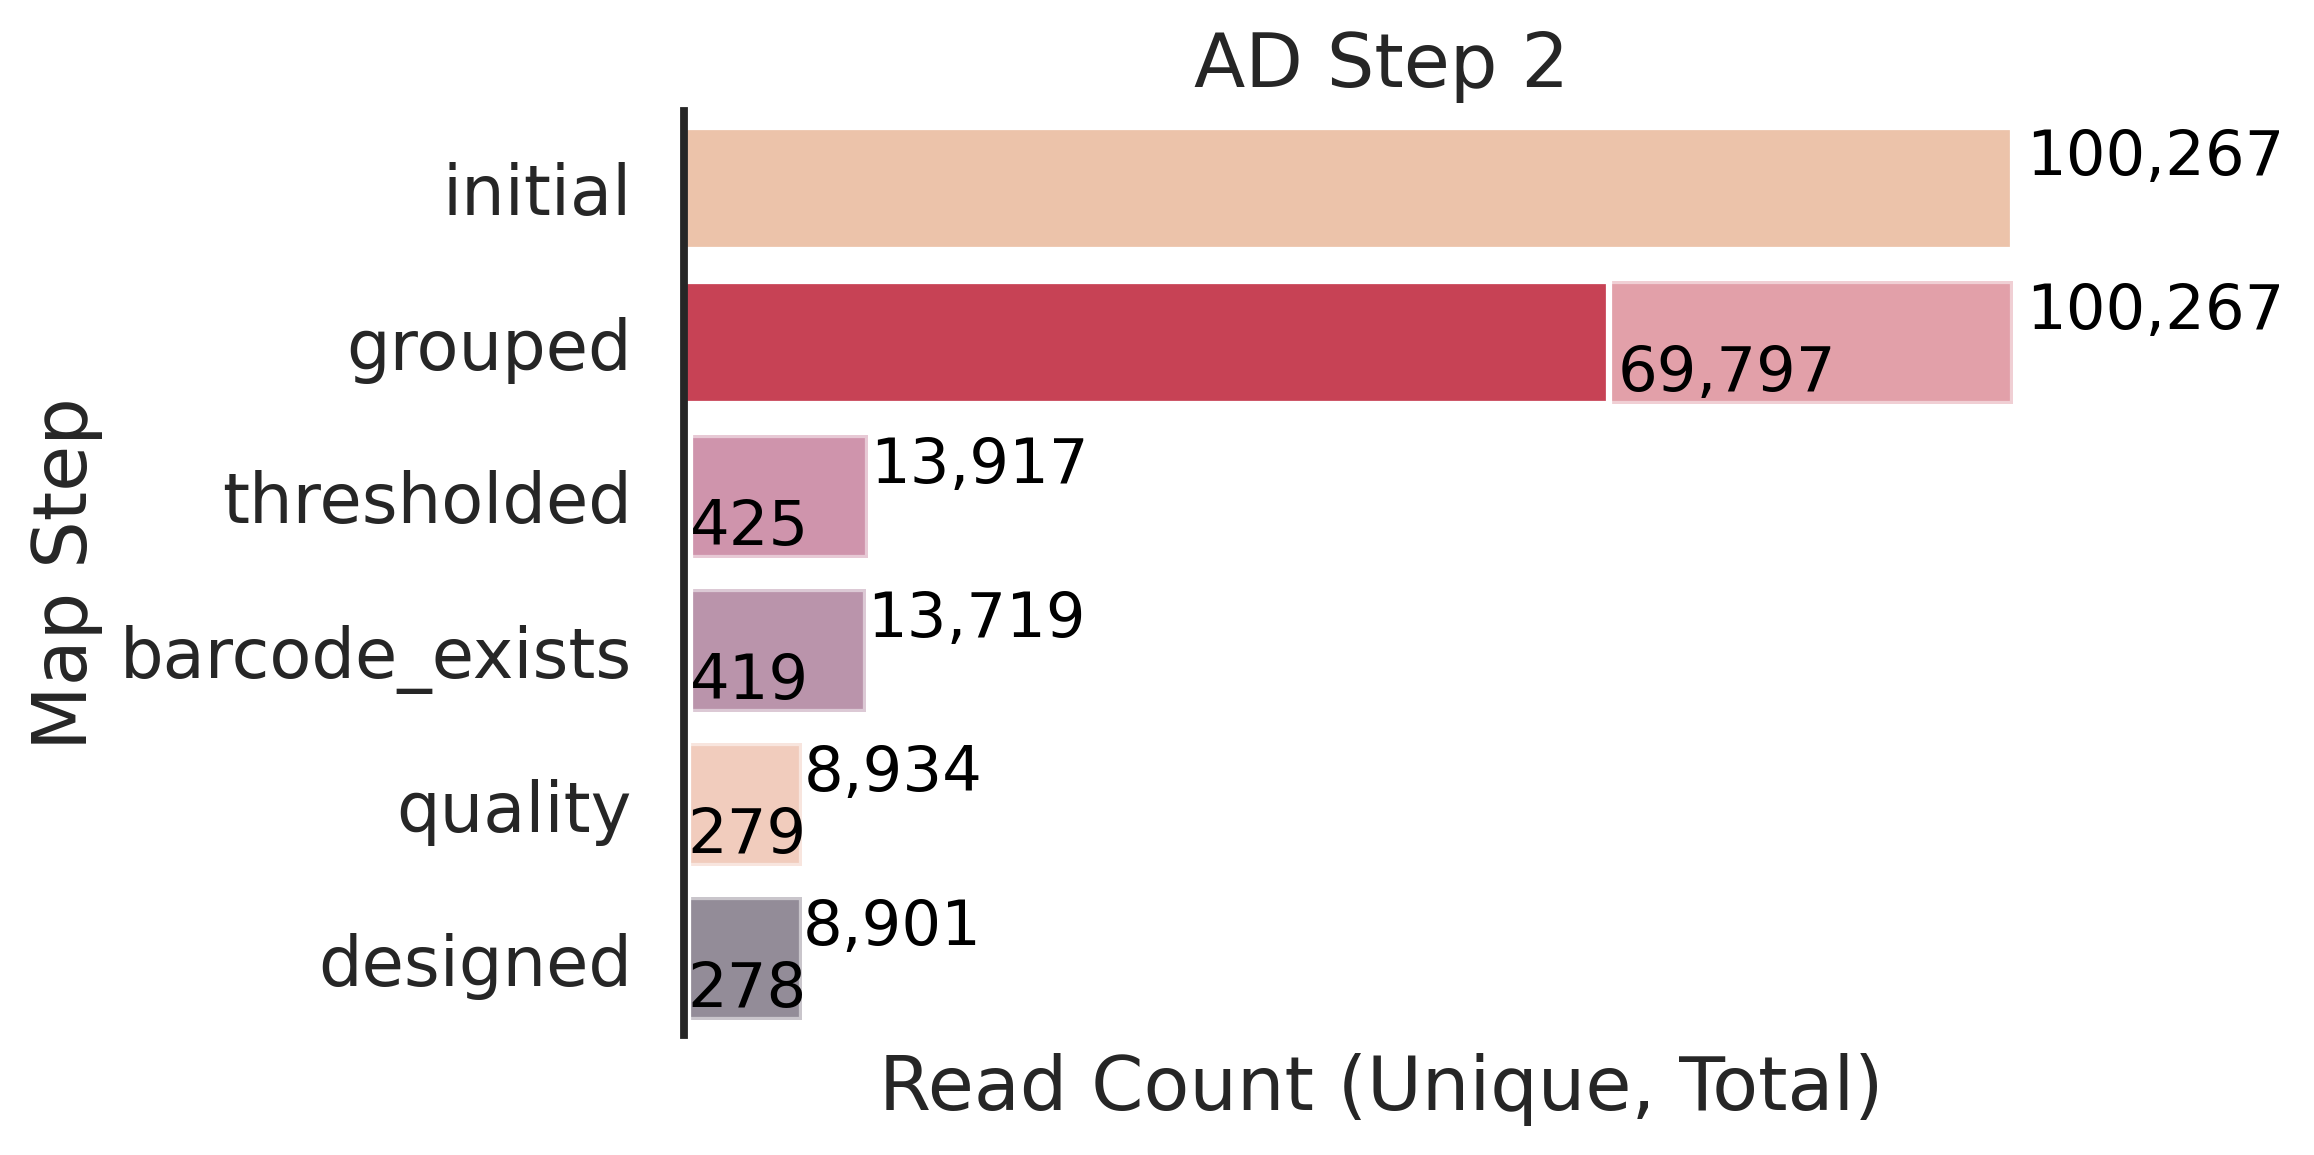

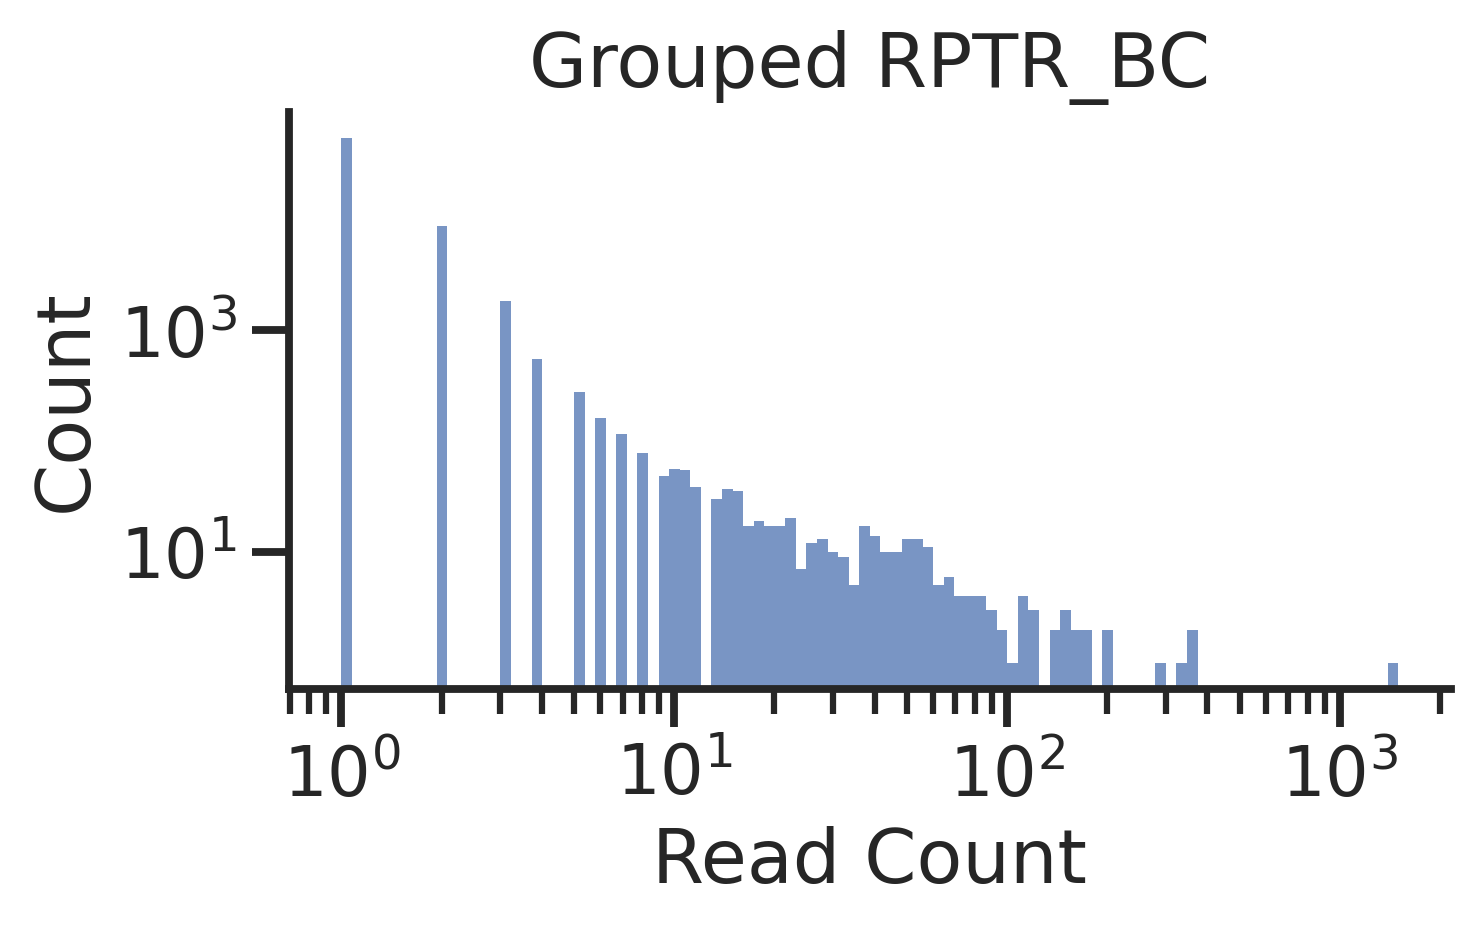

Done in 3.10 seconds.

Thresholding...
Using reads threshold of 10.


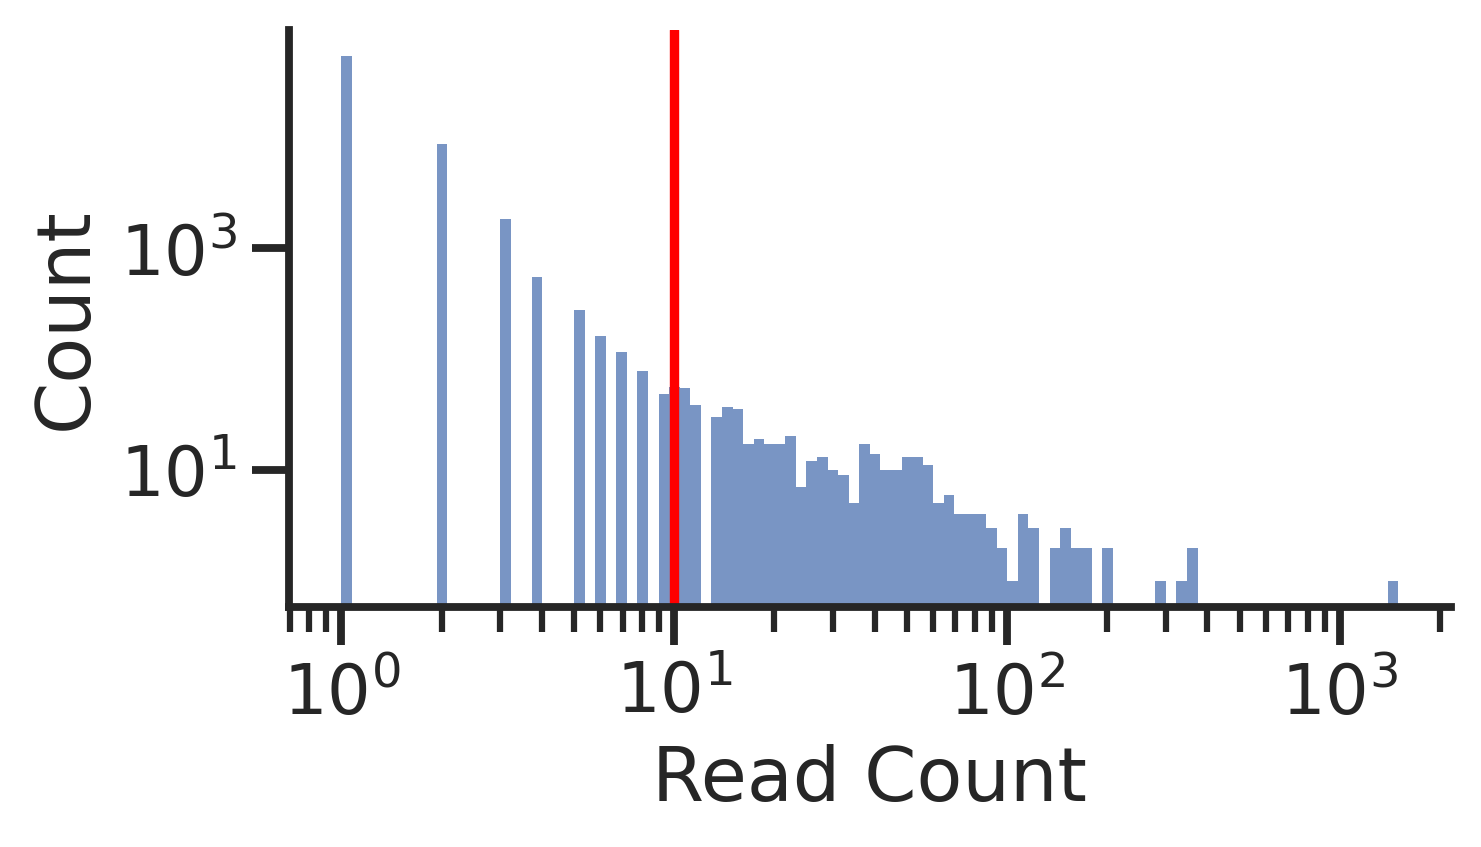

Done in 1.88 seconds.

Removing rows with null or empty barcodes (excluding AD)...
Done in 0.01 seconds.


Filtering to high-quality reads...
Created table: step2_RPTR_BC_quality — filtered for TRUE in all *_qual columns.
Done in 0.00 seconds.


Filtering to designed sequences...
Created table: step2_RPTR_BC_designed — kept only Designed == 1.
Done in 0.00 seconds.

Done.
Saved loss summary table as 'step2_RPTR_BC_loss_summary'
Done in 0.04 seconds.



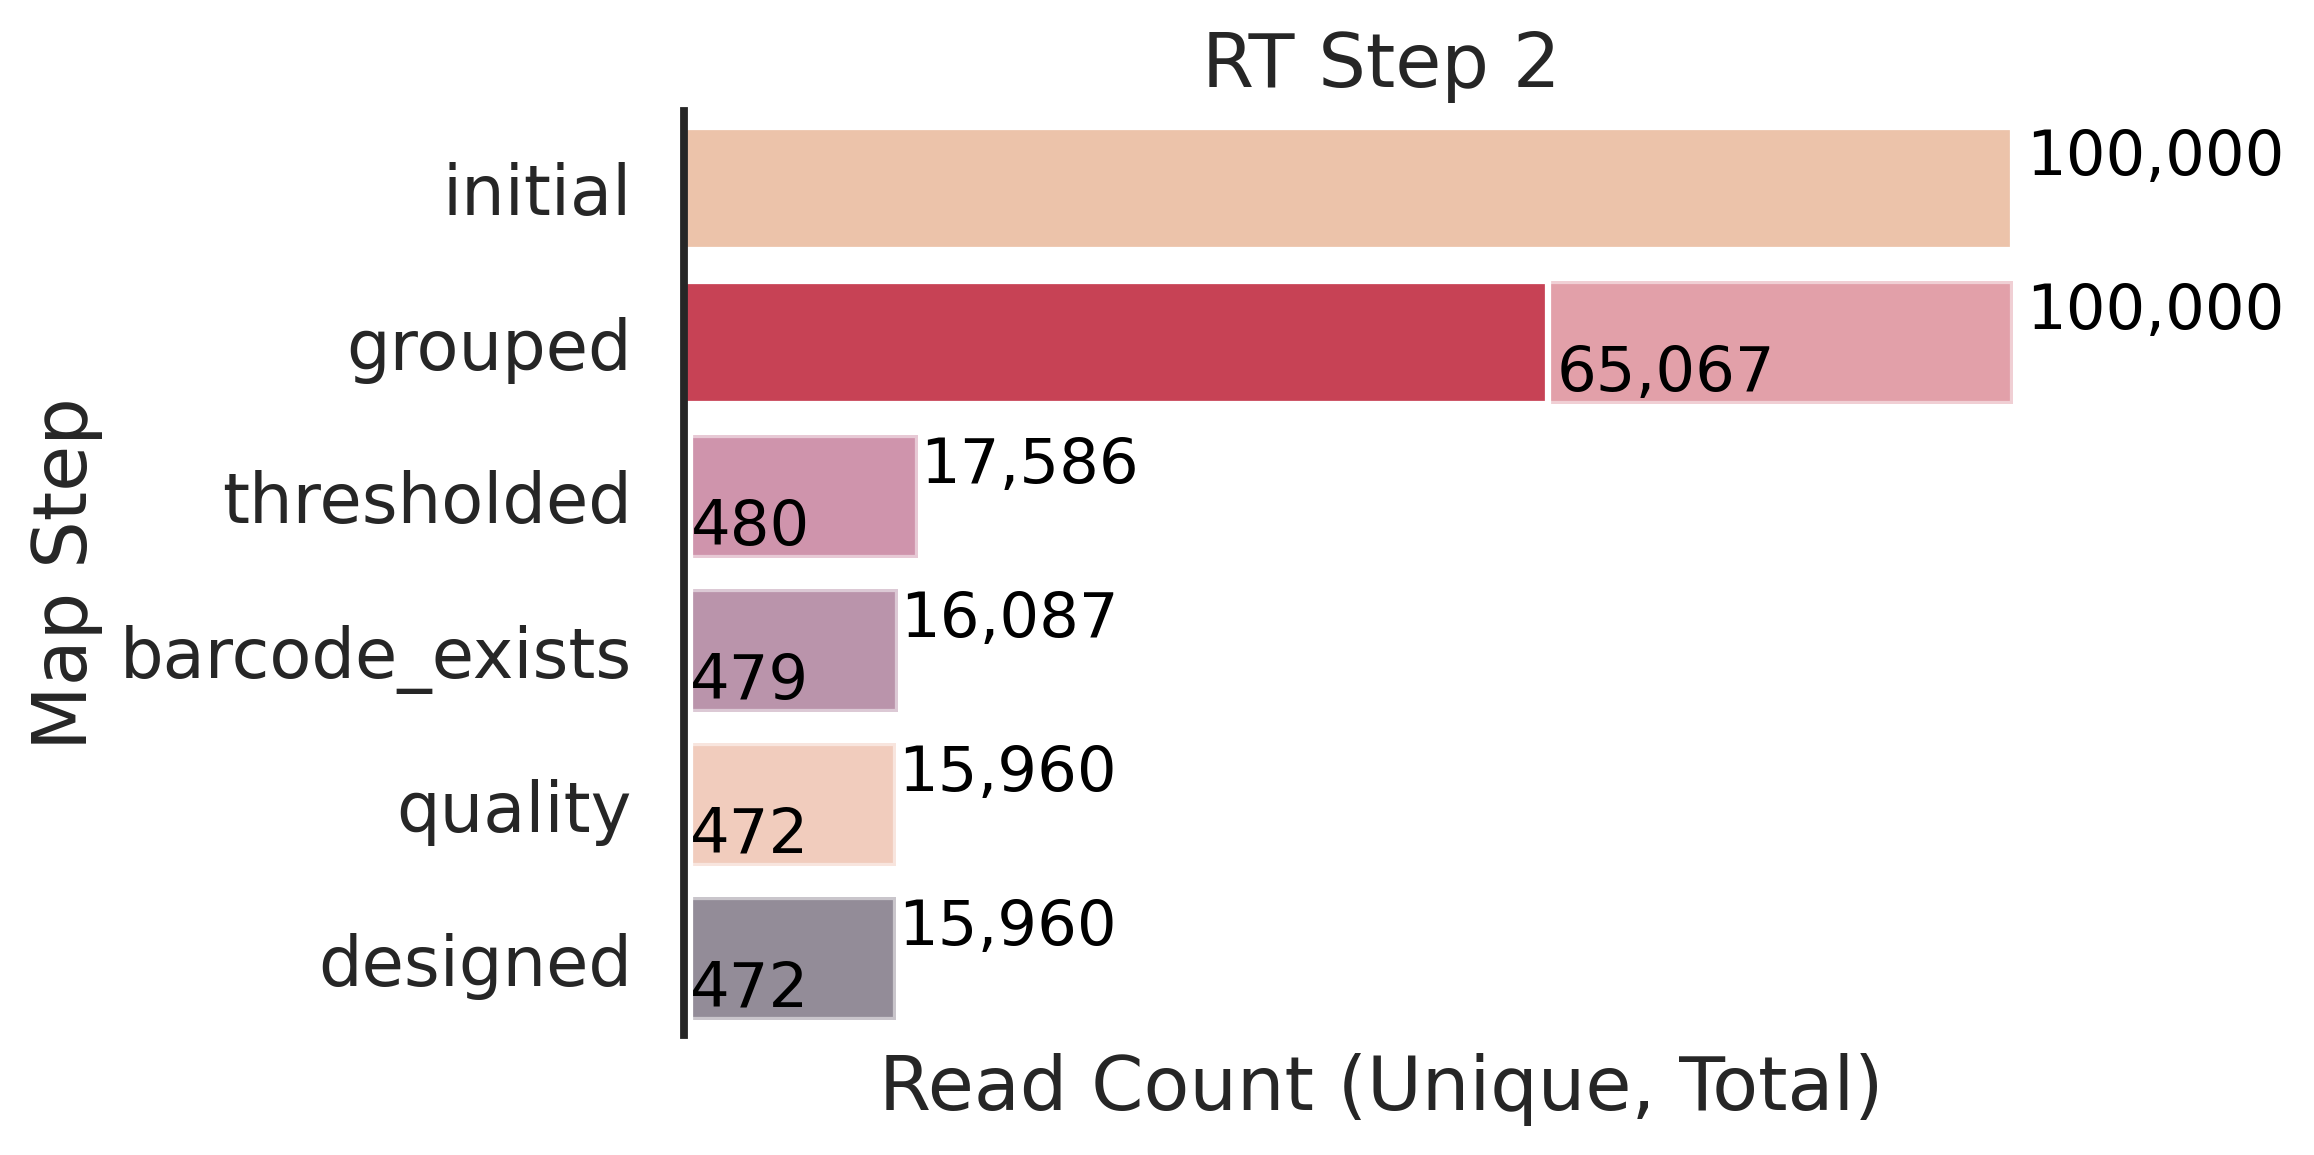

In [13]:
step2_new = pipeline.run_step_2(AD_seq_file=step2_new_AD_seq_file,
                            AD_bc_objects=[AD, AD_BC],
                            RT_seq_file=step2_new_RT_seq_file,
                            RT_bc_objects=[RPTR_BC],
                            reverse_complement=True,
                           reads_threshold_AD = 10,
                           reads_threshold_RT = 10,
                               step1_map_name="step1_AD_AD_BC_RPTR_BC_designed")

AD_step2_new = step2_new["AD_step2"]
RT_step2_new = step2_new["RT_step2"]
step1_step2_new_overlap = step2_new["step1_overlap"]

In [16]:
AD_step2_new

AD        AD_BC  count  \
0    TATACTCCAGAAAGAGGTTCTGCTAATAGAGCTAGATCTCCATTGC...  CAGTTTAGCTA    287   
1    GGTTCTGCTAATAGAGCTAGATCTCCATTGCATTCTAATTCTAATA...  ACGGTCGTGAA    211   
2    AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...  TGTCCTTGTCG    171   
3    GGTTCTGCTAATAGAGCTAGATCTCCATTGCATTCTAATTCTAATA...  TTGAACACAGA    167   
4    GCTAGATCTCCATTGCATTCTAATTCTAATAATACTAATAATAATG...  TTTGTGTACAT    141   
..                                                 ...          ...    ...   
273  ATCTTTGATTCTAAACCATATGATGAAACTATTACTAAAGTTATTA...  AGGTACCGGGC     11   
274  AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...  CCCGCCCCCCT     11   
275  CCAGCTAATAATCCAACTGTTCAAGAAGGTCCATCTGCTATGGGTT...  ATTTACGTAAC     11   
276  TTCTCATTTGCTCAAAGAGCTAAGATTGAAATTATTAGAATCTTGT...  AGGCCAGTTAC     11   
277  TTTGGTAGATTGGGATTTGATATGTCTGCTAATCATTATGTTGTTA...  TATATTATGTA     11   

     AD_qual  AD_BC_qual  Designed  
0       True        True         1  
1       True        True         1  
2       True        True         1  
3       True        True         1  
4       True        True         1  
..       ...         ...       ...  
273     True        True         1  
274     True        True         1  
275     True        True         1  
276     True        True         1  
277     True        True         1  

[278 rows x 6 columns]

In [17]:
RT_step2_new

RPTR_BC  count  RPTR_BC_qual  Designed
0    TGGTAAGGAGTCTA    361          True         1
1    TGCTCATTGGGAAT    350          True         1
2    TCCGAGTACAAAAC    342          True         1
3    TTAAATGTTATGCT    283          True         1
4    TCCGATGAAAACTC    207          True         1
..              ...    ...           ...       ...
467  TGCCGTCGCTATCC     11          True         1
468  ACTGCAGCCCATTT     11          True         1
469  GAGGGCTTTGCTAT     11          True         1
470  TACGTTGTTCCACC     11          True         1
471  GAGAAACGTCGCCA     11          True         1

[472 rows x 4 columns]

In [18]:
step1_step2_new_overlap

BC_type  map_unique  step2  seen_in_both  percent_of_map_seen
0  AD,AD_BC          71    278             0                0.000
1   RPTR_BC          71    472             1                1.408

# TREBL Experiment

✓ Initial map already exists: trebl_experiment_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_initial — skipping test map
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_initial...


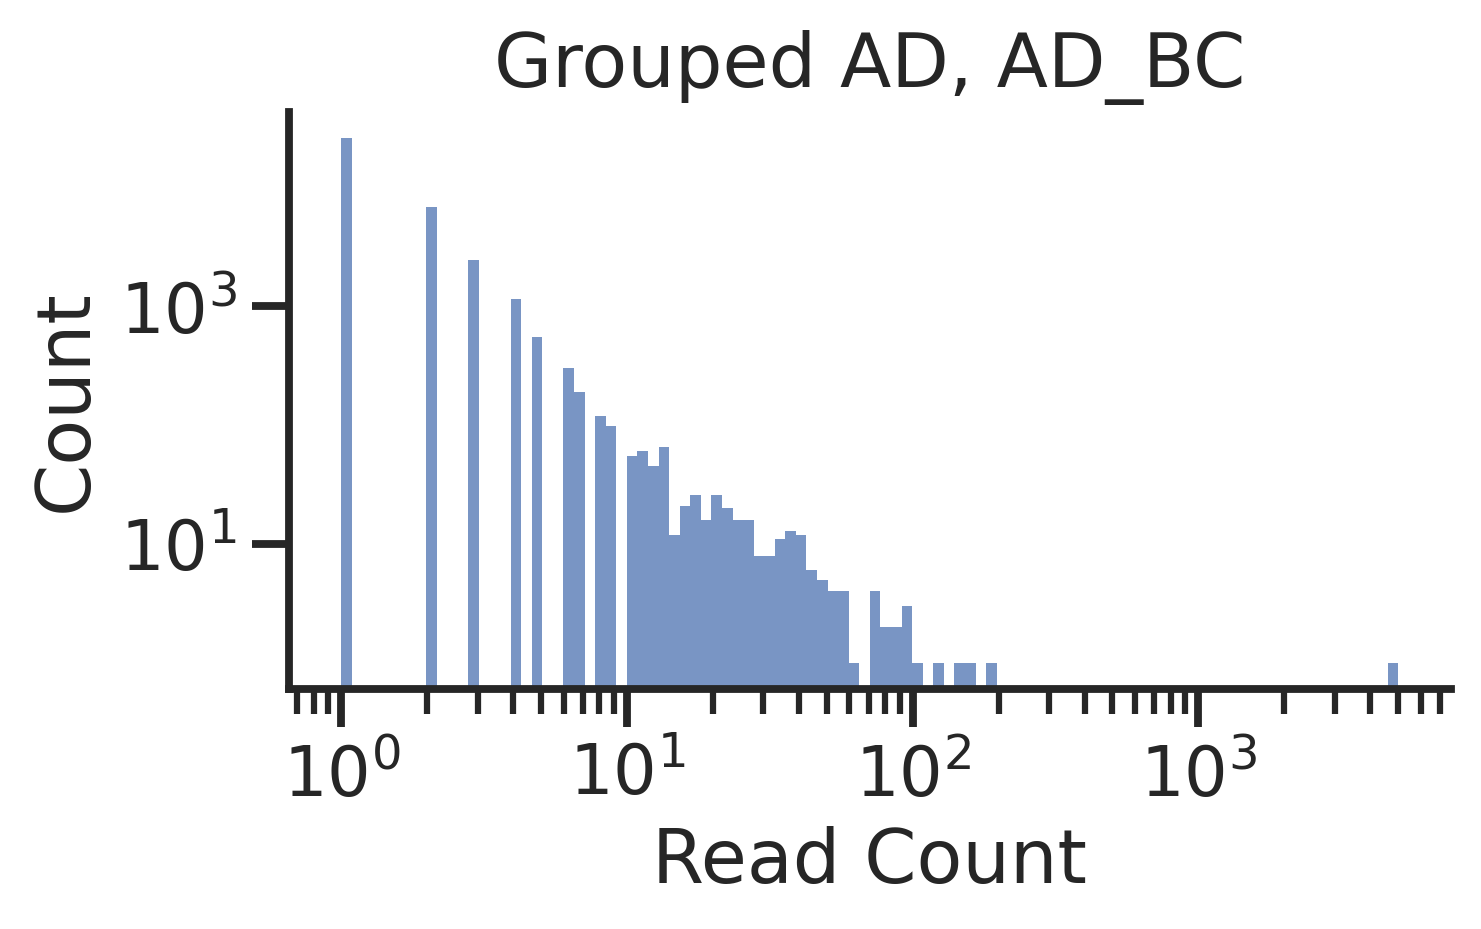

Done in 2.34 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_15_MVS_0005_GCCATTCATA_CAGTACACTA_S13_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.32 seconds.

Reverse complement of sequences...
Done in 1.73 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 1.01 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.31 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGATTGA_S18_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGATTGA_S18_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGATTGA_S18_AD_AD_BC_initial...


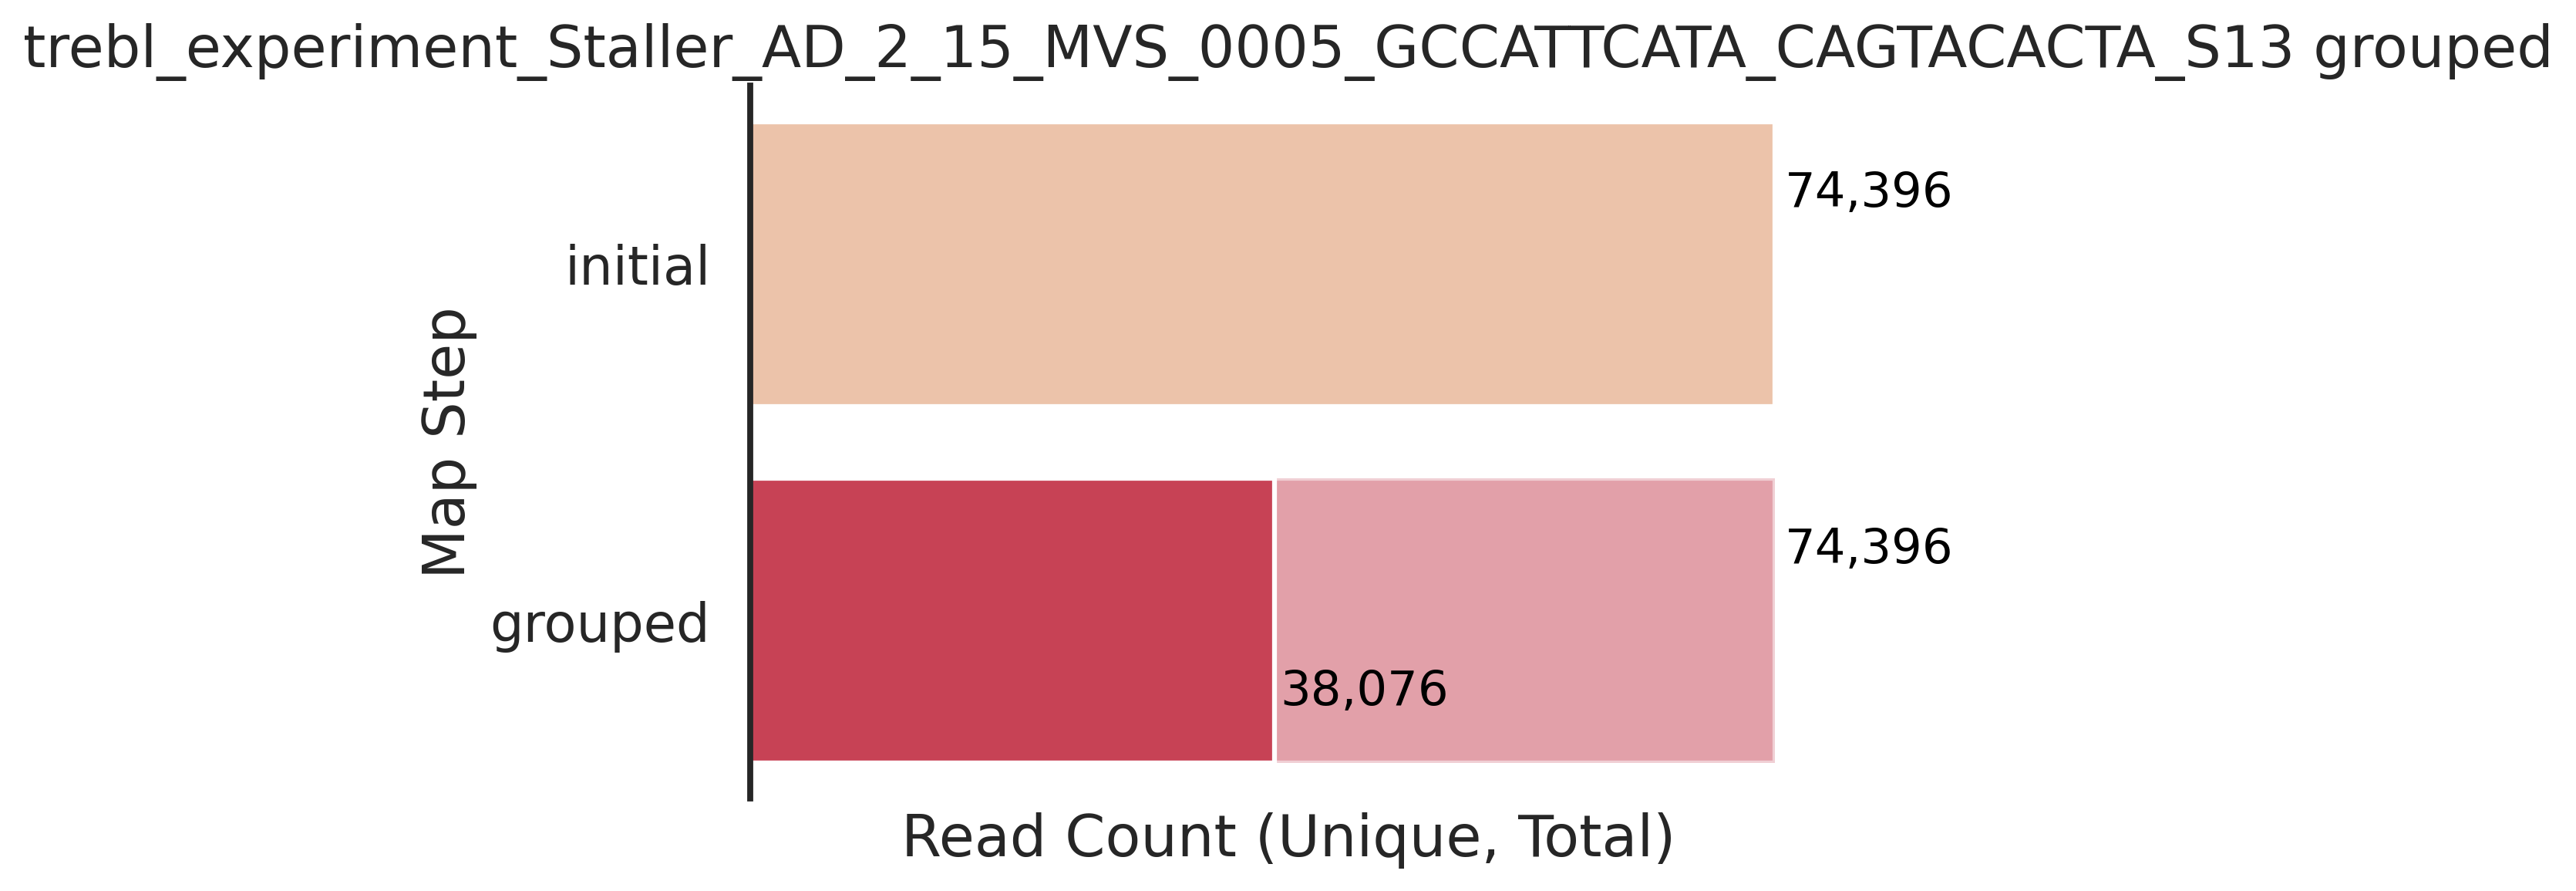

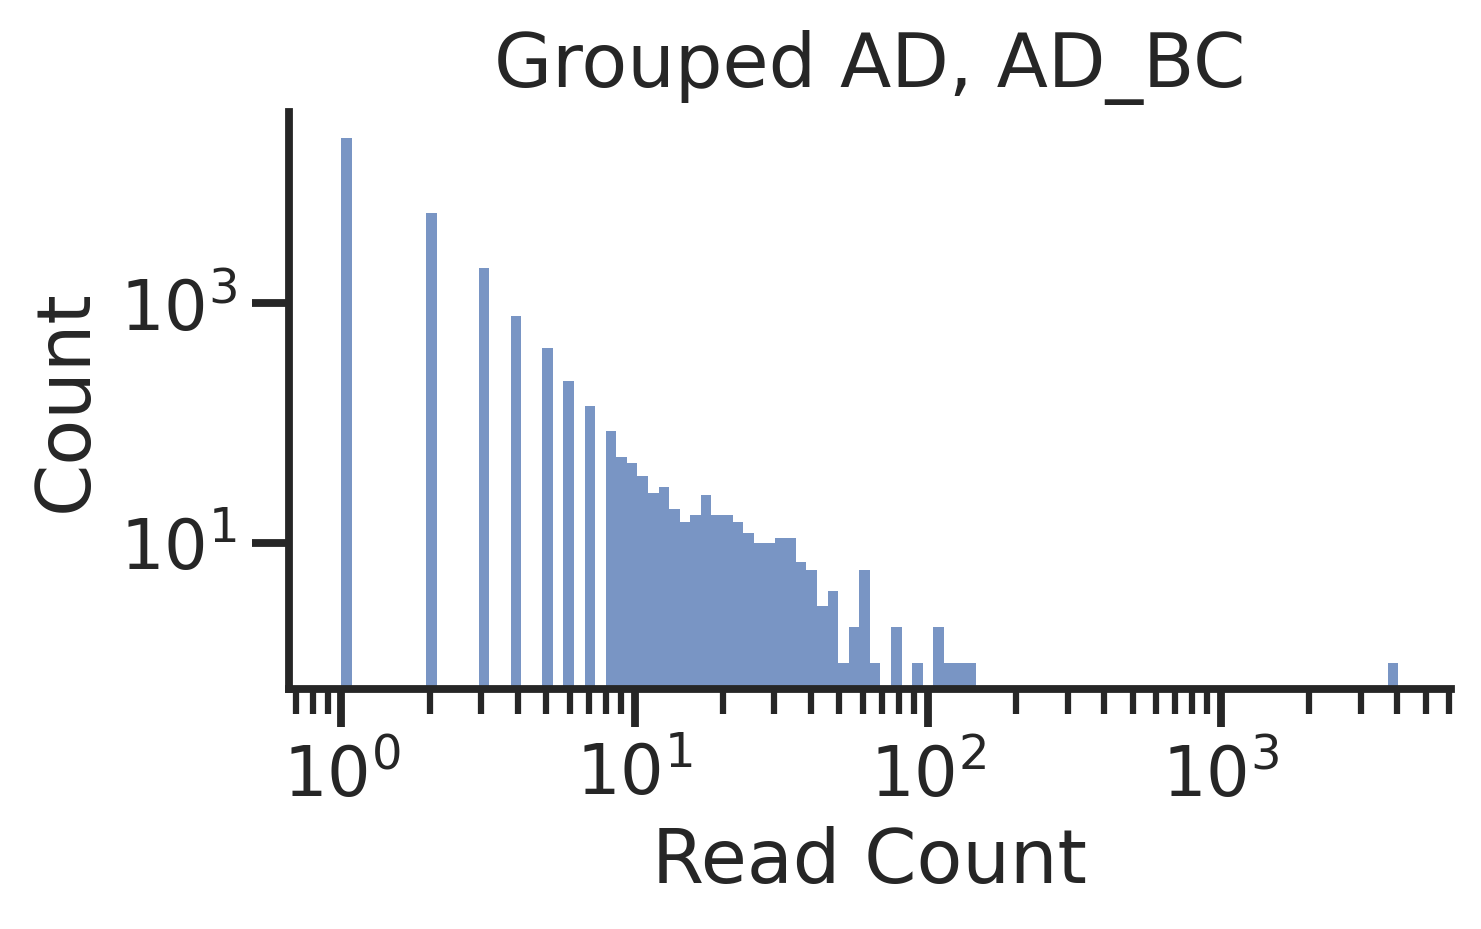

Done in 2.83 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_60_MVS_0026_I1_CAGCCAGAGT_GCCTGATTGA_S18_AD_AD_BC_loss_summary'
Done in 0.06 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.35 seconds.

Reverse complement of sequences...
Done in 1.96 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 1.14 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.34 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_0_MVS_0001_AACGCAATTC_TACGGATACG_S9_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_0_MVS_0001_AACGCAATTC_TACGGATACG_S9_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_0_MVS_0001_AACGCAATTC_TACGGATACG_S9_AD_AD_BC_initial...


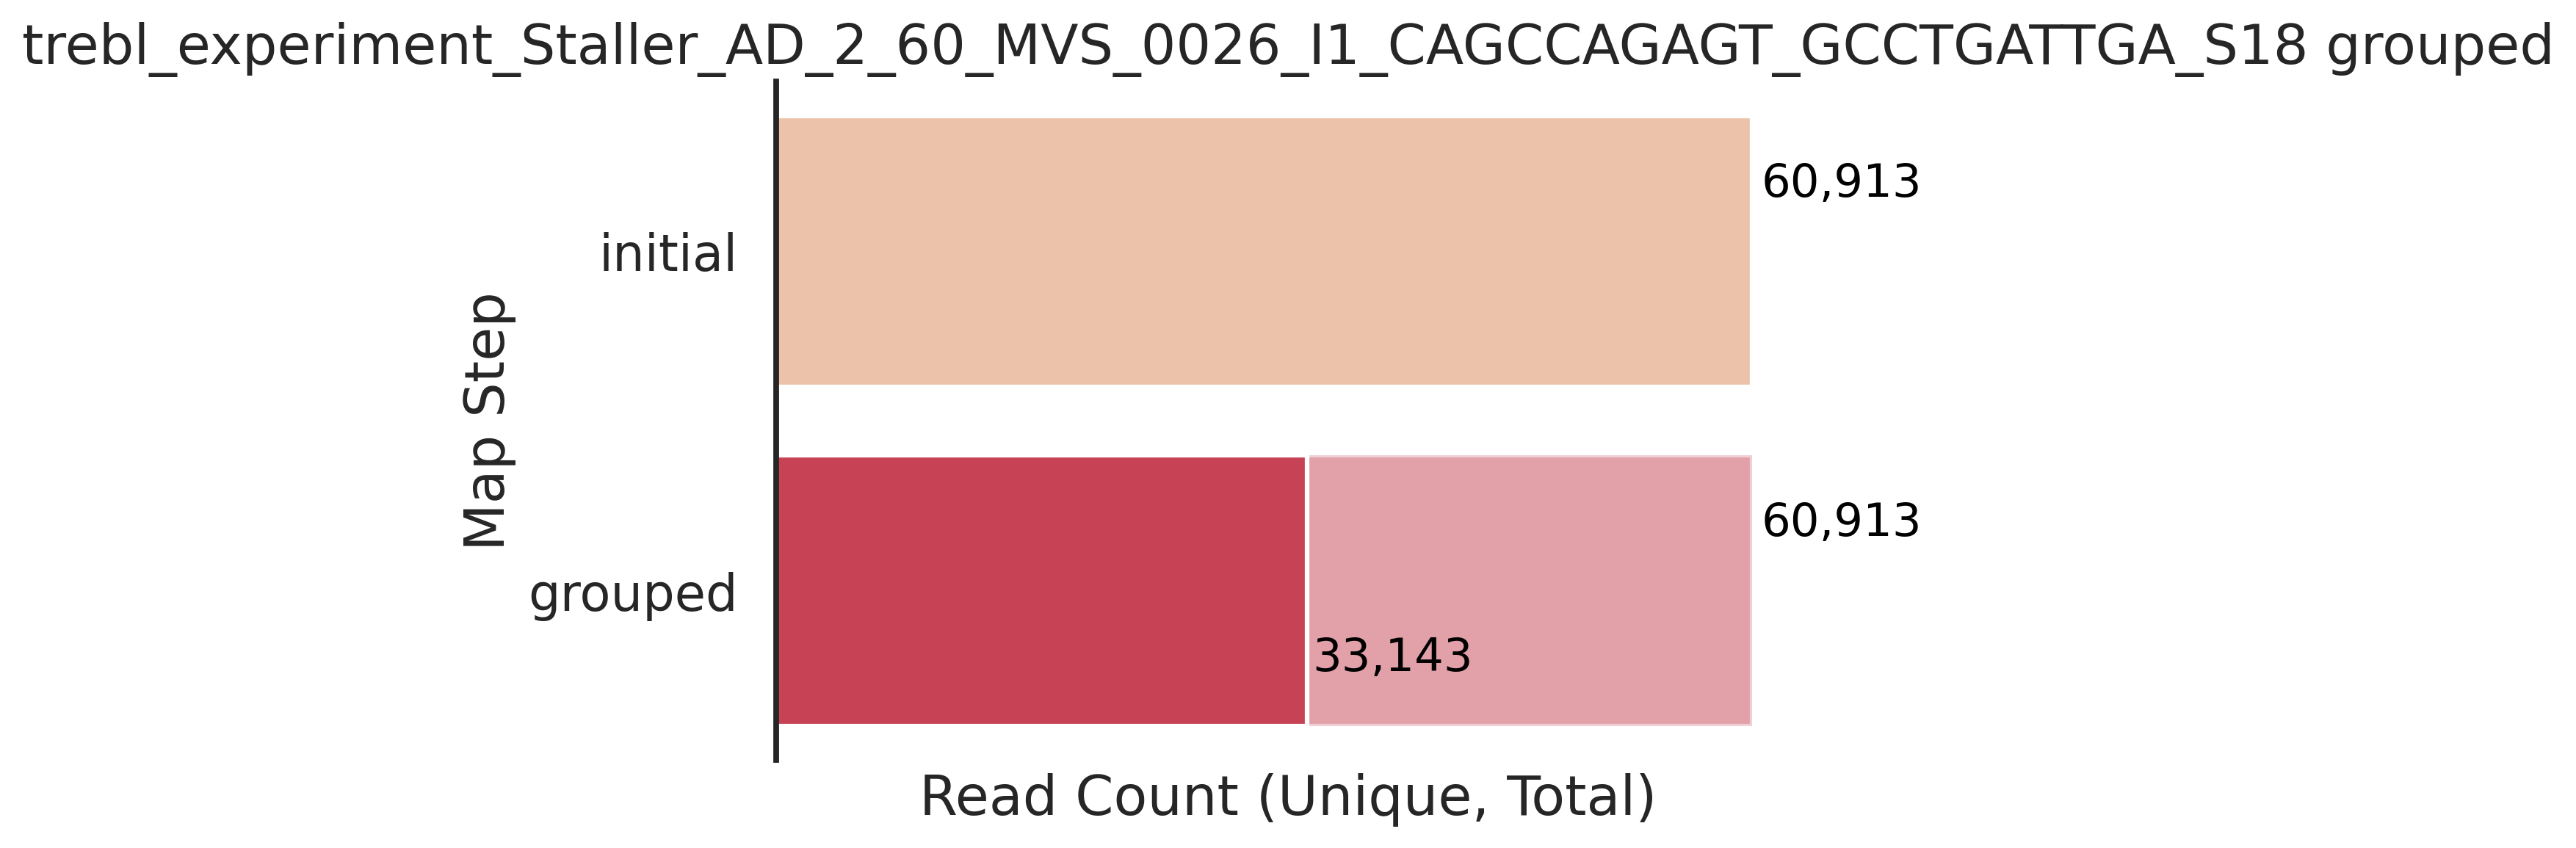

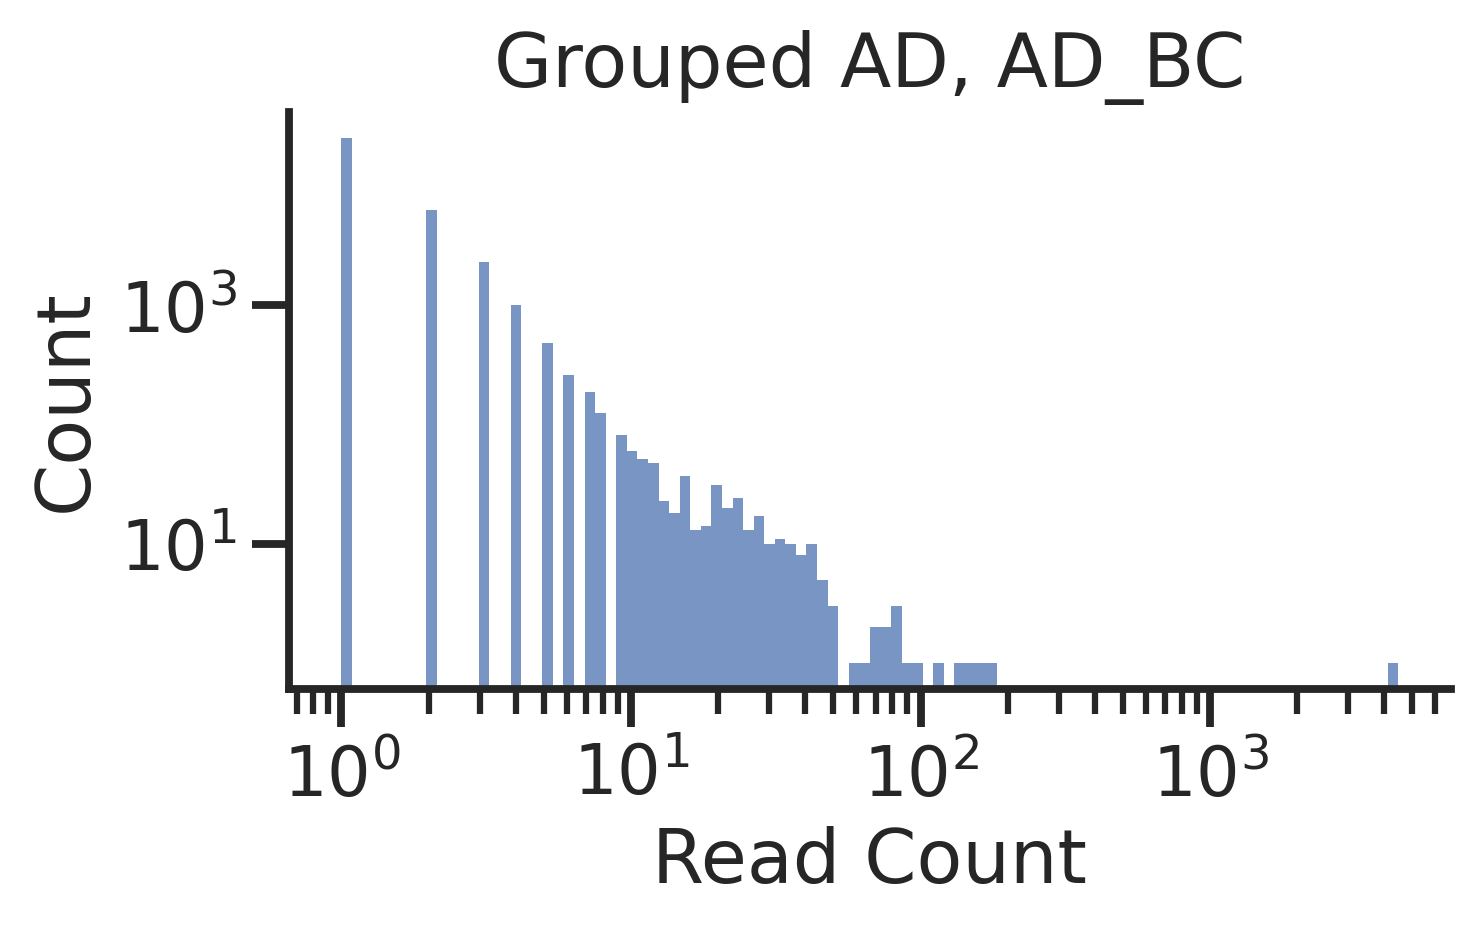

Done in 3.70 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_0_MVS_0001_AACGCAATTC_TACGGATACG_S9_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.32 seconds.

Reverse complement of sequences...
Done in 1.69 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.96 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.30 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_40_MVS_0008_GTCGCACAGA_ATCCAACTCG_S16_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_40_MVS_0008_GTCGCACAGA_ATCCAACTCG_S16_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_40_MVS_0008_GTCGCACAGA_ATCCAACTCG_S16_AD_AD_BC_initial...


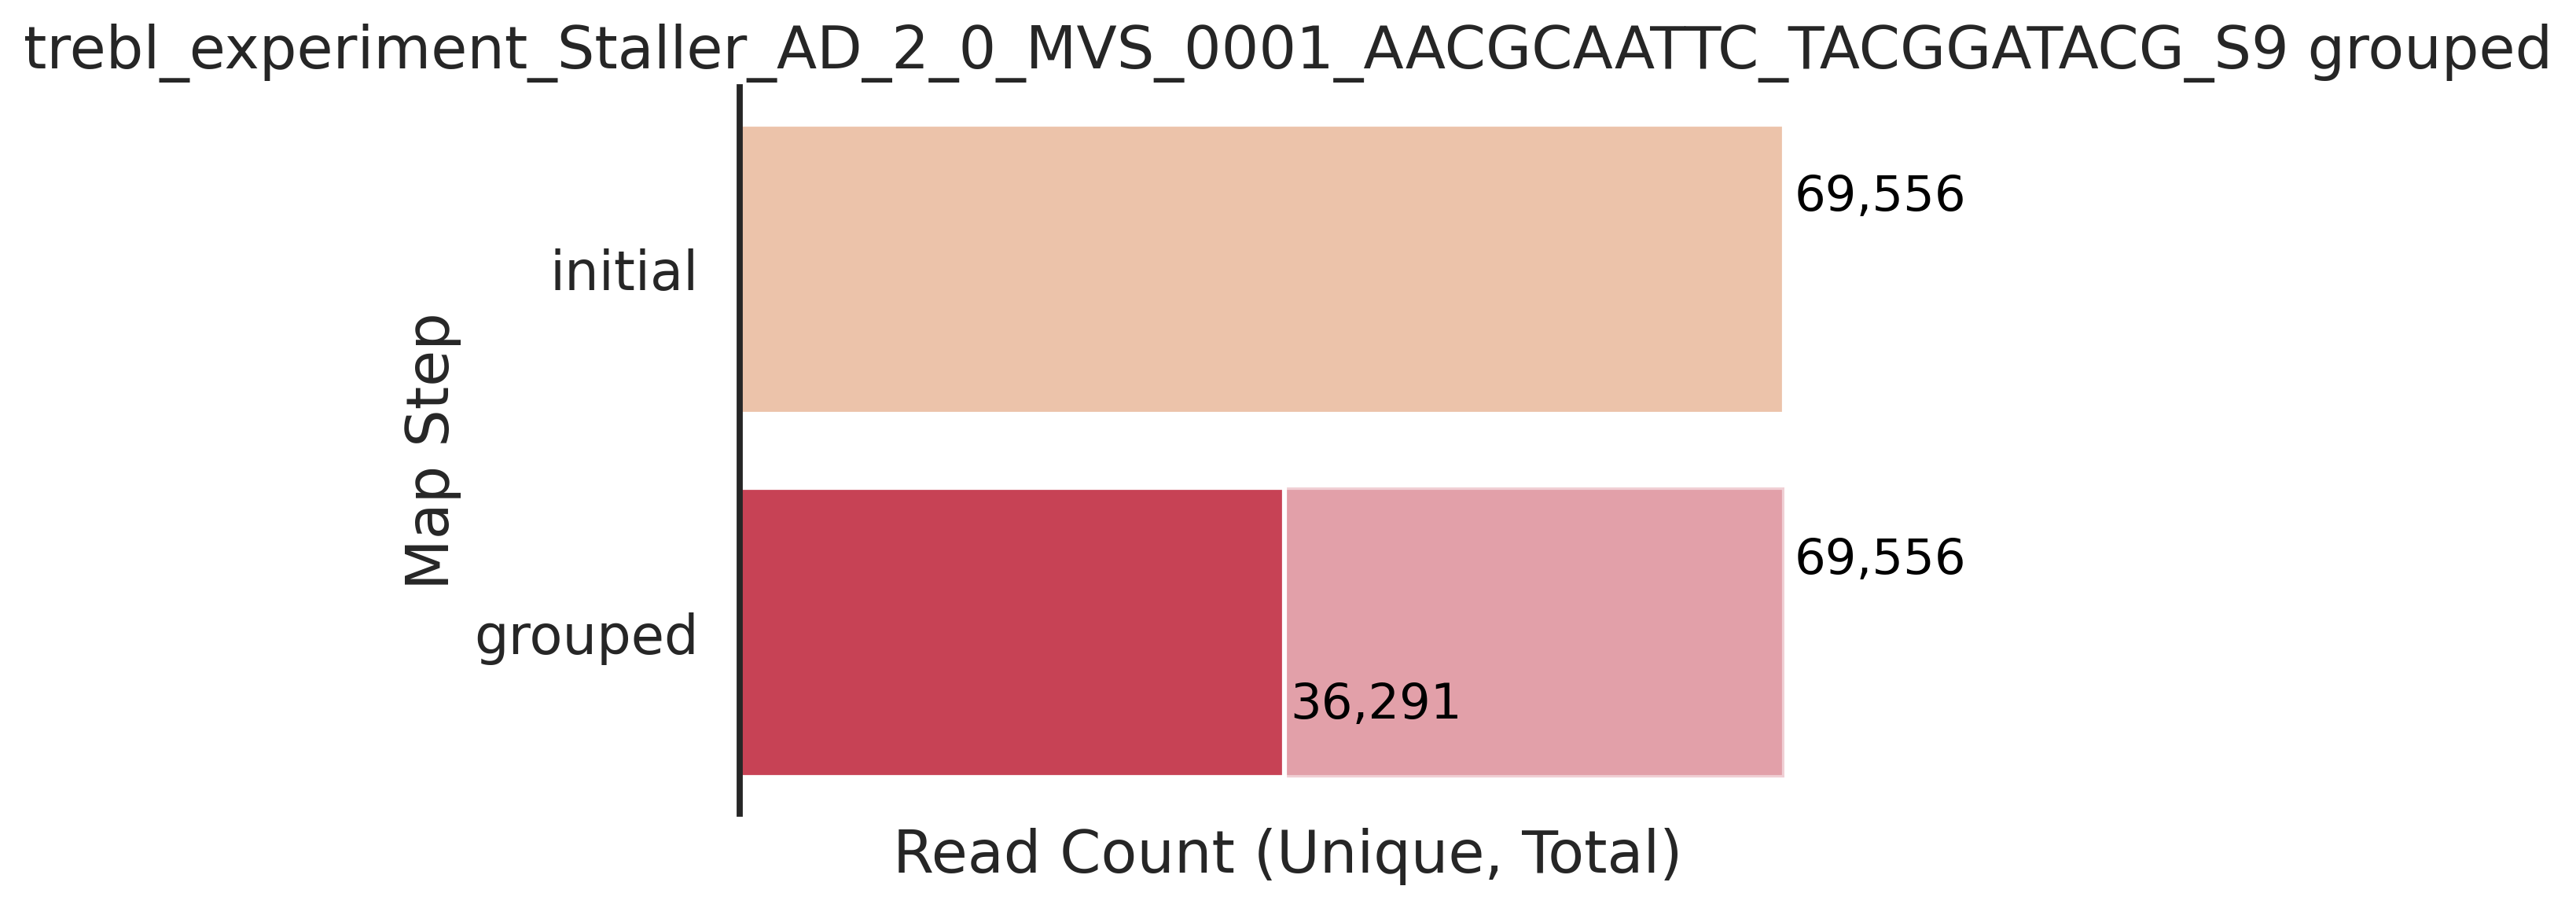

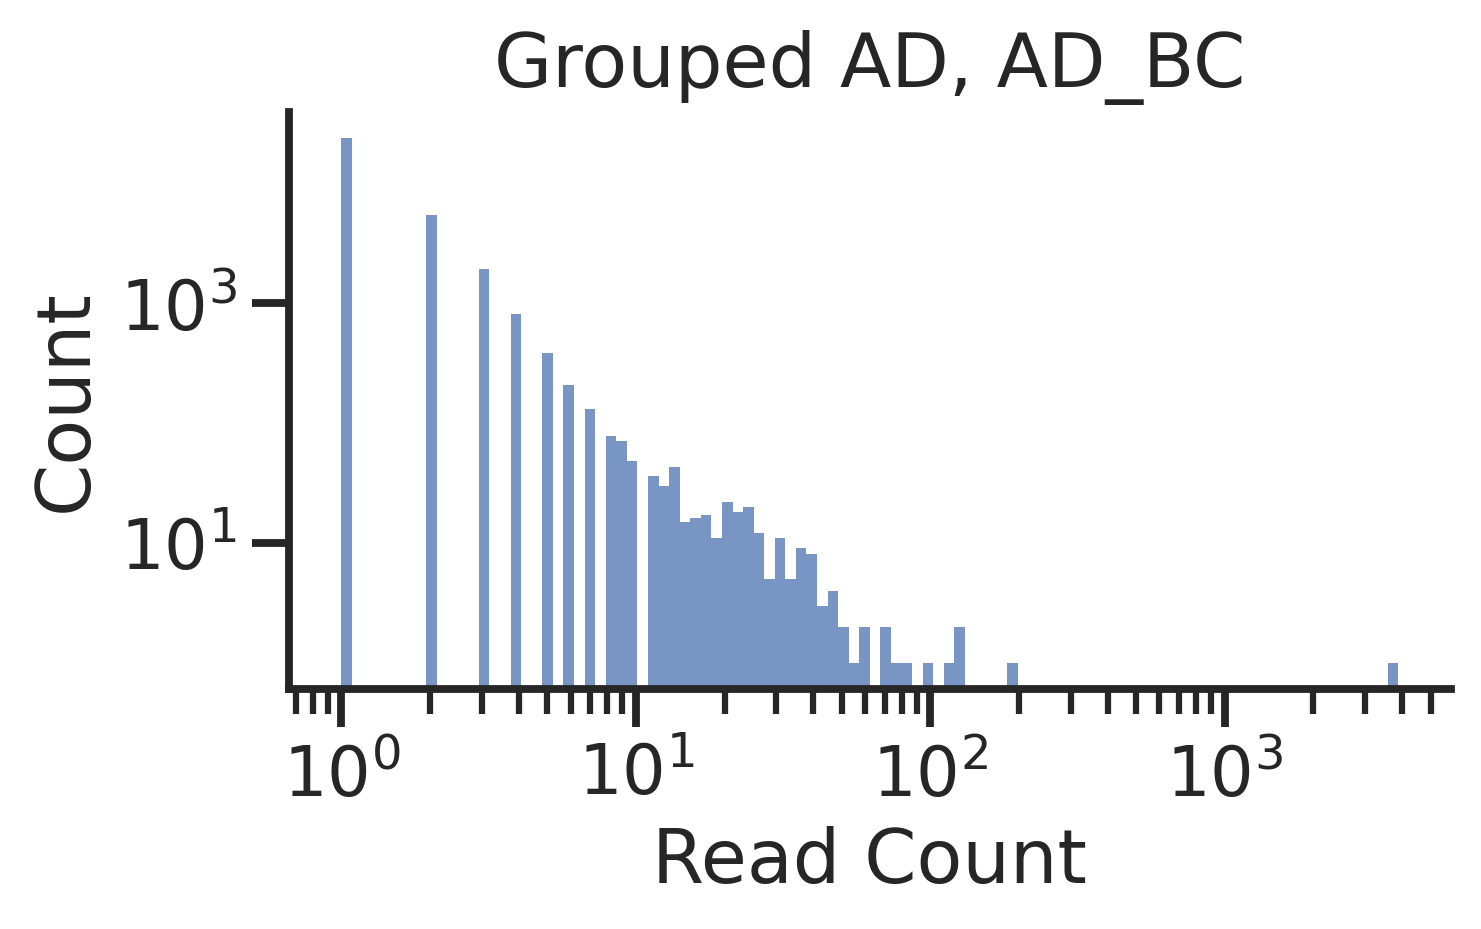

Done in 2.93 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_40_MVS_0008_GTCGCACAGA_ATCCAACTCG_S16_AD_AD_BC_loss_summary'
Done in 0.07 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.32 seconds.

Reverse complement of sequences...
Done in 1.77 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 1.01 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.31 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCTCAC_S17_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCTCAC_S17_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCTCAC_S17_AD_AD_BC_initial...


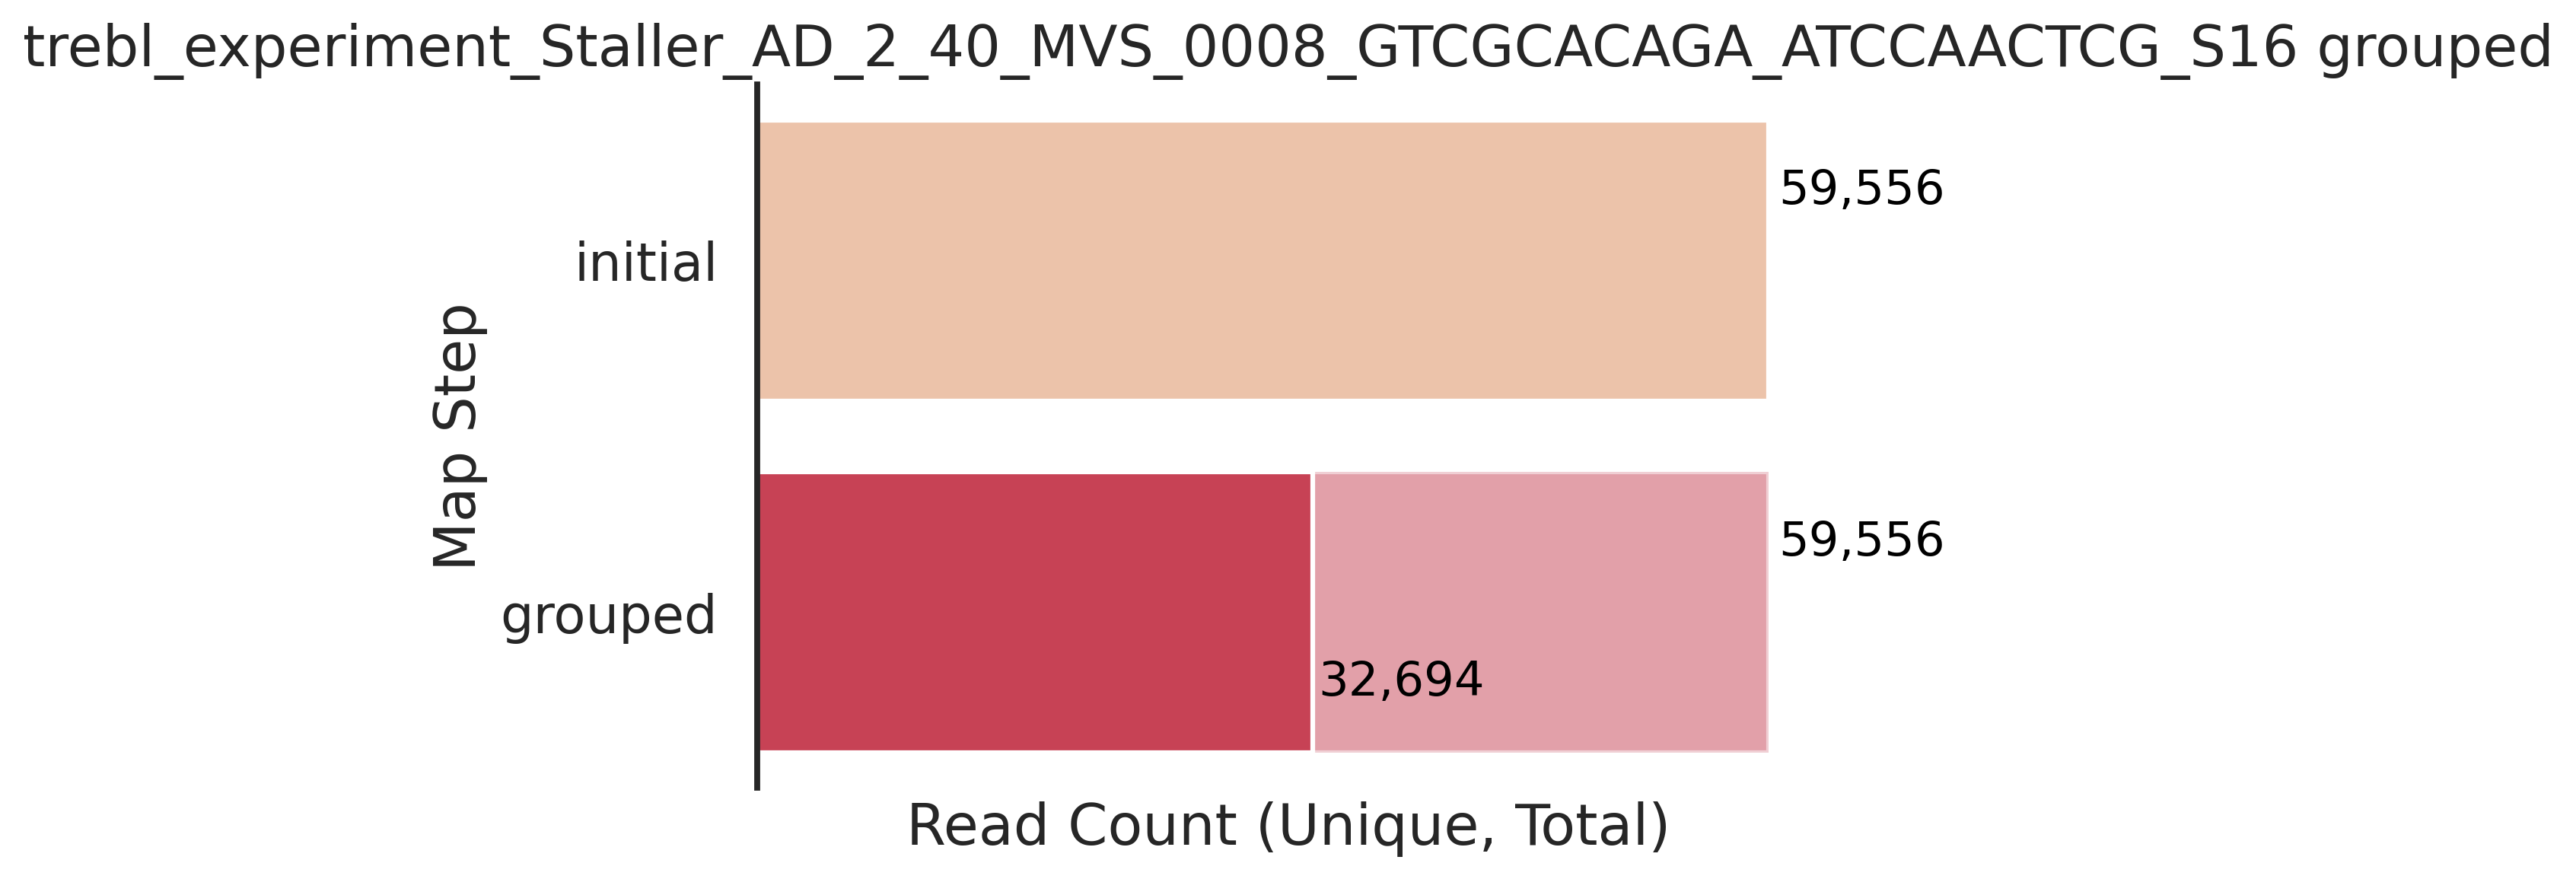

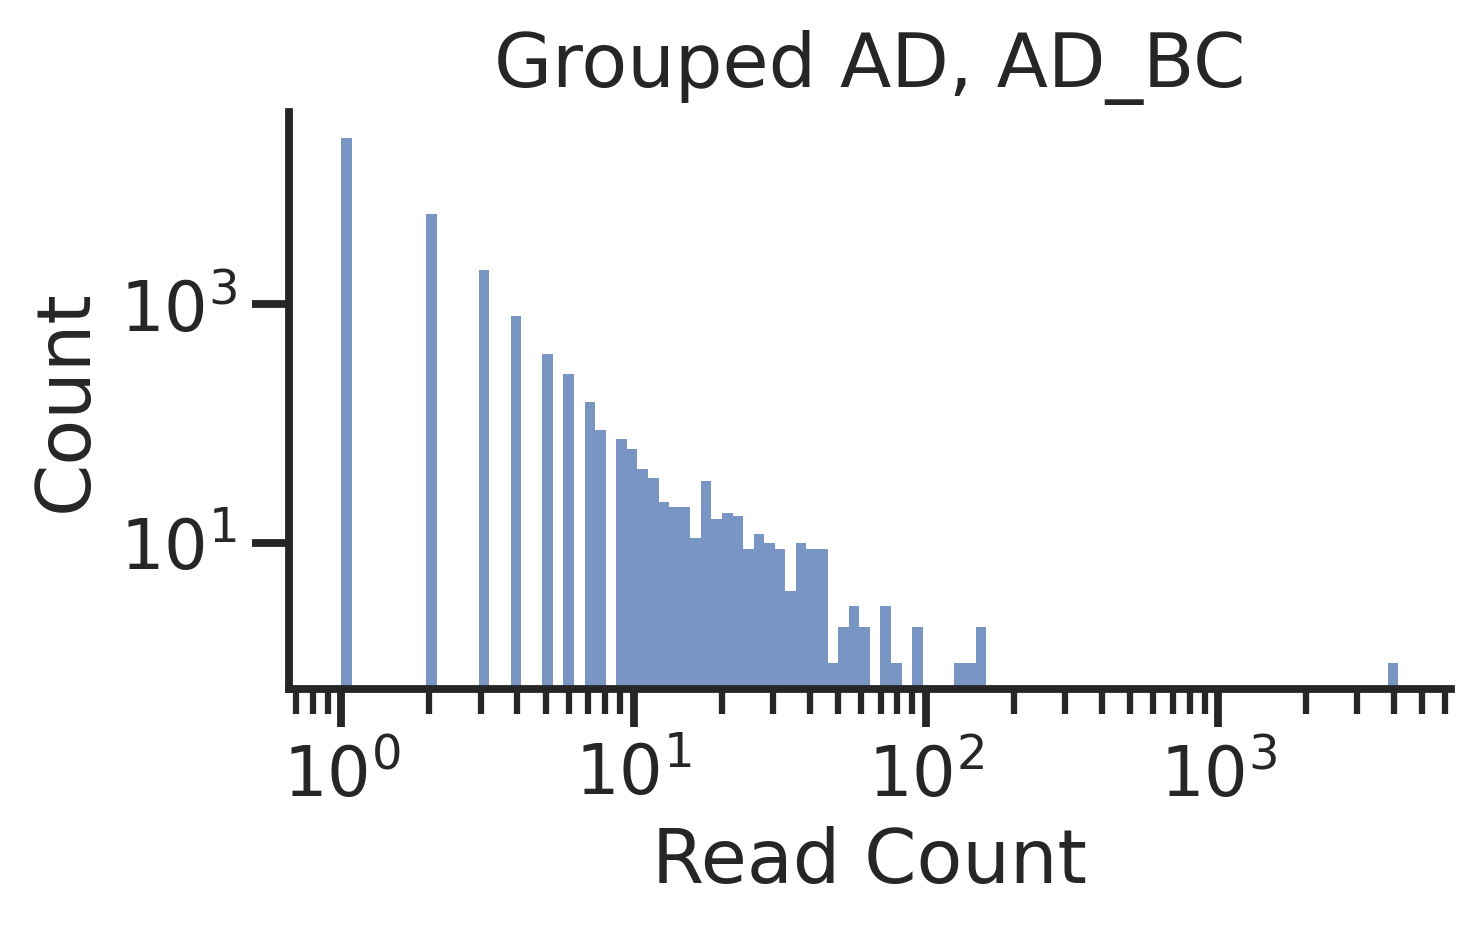

Done in 2.98 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_50_MVS_0025_I1_CTGGTCCGAT_CACTCCTCAC_S17_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.39 seconds.

Reverse complement of sequences...
Done in 1.79 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 1.03 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.30 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_20_MVS_0006_TCCAGCCTAA_AATCCGCGCT_S14_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_20_MVS_0006_TCCAGCCTAA_AATCCGCGCT_S14_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_20_MVS_0006_TCCAGCCTAA_AATCCGCGCT_S14_AD_AD_BC_initial...


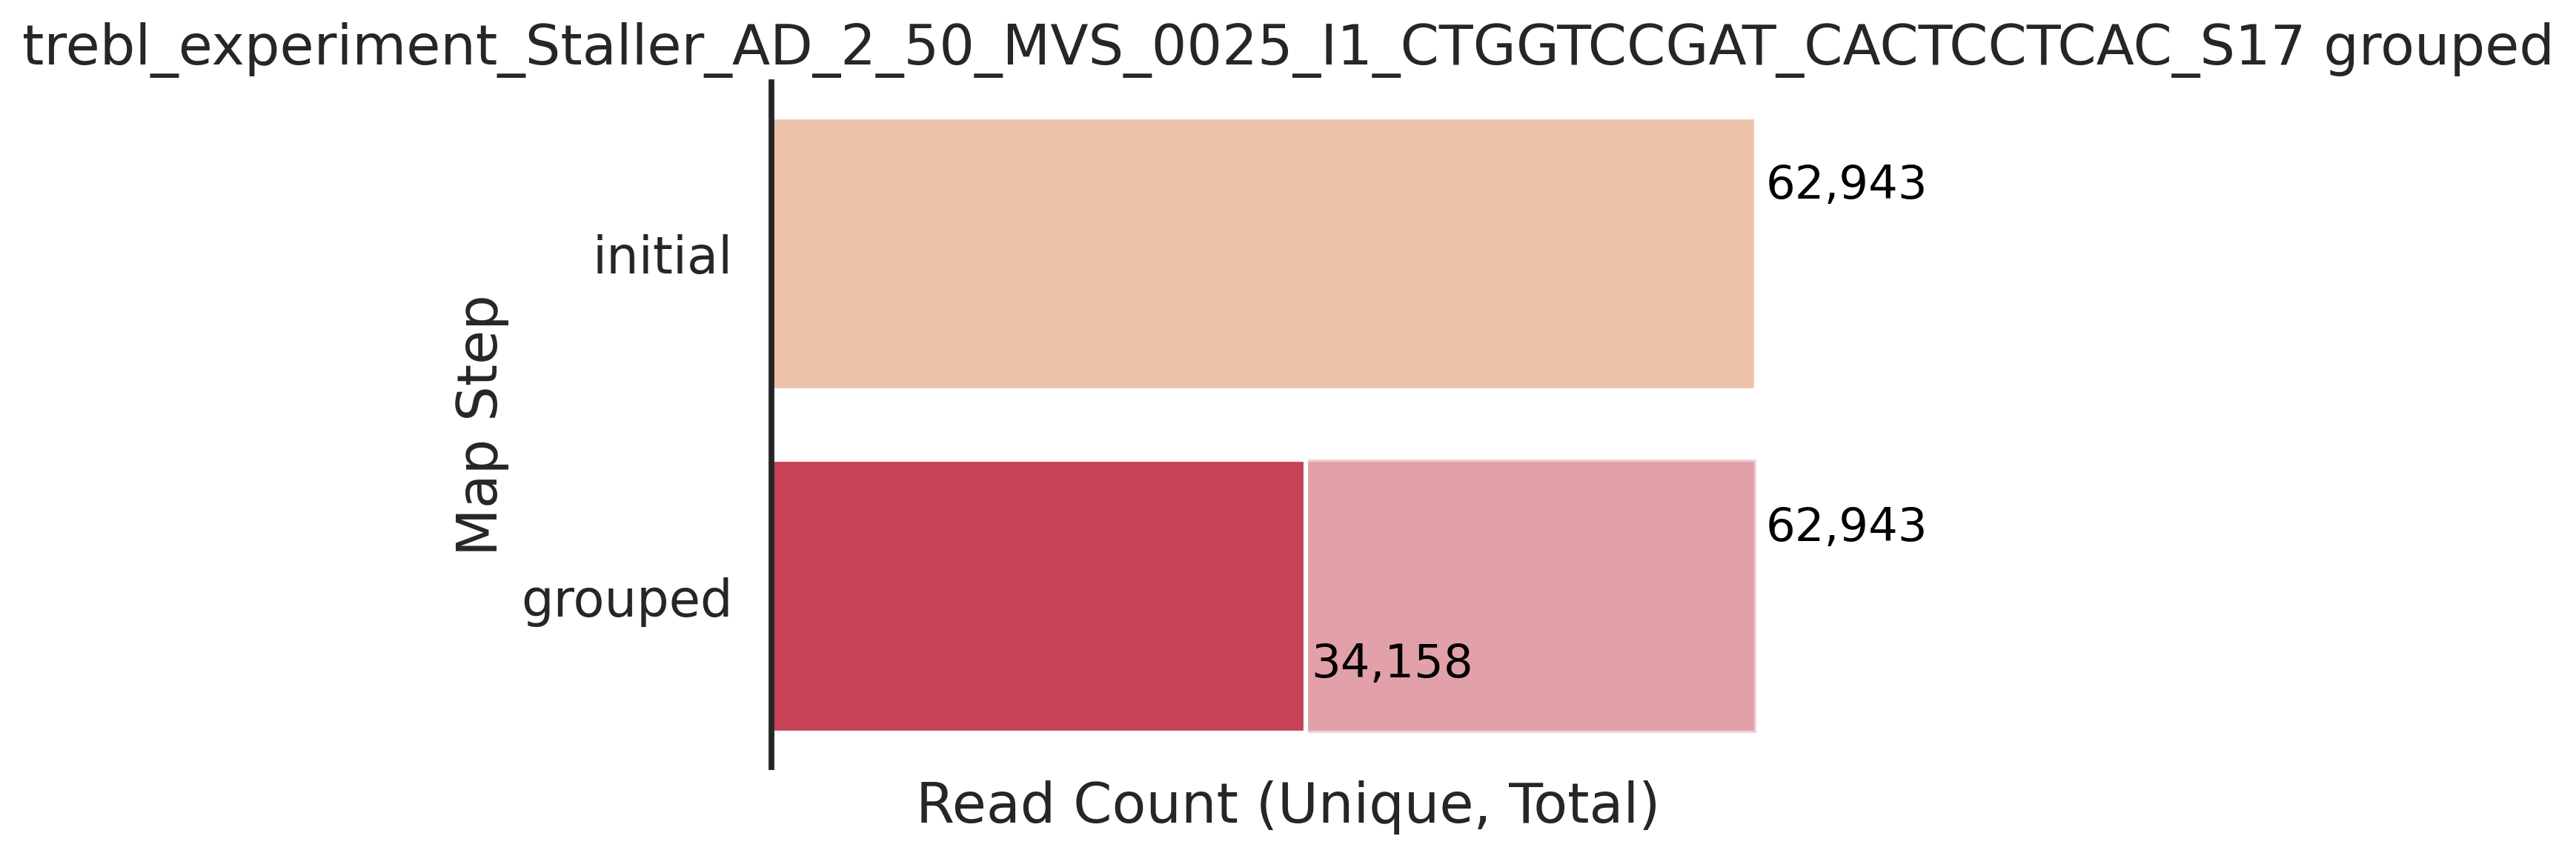

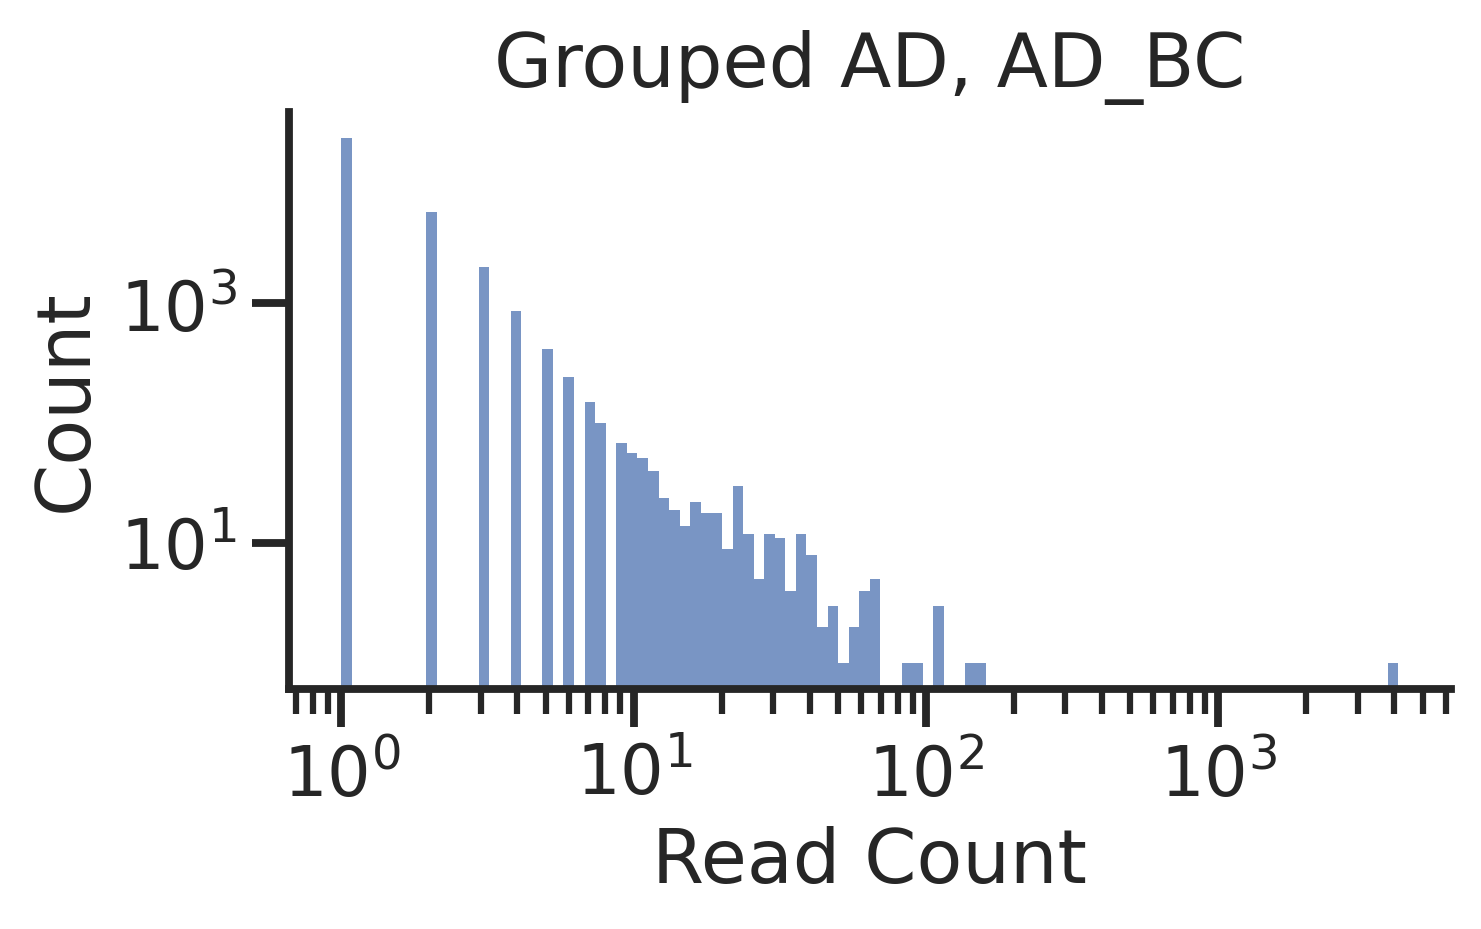

Done in 2.97 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_20_MVS_0006_TCCAGCCTAA_AATCCGCGCT_S14_AD_AD_BC_loss_summary'
Done in 0.07 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.31 seconds.

Reverse complement of sequences...
Done in 1.74 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.99 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.30 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11_AD_AD_BC_initial...


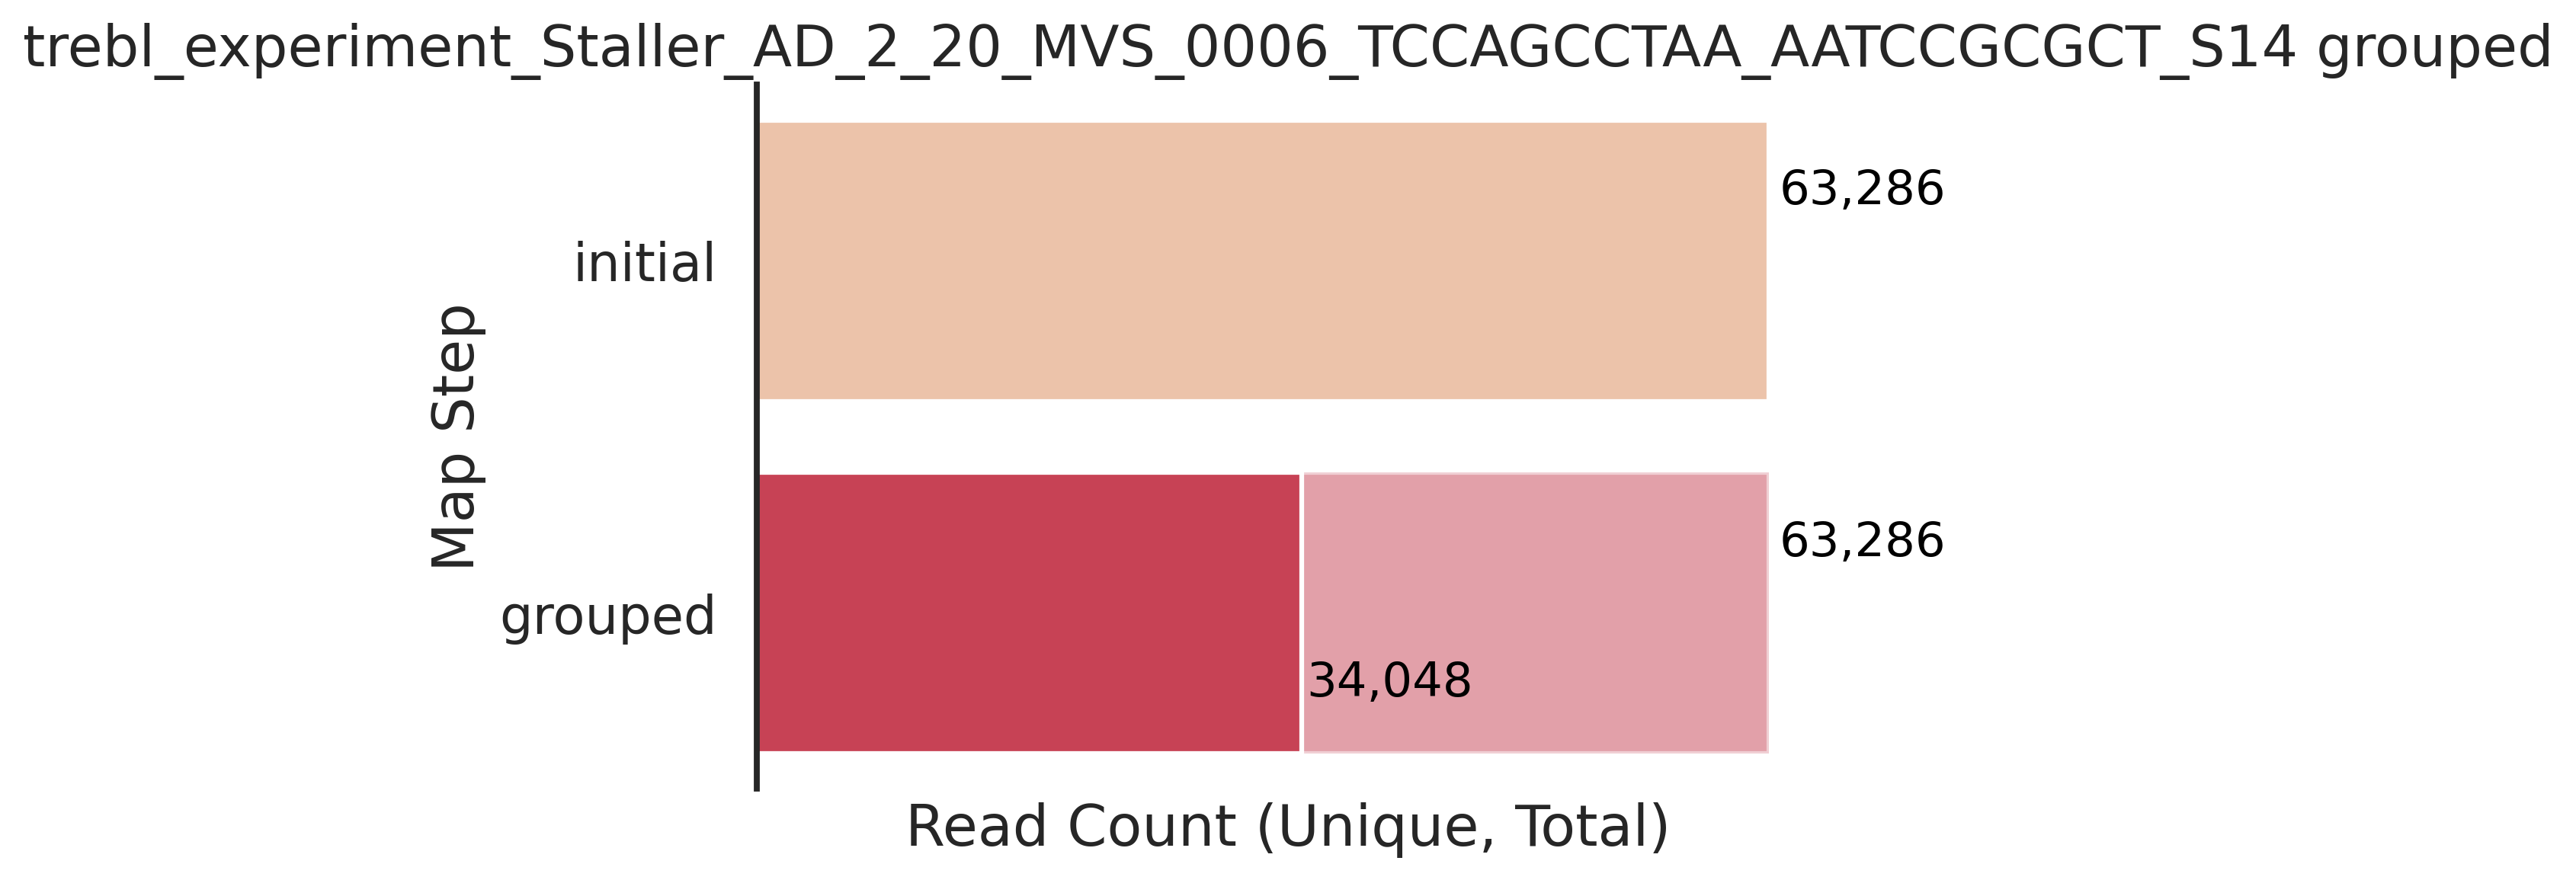

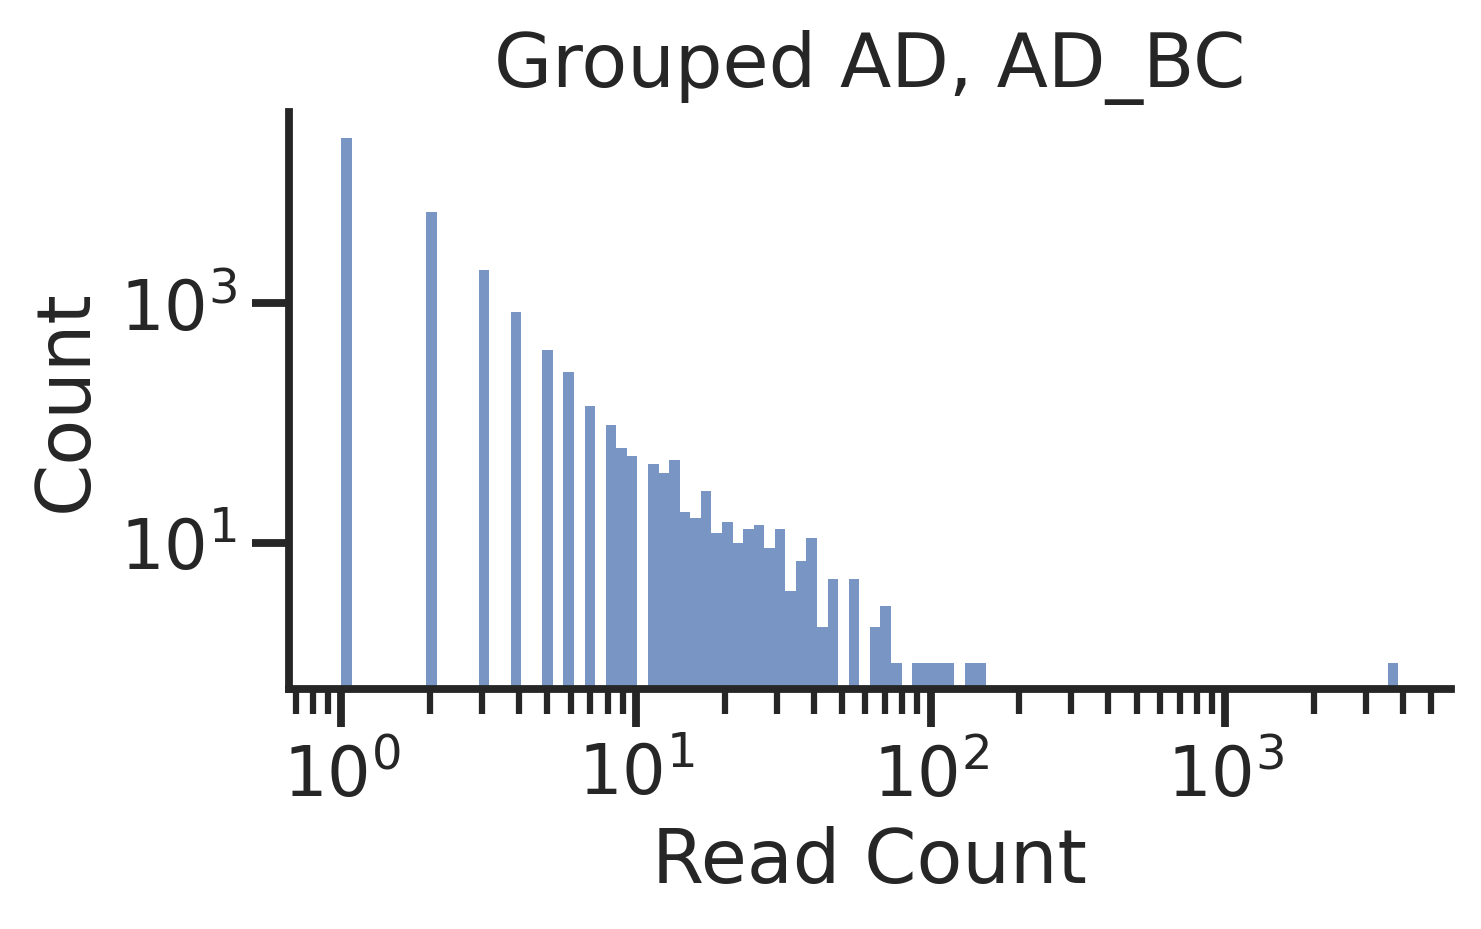

Done in 2.94 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_5_MVS_0003_TGGACTCGAA_CAATACGGAA_S11_AD_AD_BC_loss_summary'
Done in 0.07 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.32 seconds.

Reverse complement of sequences...
Done in 1.78 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 1.02 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.31 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA_S15_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA_S15_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA_S15_AD_AD_BC_initial...


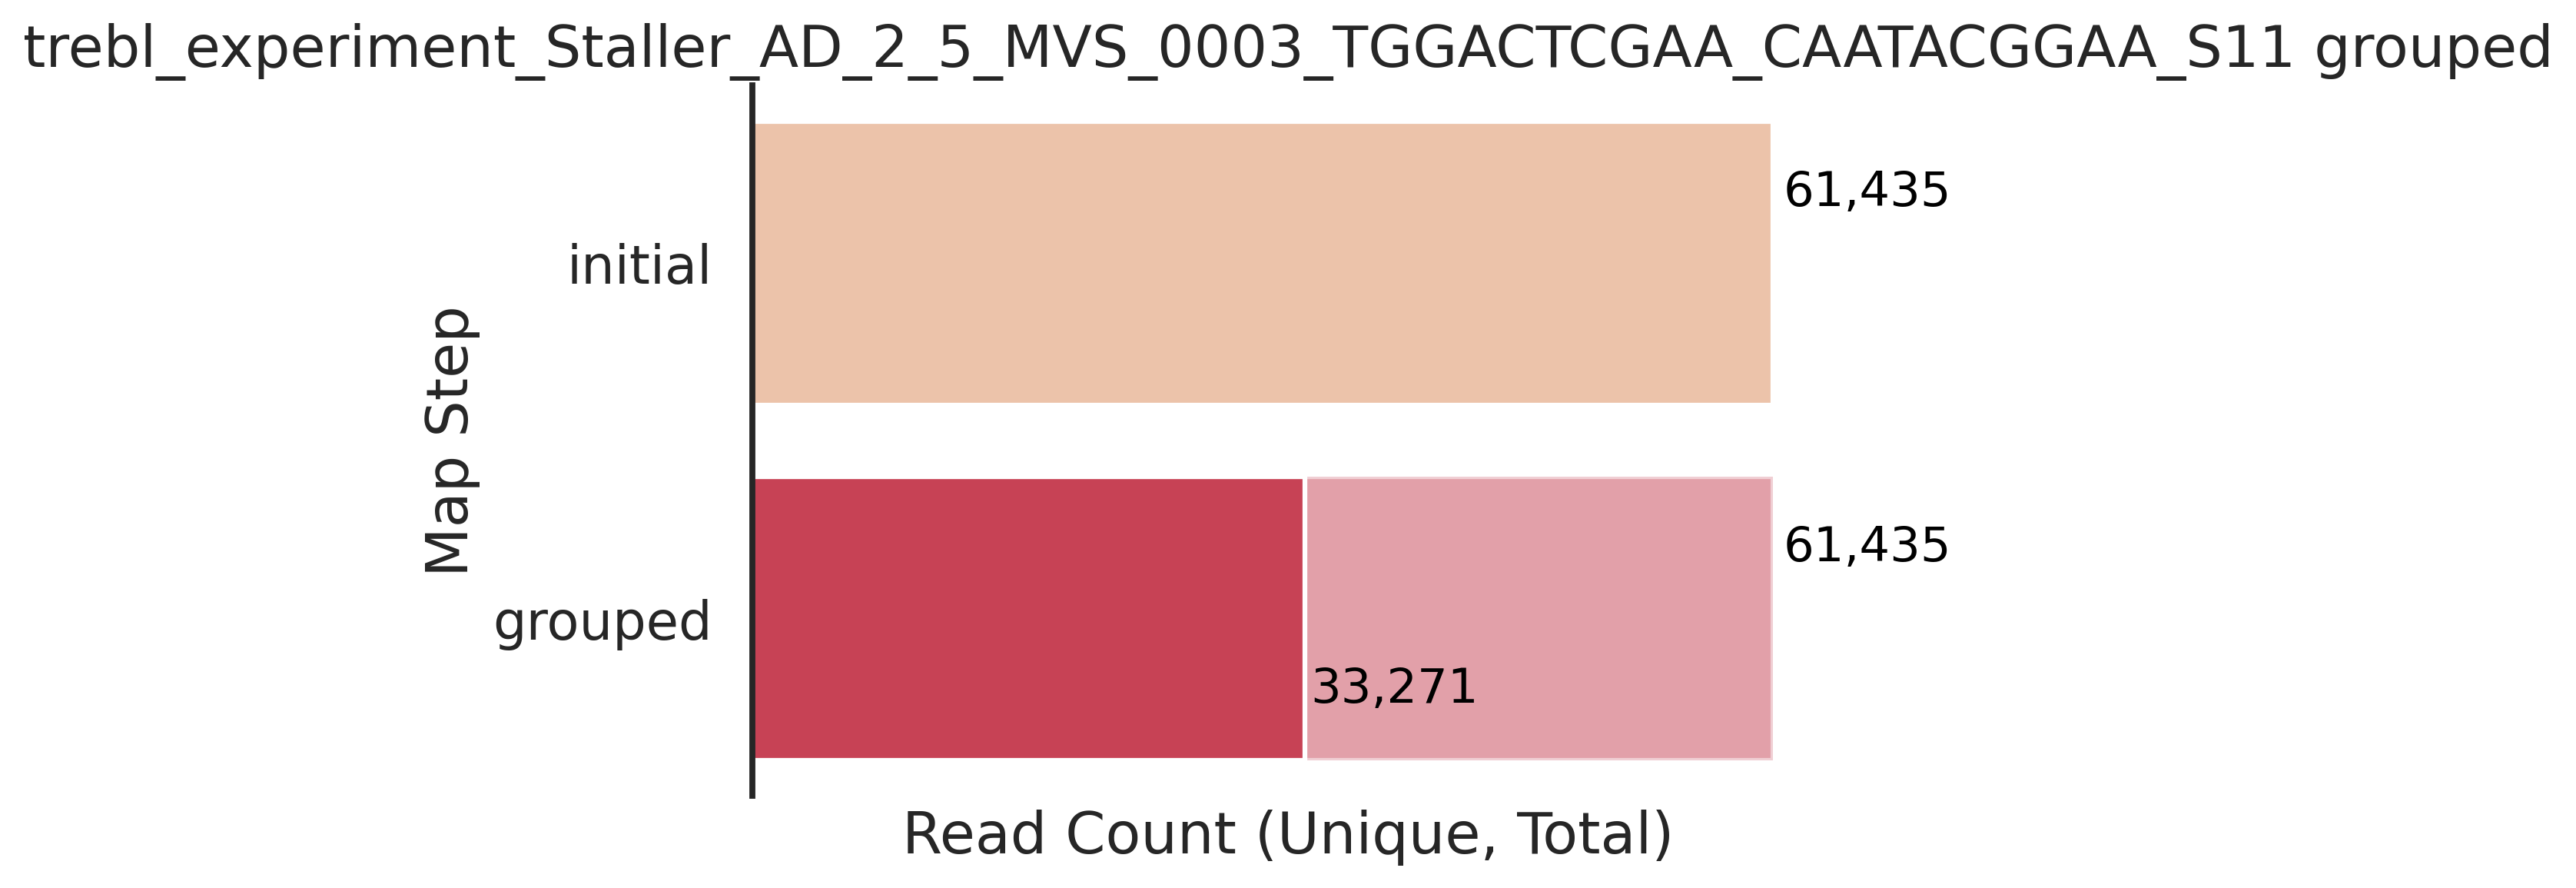

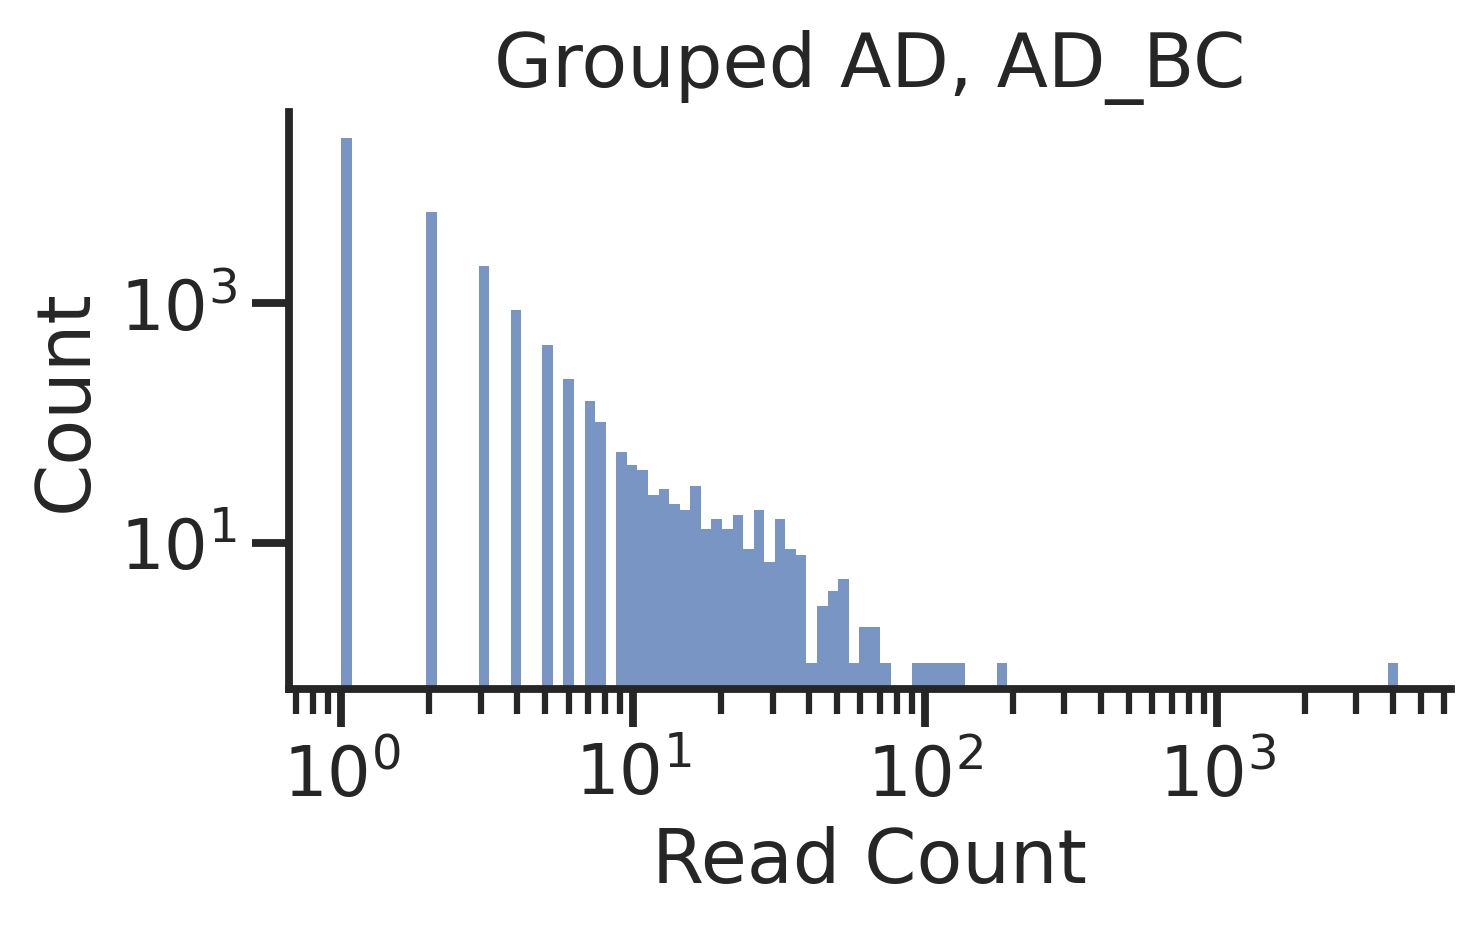

Done in 2.94 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_30_MVS_0007_GCTTGATATC_ATAAGGTGCA_S15_AD_AD_BC_loss_summary'
Done in 0.08 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.29 seconds.

Reverse complement of sequences...
Done in 1.51 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.86 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.29 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10_AD_AD_BC_initial...


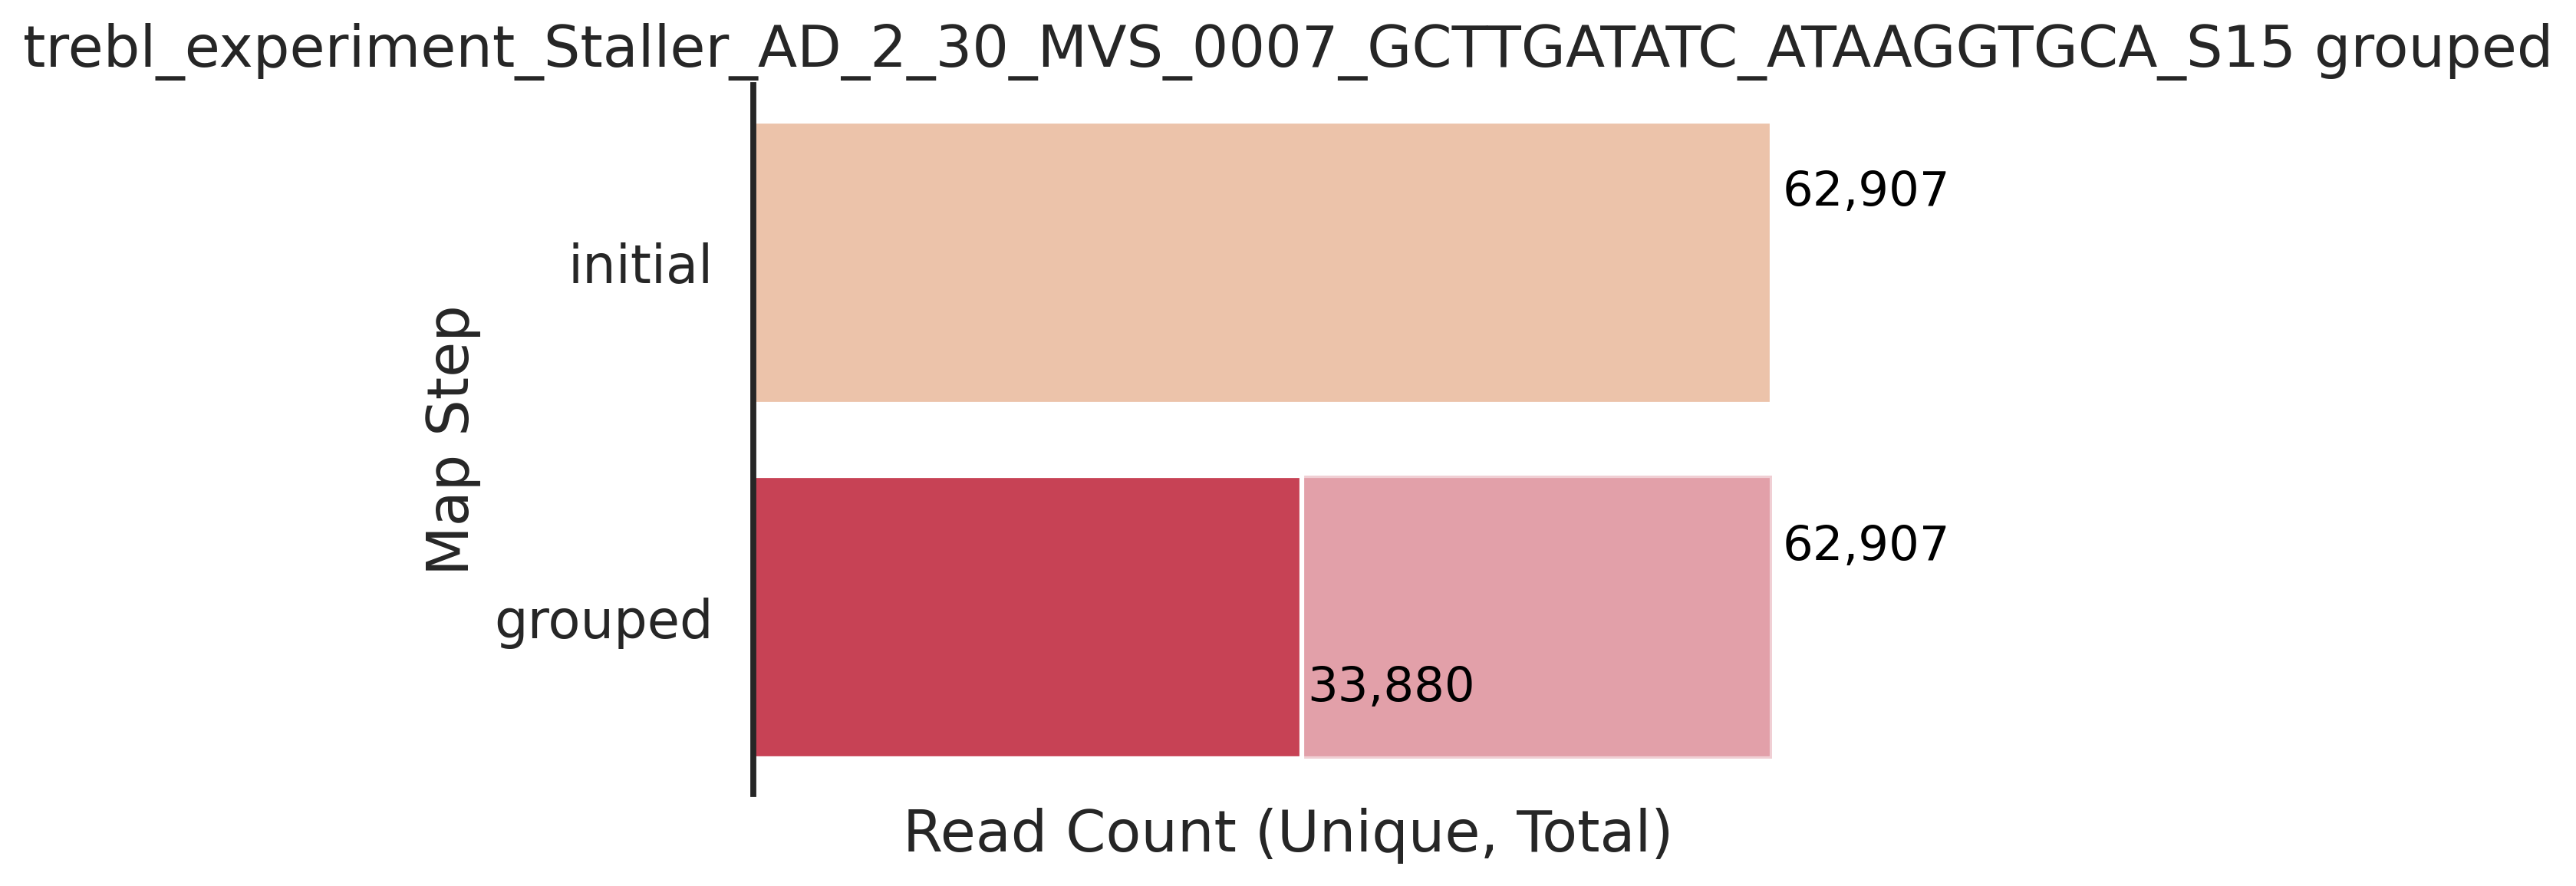

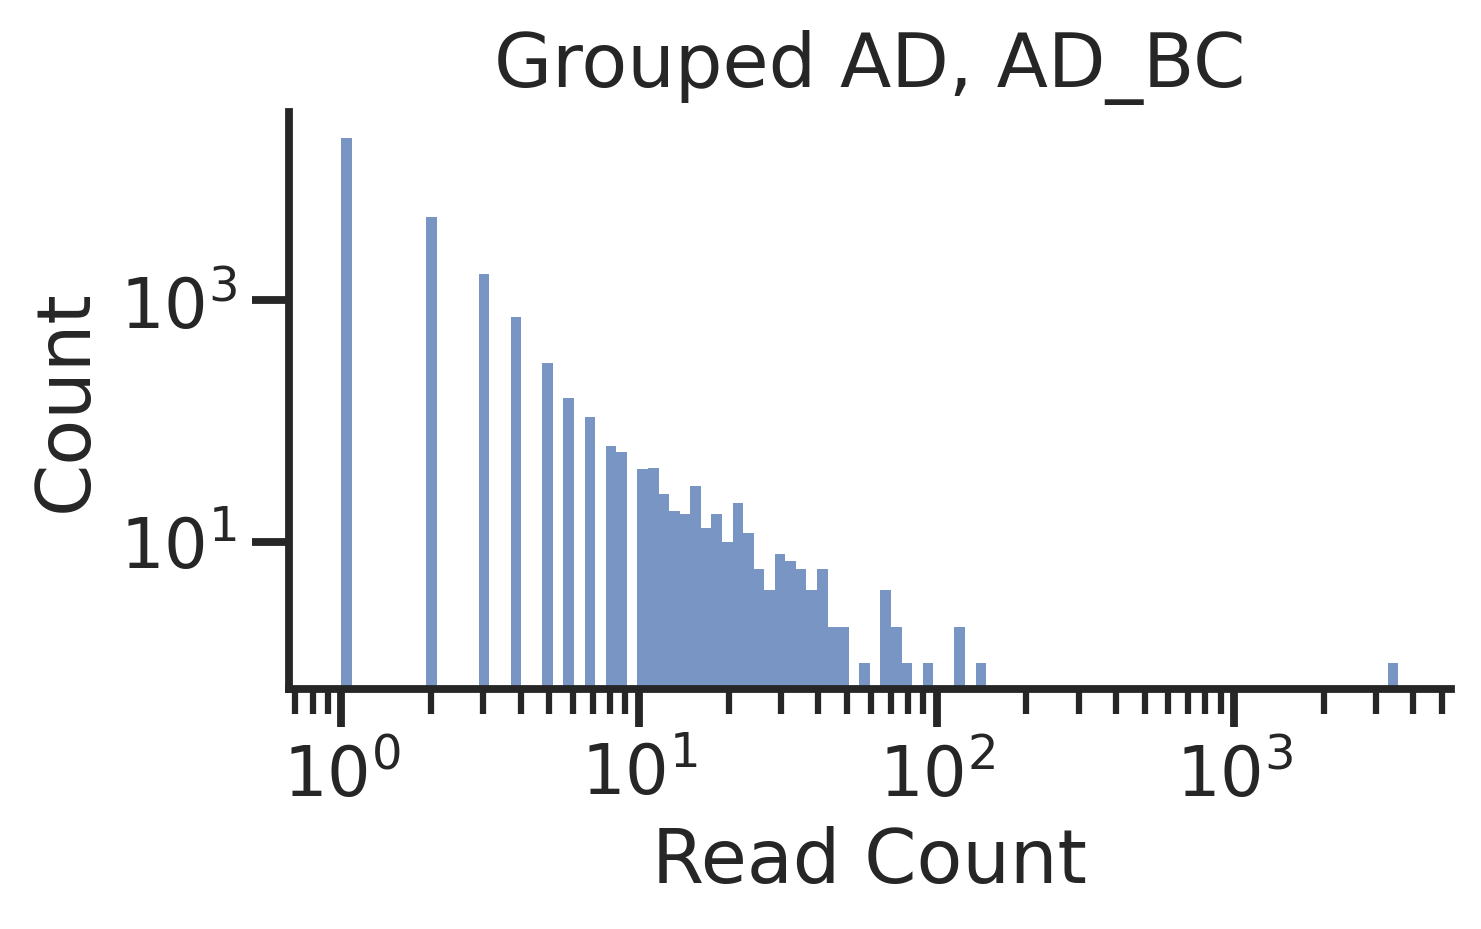

Done in 2.90 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_2_MVS_0002_CGTCGCTAAG_TCCTGGTATT_S10_AD_AD_BC_loss_summary'
Done in 0.07 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.57 seconds.

Reverse complement of sequences...
Done in 1.74 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 1.01 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.31 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA_S12_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA_S12_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA_S12_AD_AD_BC_initial...


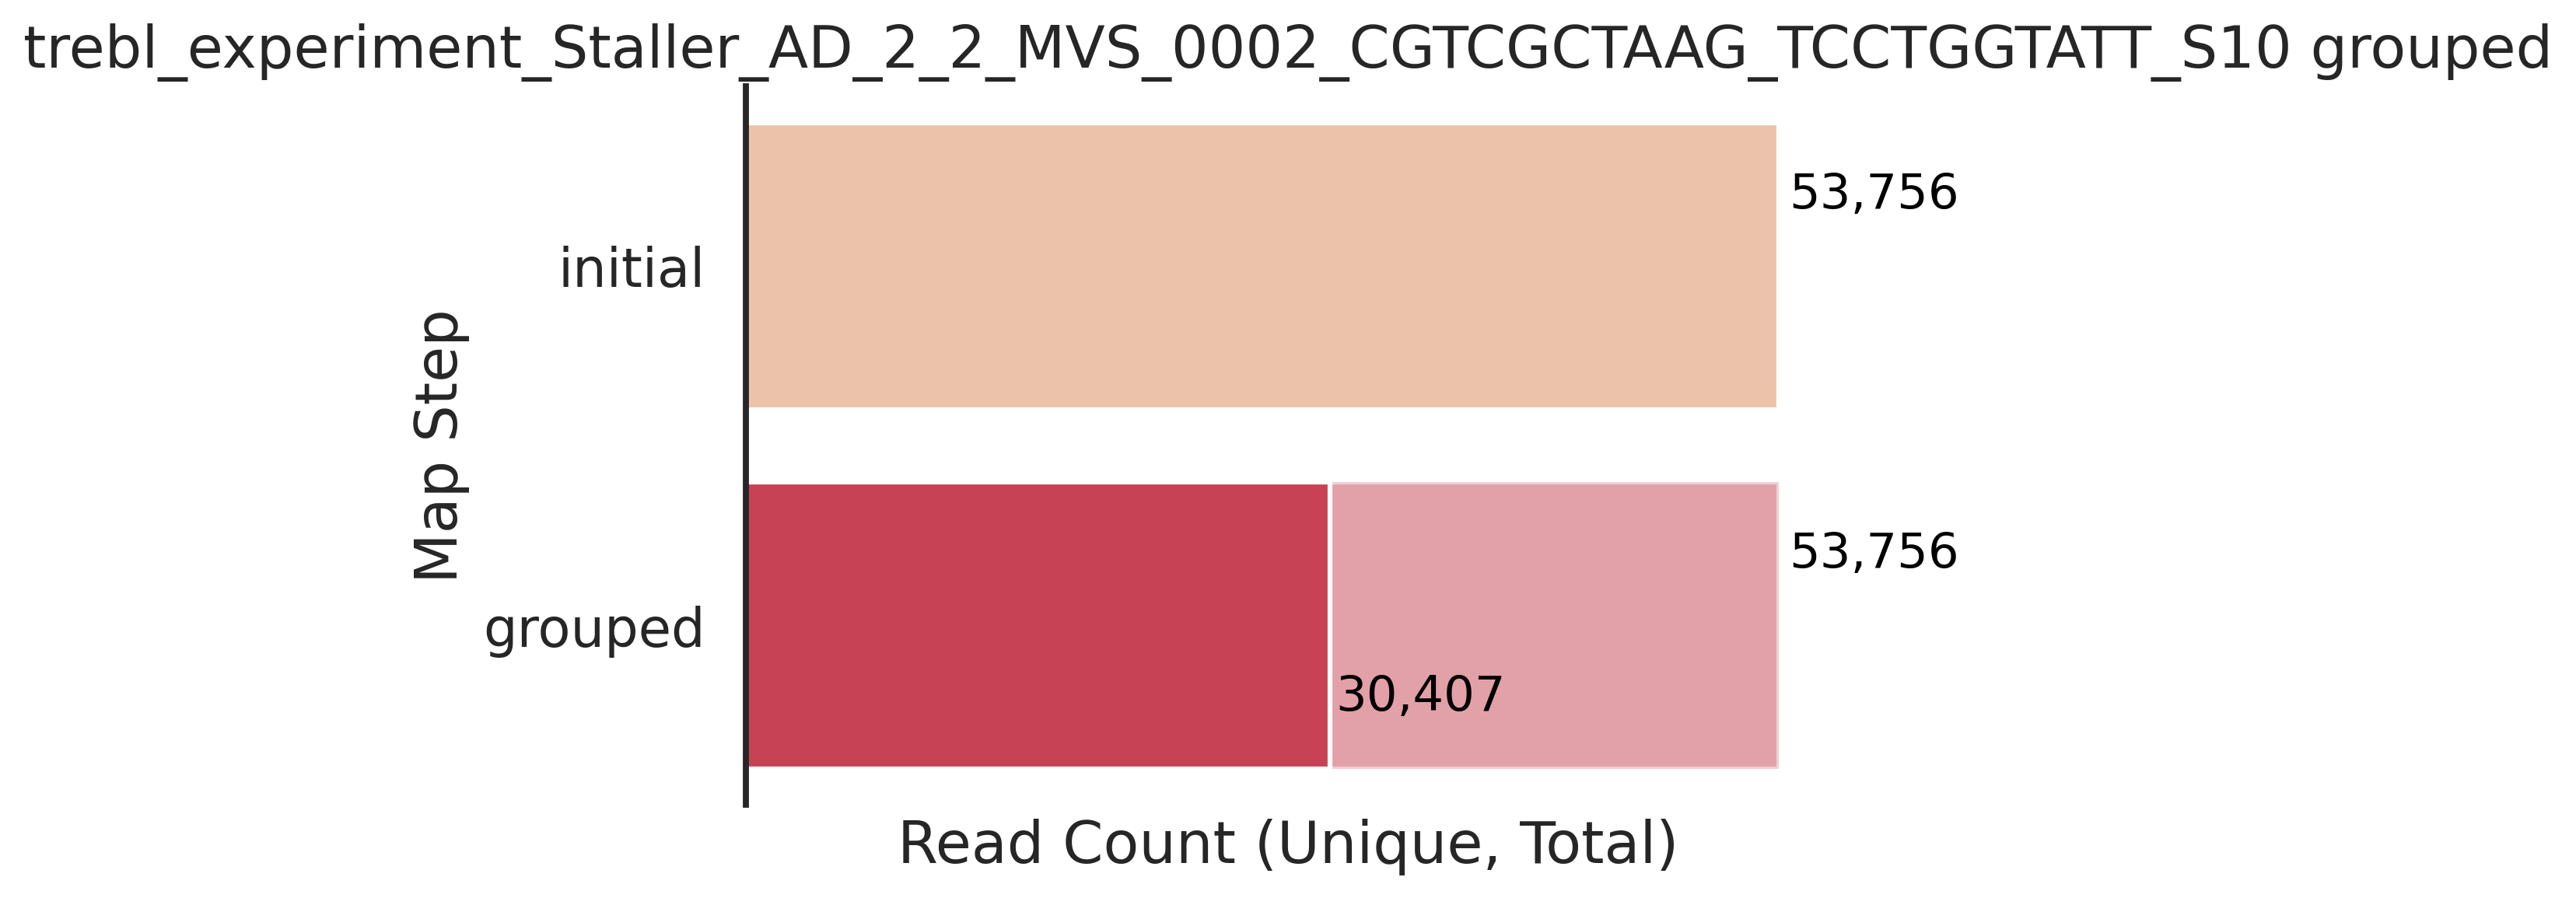

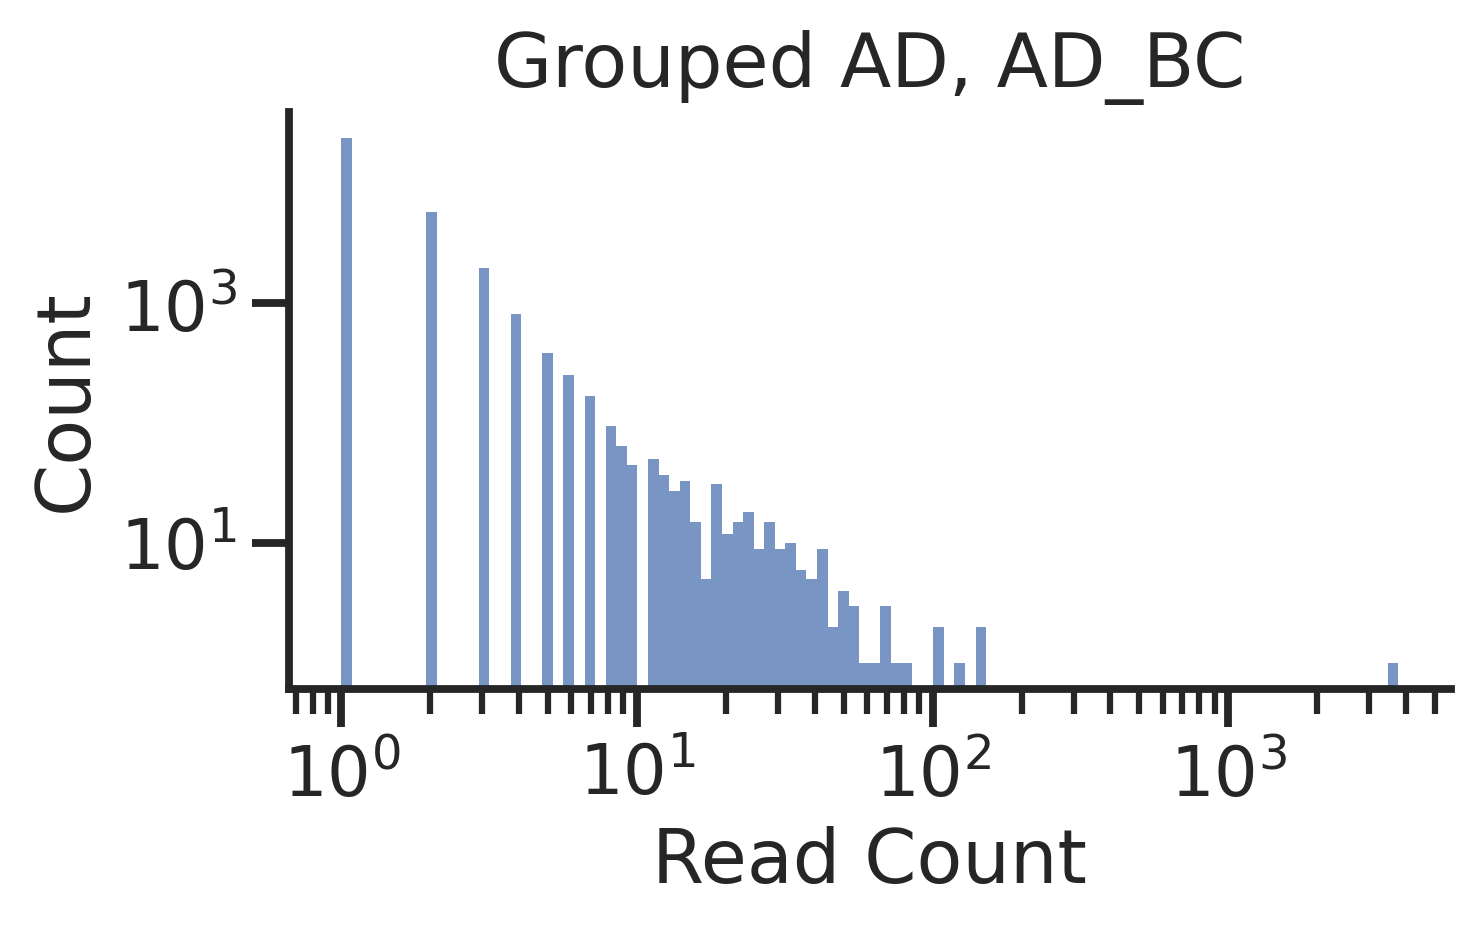

Done in 2.77 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_AD_2_10_MVS_0004_TTAGGTTGTC_CGGTTGAAGA_S12_AD_AD_BC_loss_summary'
Done in 0.06 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.68 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.41 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.37 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.28 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAACTC_S26_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAACTC_S26_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAACTC_S26_AD_AD_BC_initial...


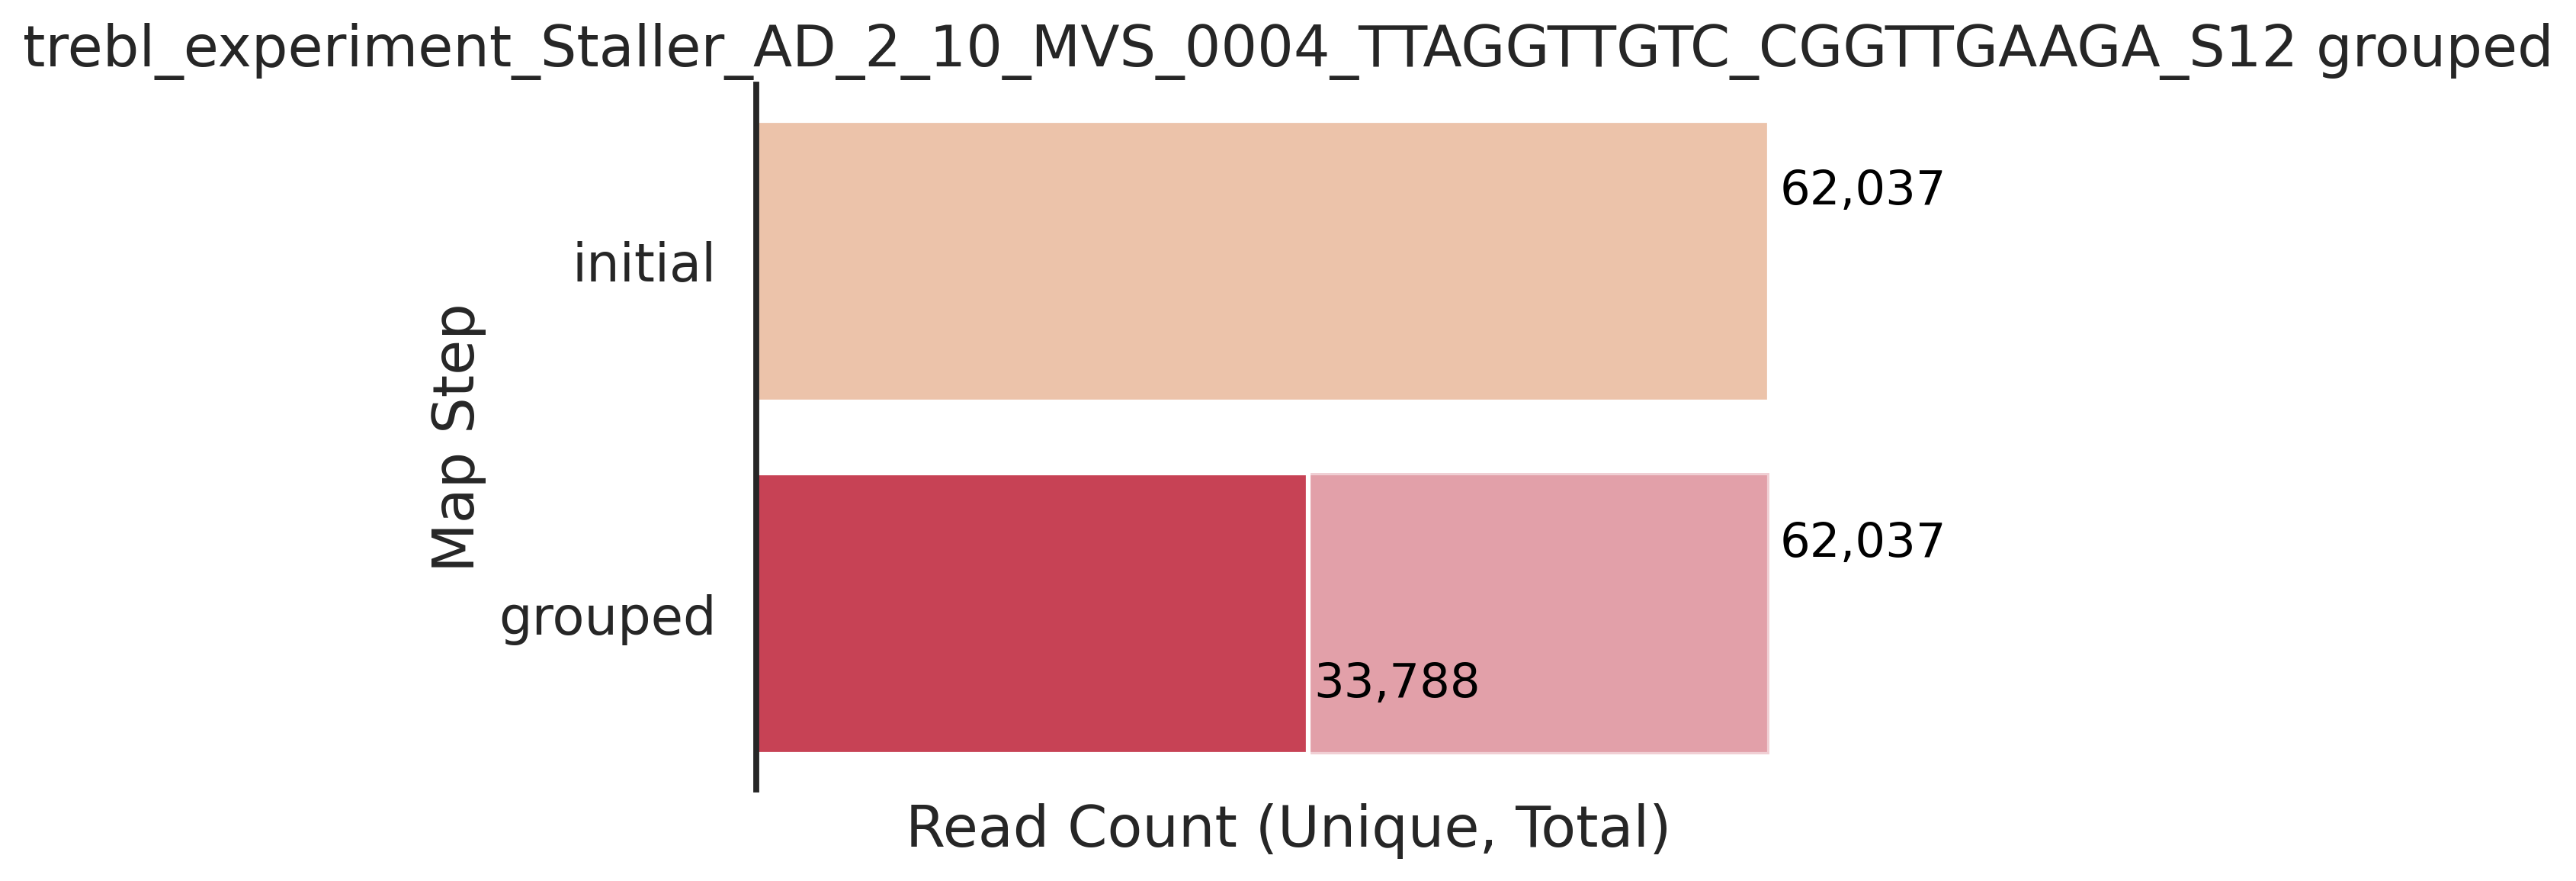

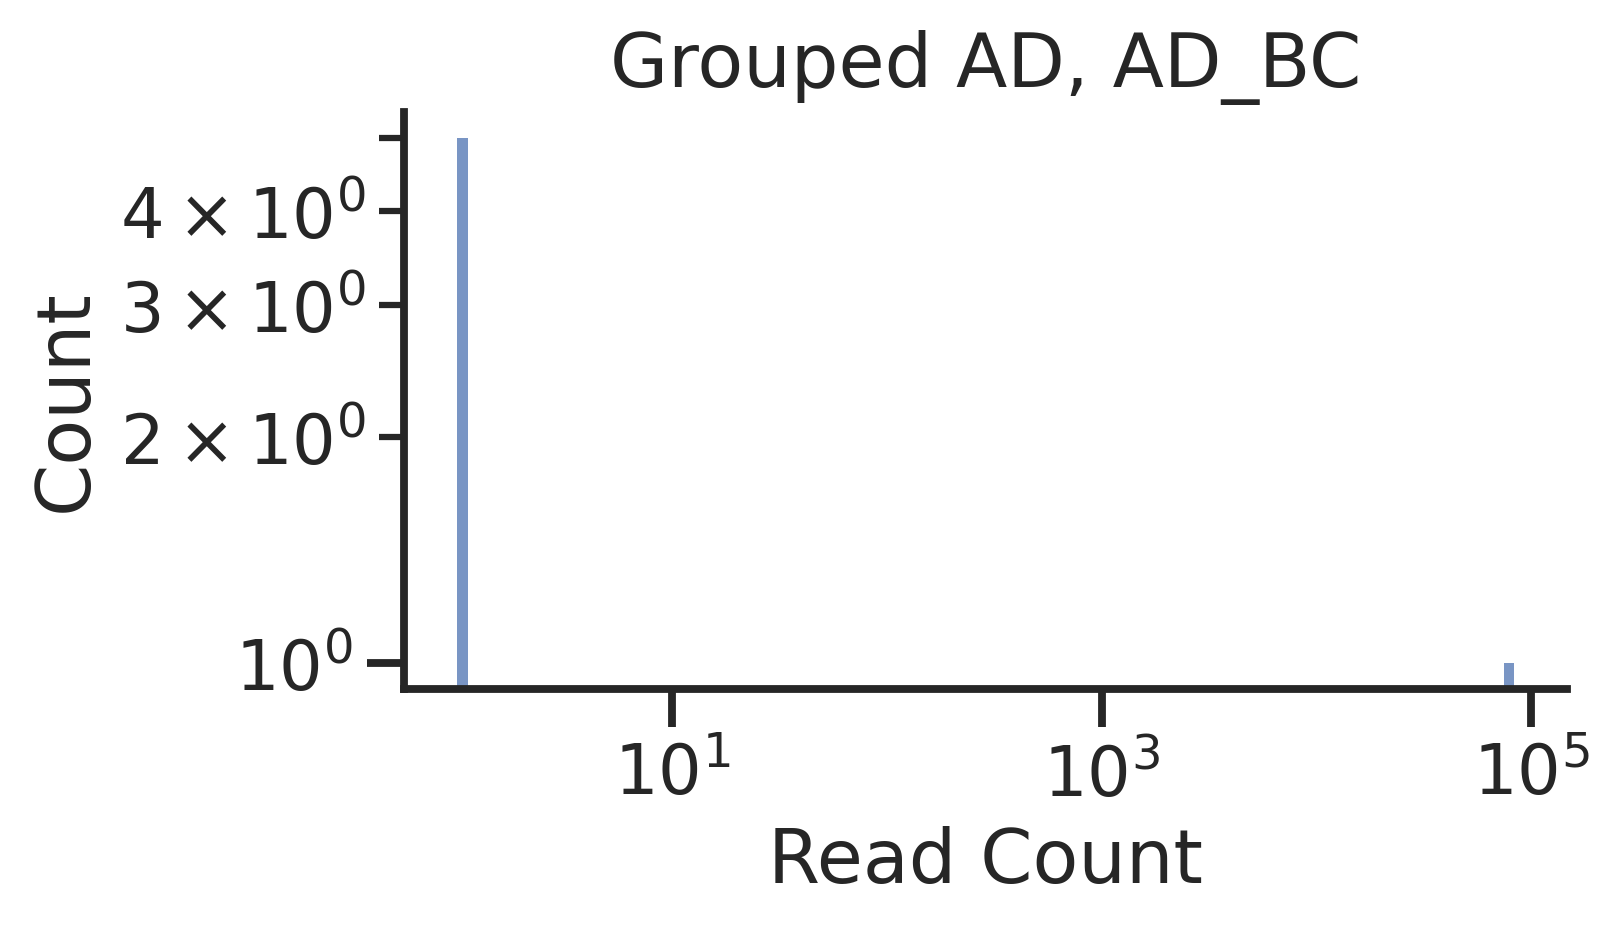

Done in 2.81 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_40_MVS_0040_I1_TATGAGACGA_ACTGTAACTC_S26_AD_AD_BC_loss_summary'
Done in 0.04 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.20 seconds.

Reverse complement of sequences...
Done in 0.42 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.09 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.13 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGACC_S20_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGACC_S20_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGACC_S20_AD_AD_BC_initial...


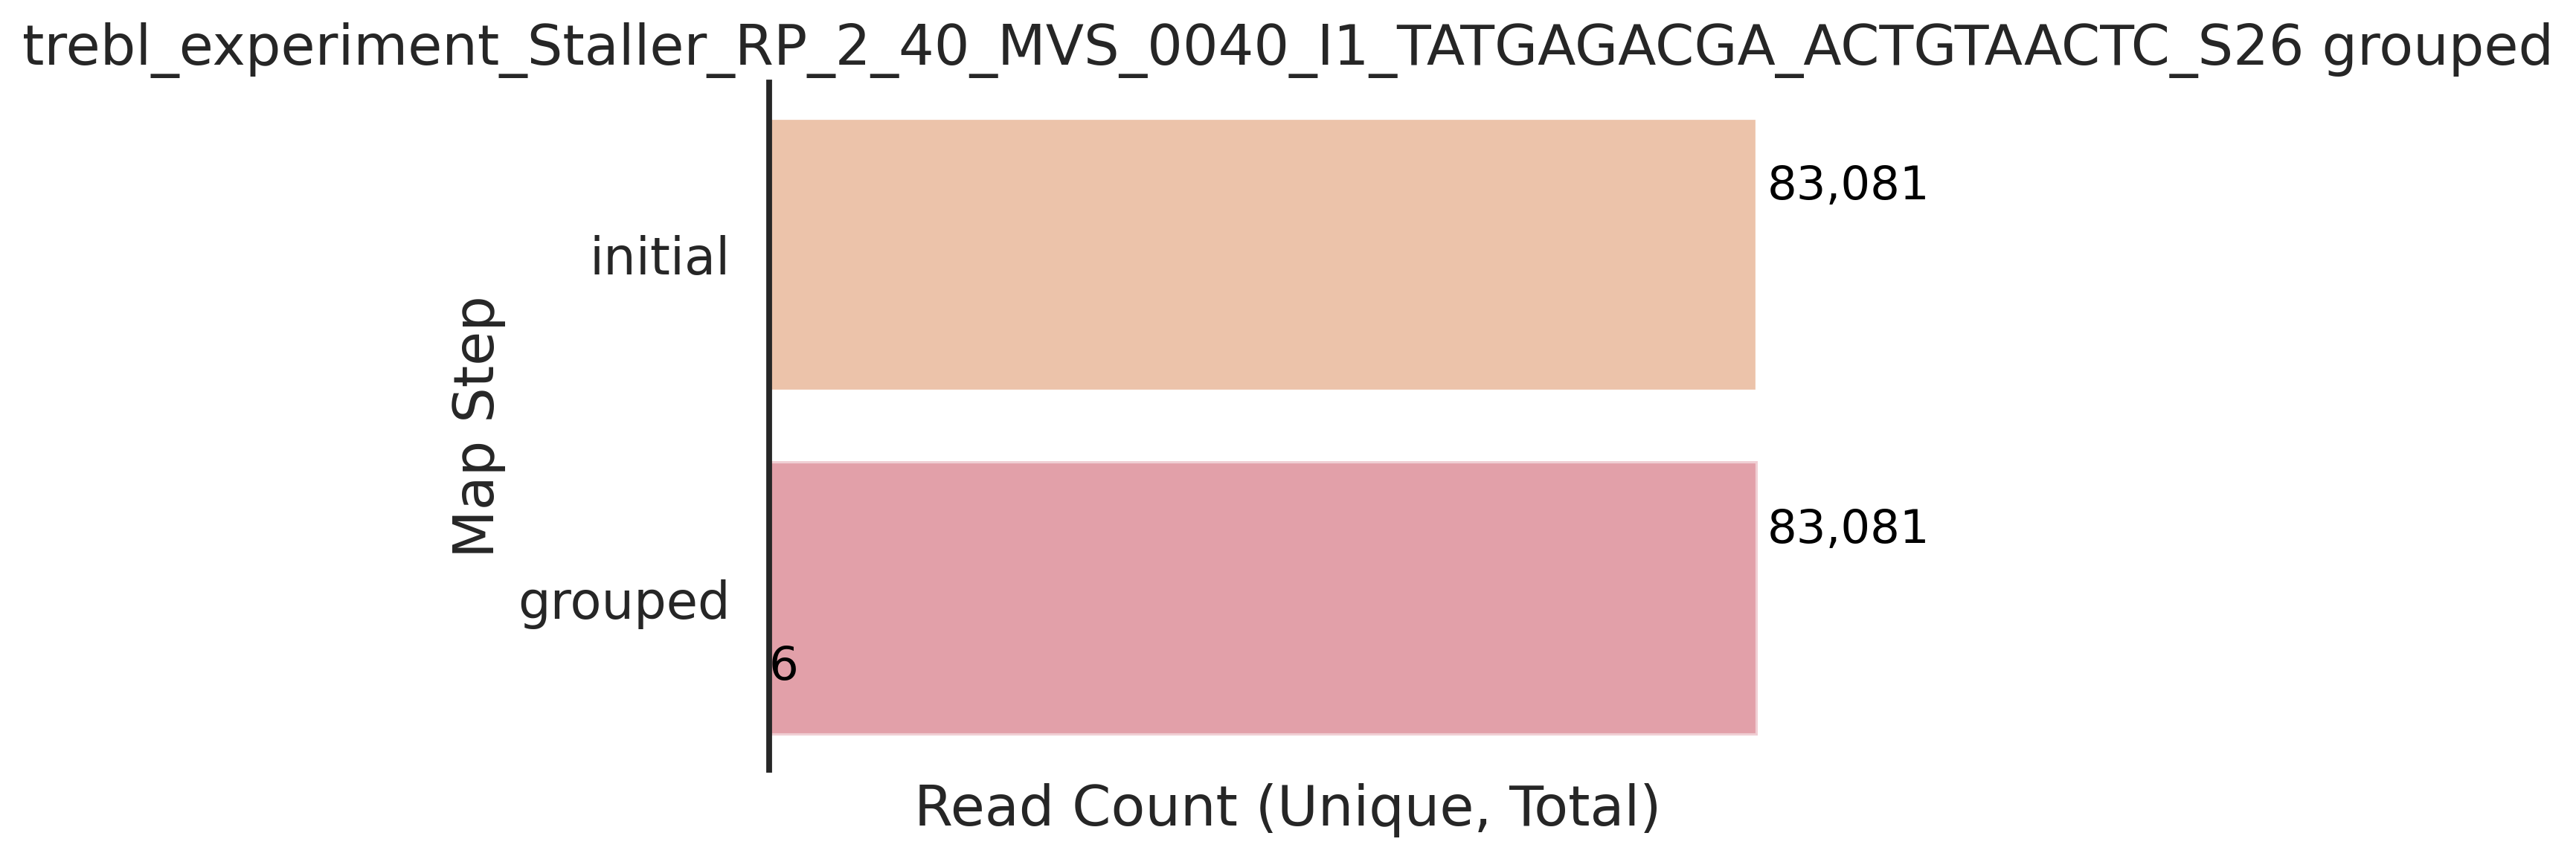

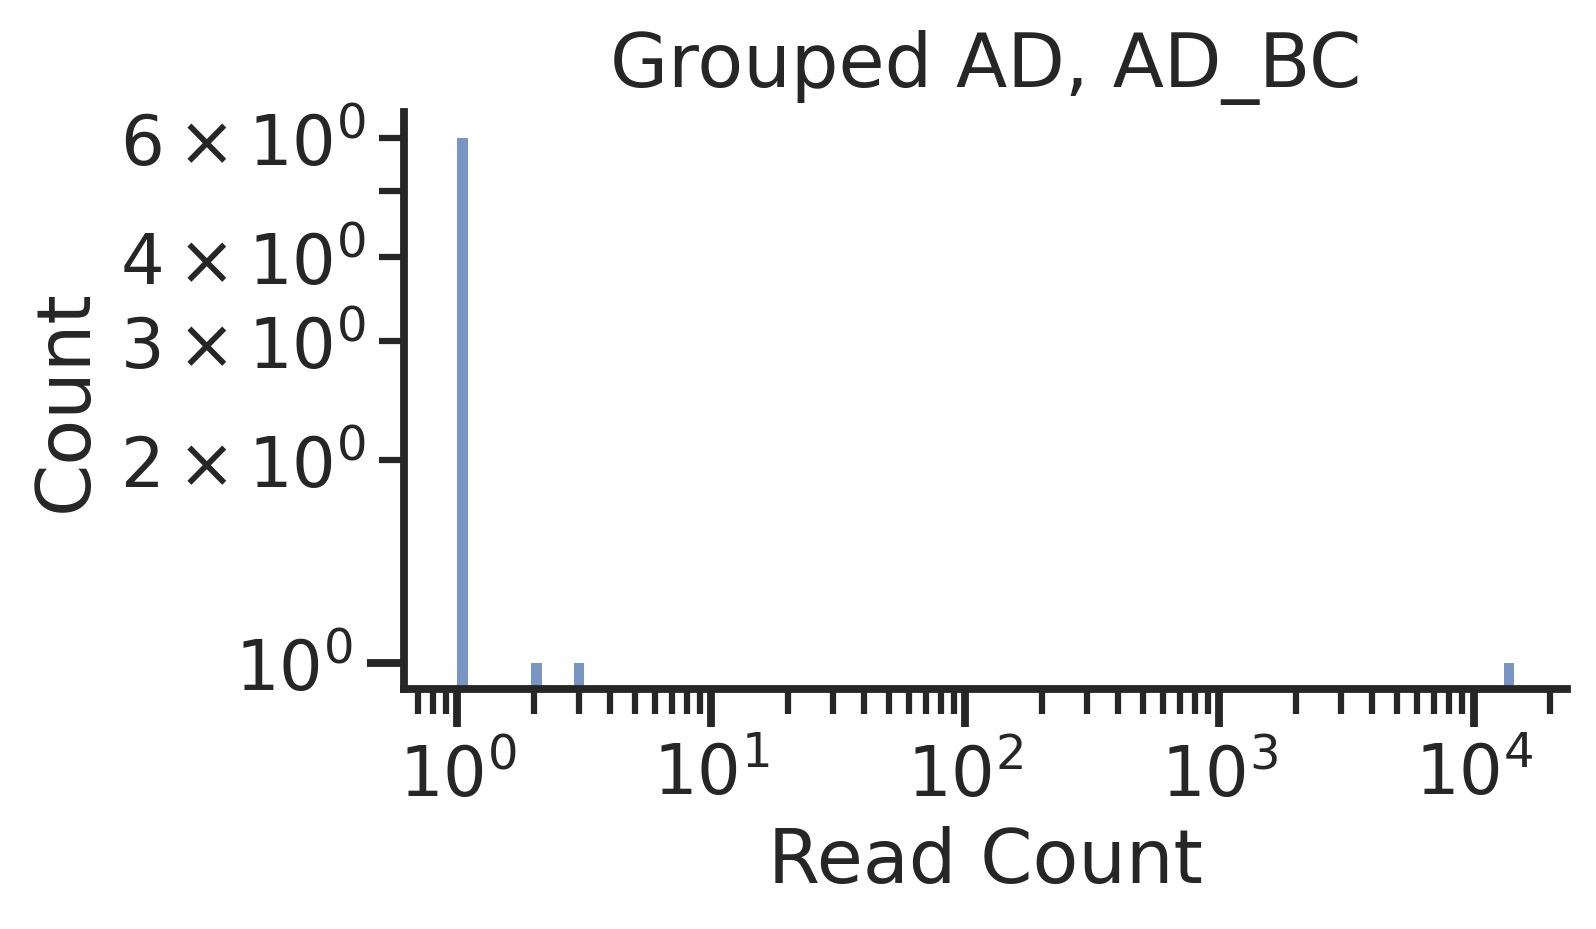

Done in 3.54 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_2_MVS_0034_I1_TTACGGTGAG_AAGTATGACC_S20_AD_AD_BC_loss_summary'
Done in 0.04 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.53 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.22 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.36 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.28 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAGCTT_S25_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAGCTT_S25_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAGCTT_S25_AD_AD_BC_initial...


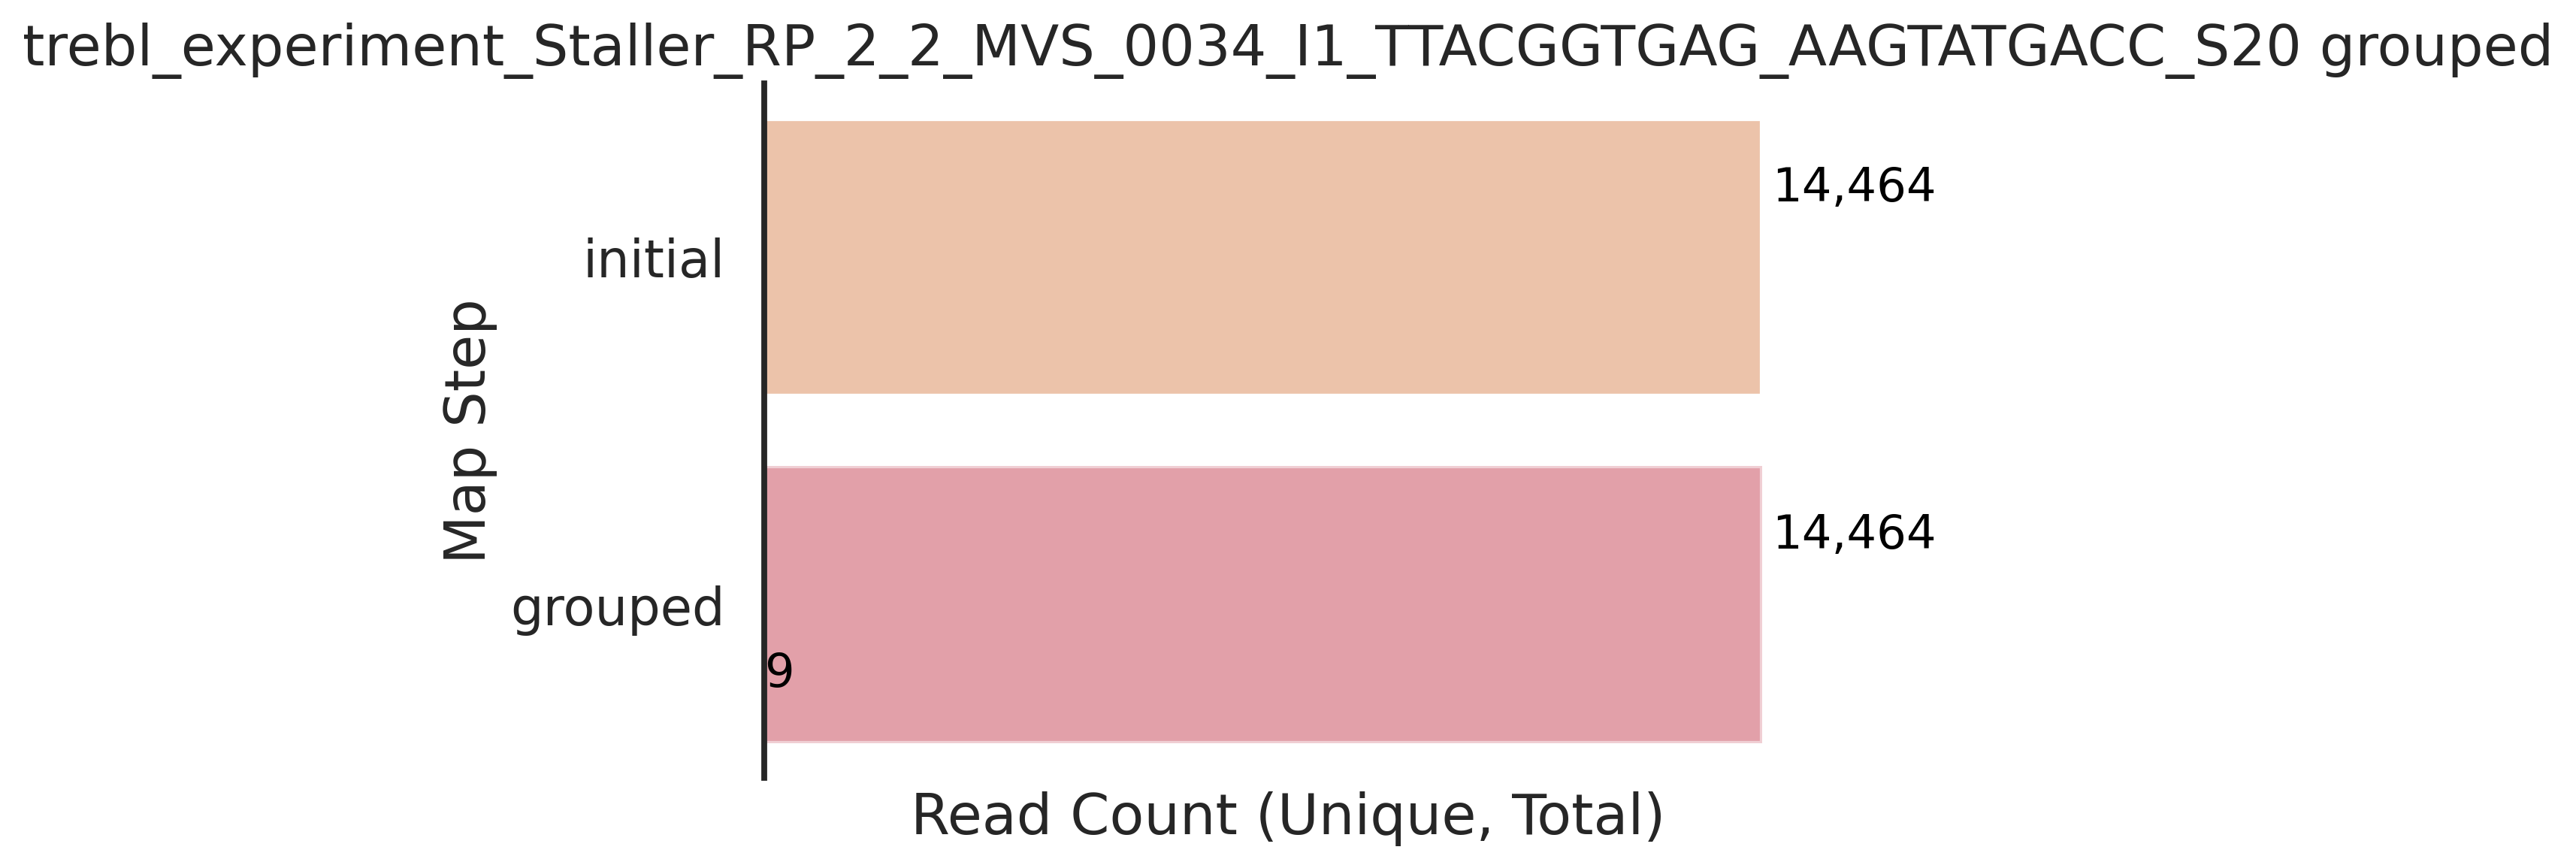

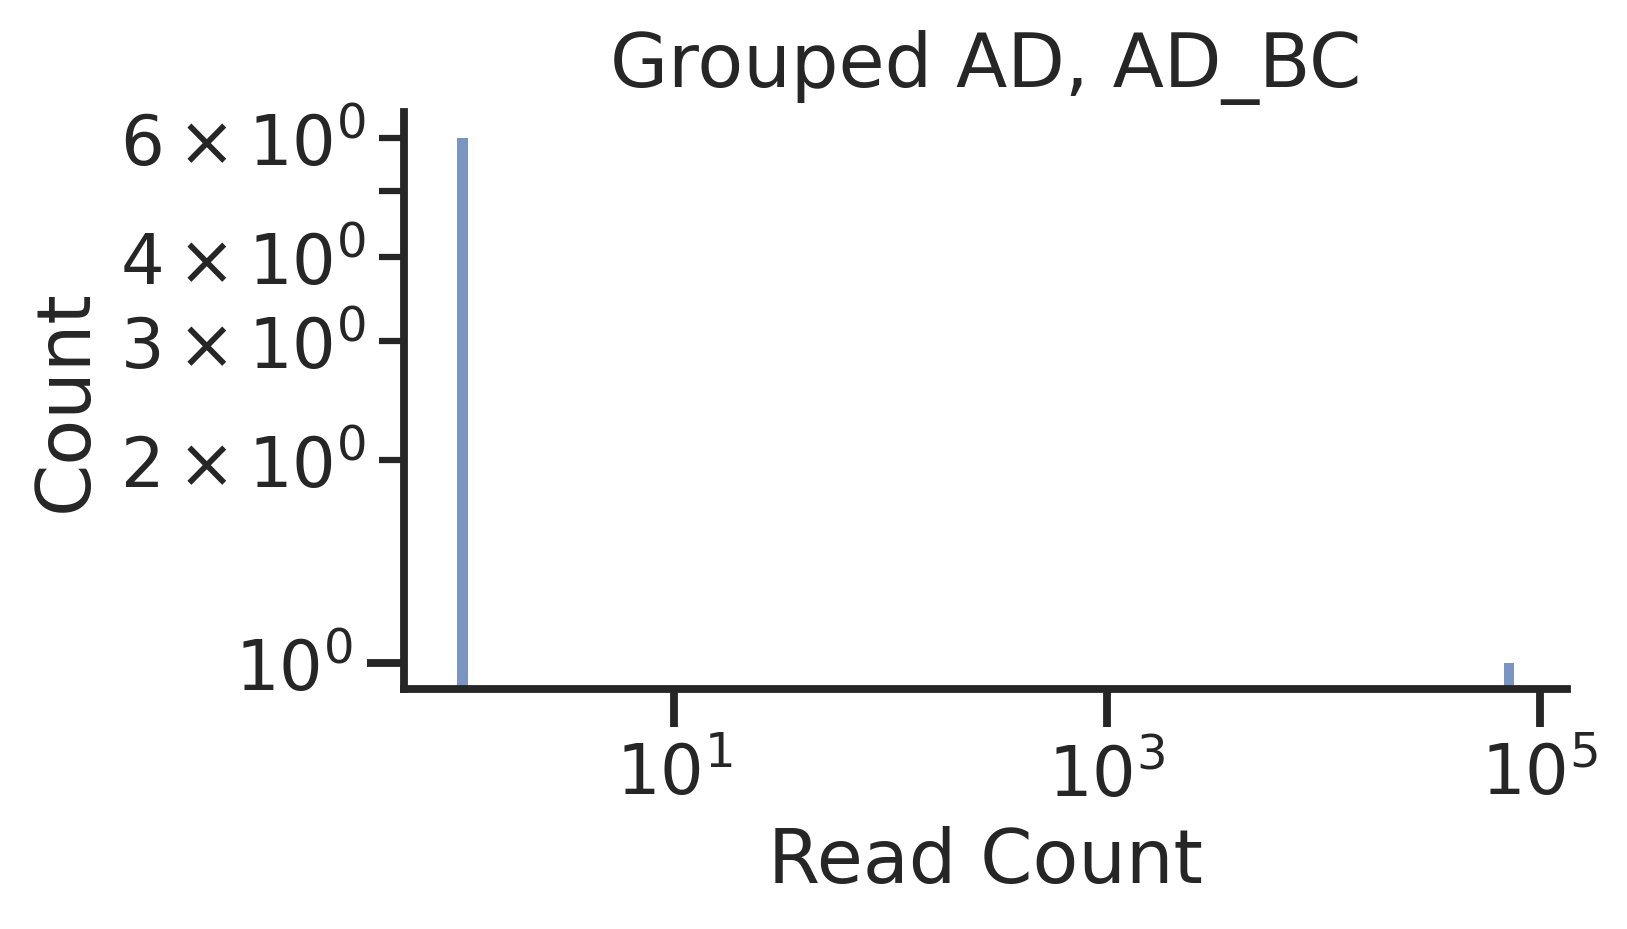

Done in 2.90 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_30_MVS_0039_I1_AACCTGTCGT_GCTGCAGCTT_S25_AD_AD_BC_loss_summary'
Done in 0.04 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.47 seconds.

Reverse complement of sequences...
Done in 1.71 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.27 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.25 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCATACT_S24_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCATACT_S24_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCATACT_S24_AD_AD_BC_initial...


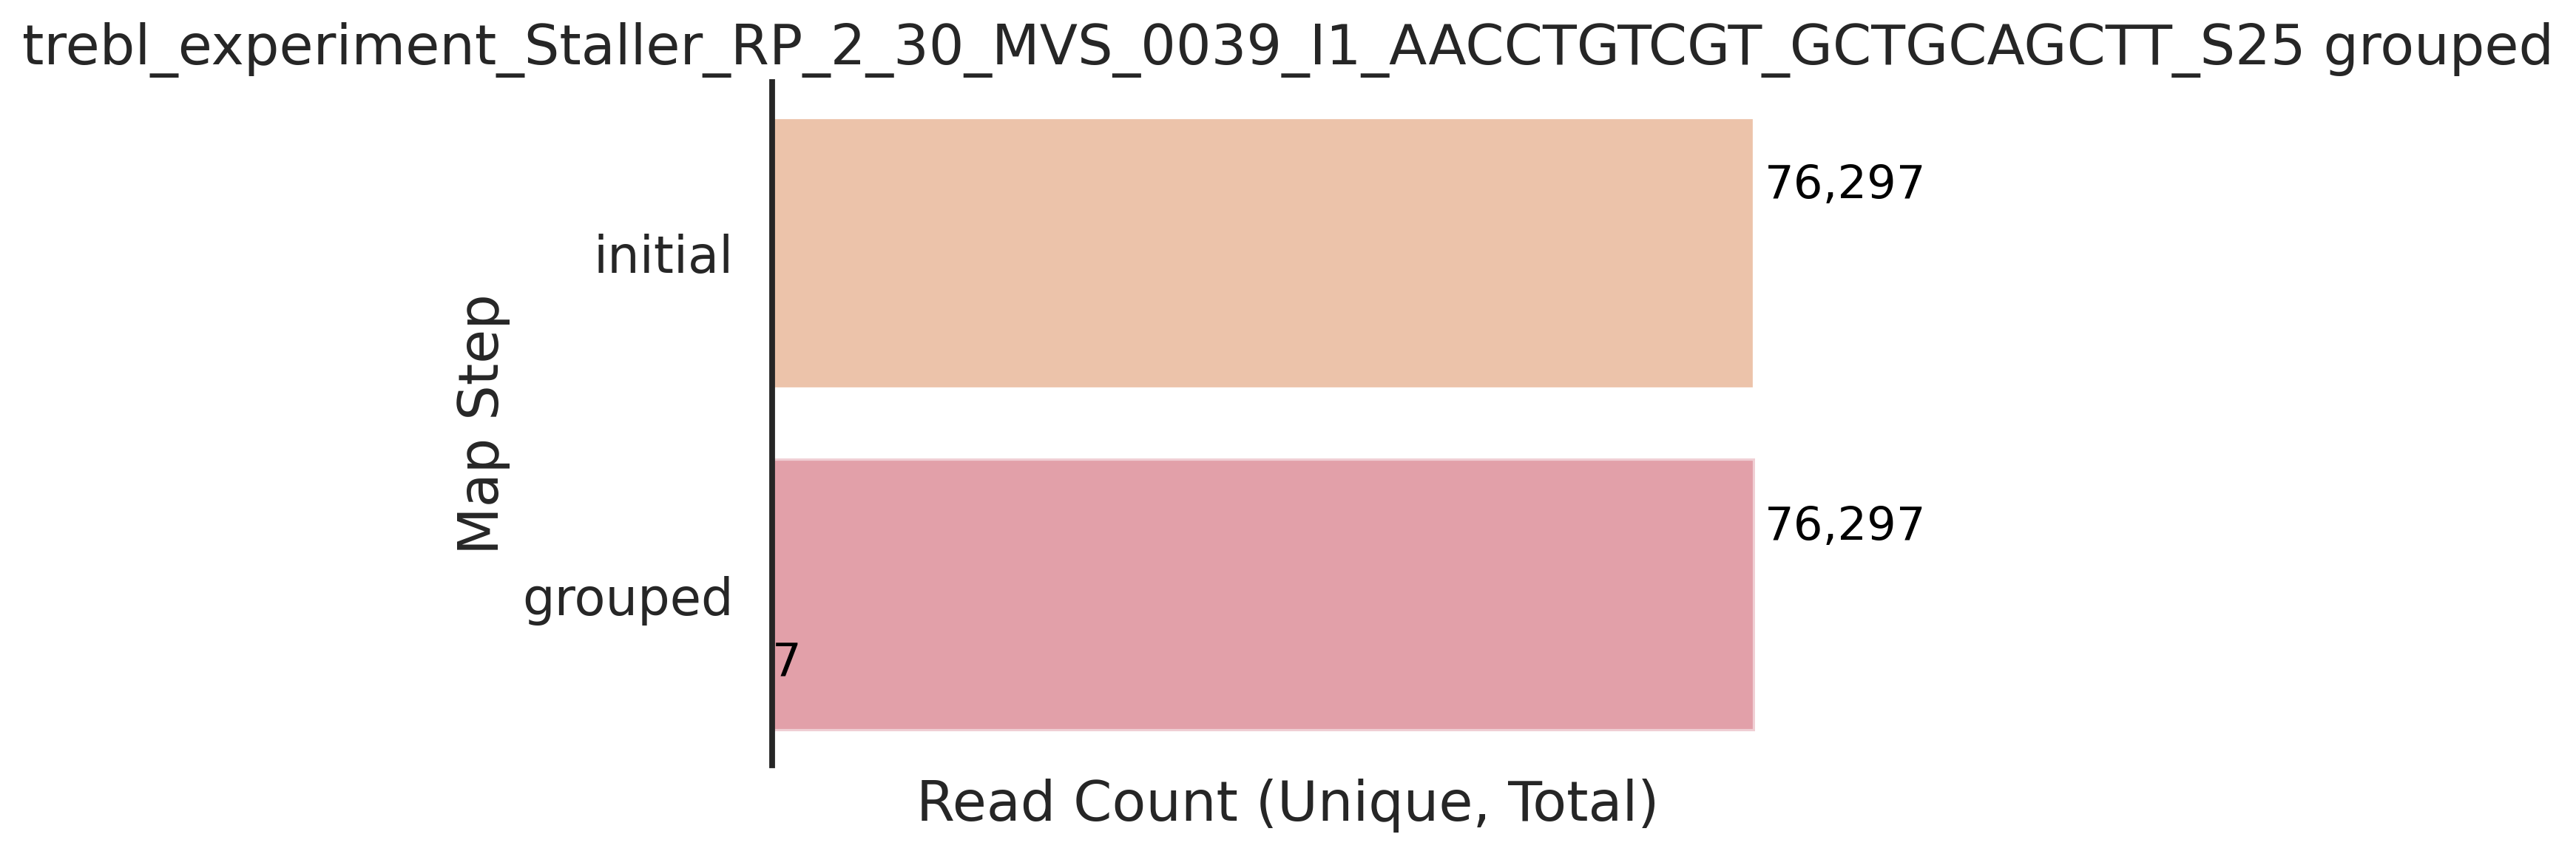

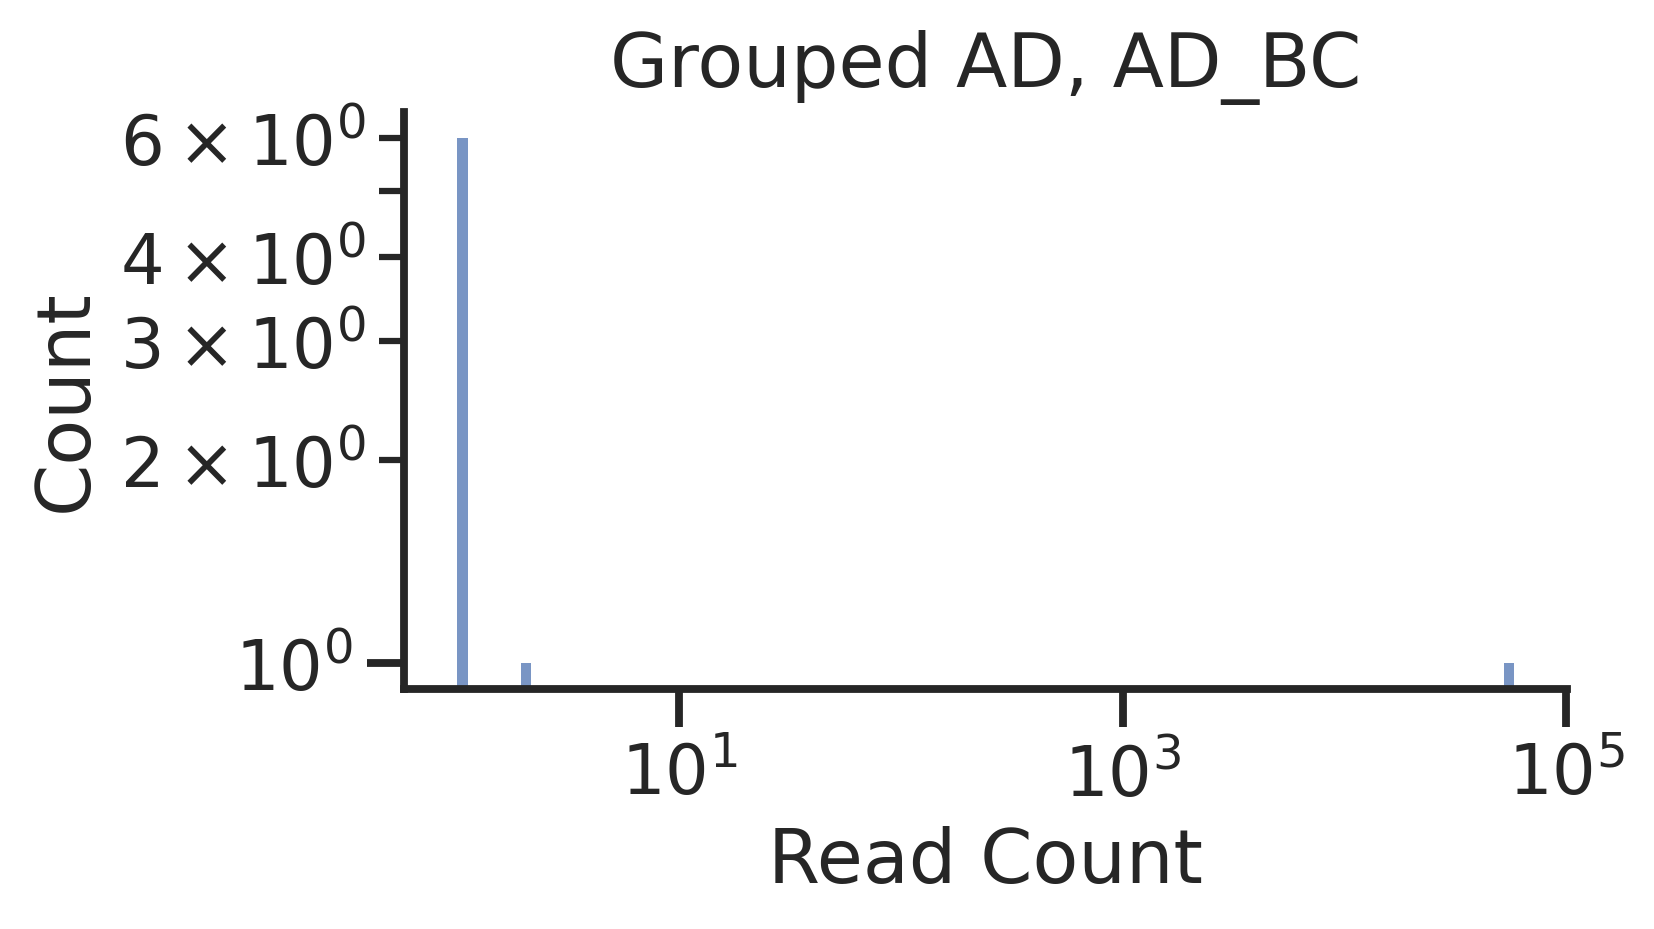

Done in 2.76 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_20_MVS_0038_I1_CTGTACTAAG_CTGCCATACT_S24_AD_AD_BC_loss_summary'
Done in 0.04 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.84 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.91 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.44 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.33 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCCAAT_S28_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCCAAT_S28_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCCAAT_S28_AD_AD_BC_initial...


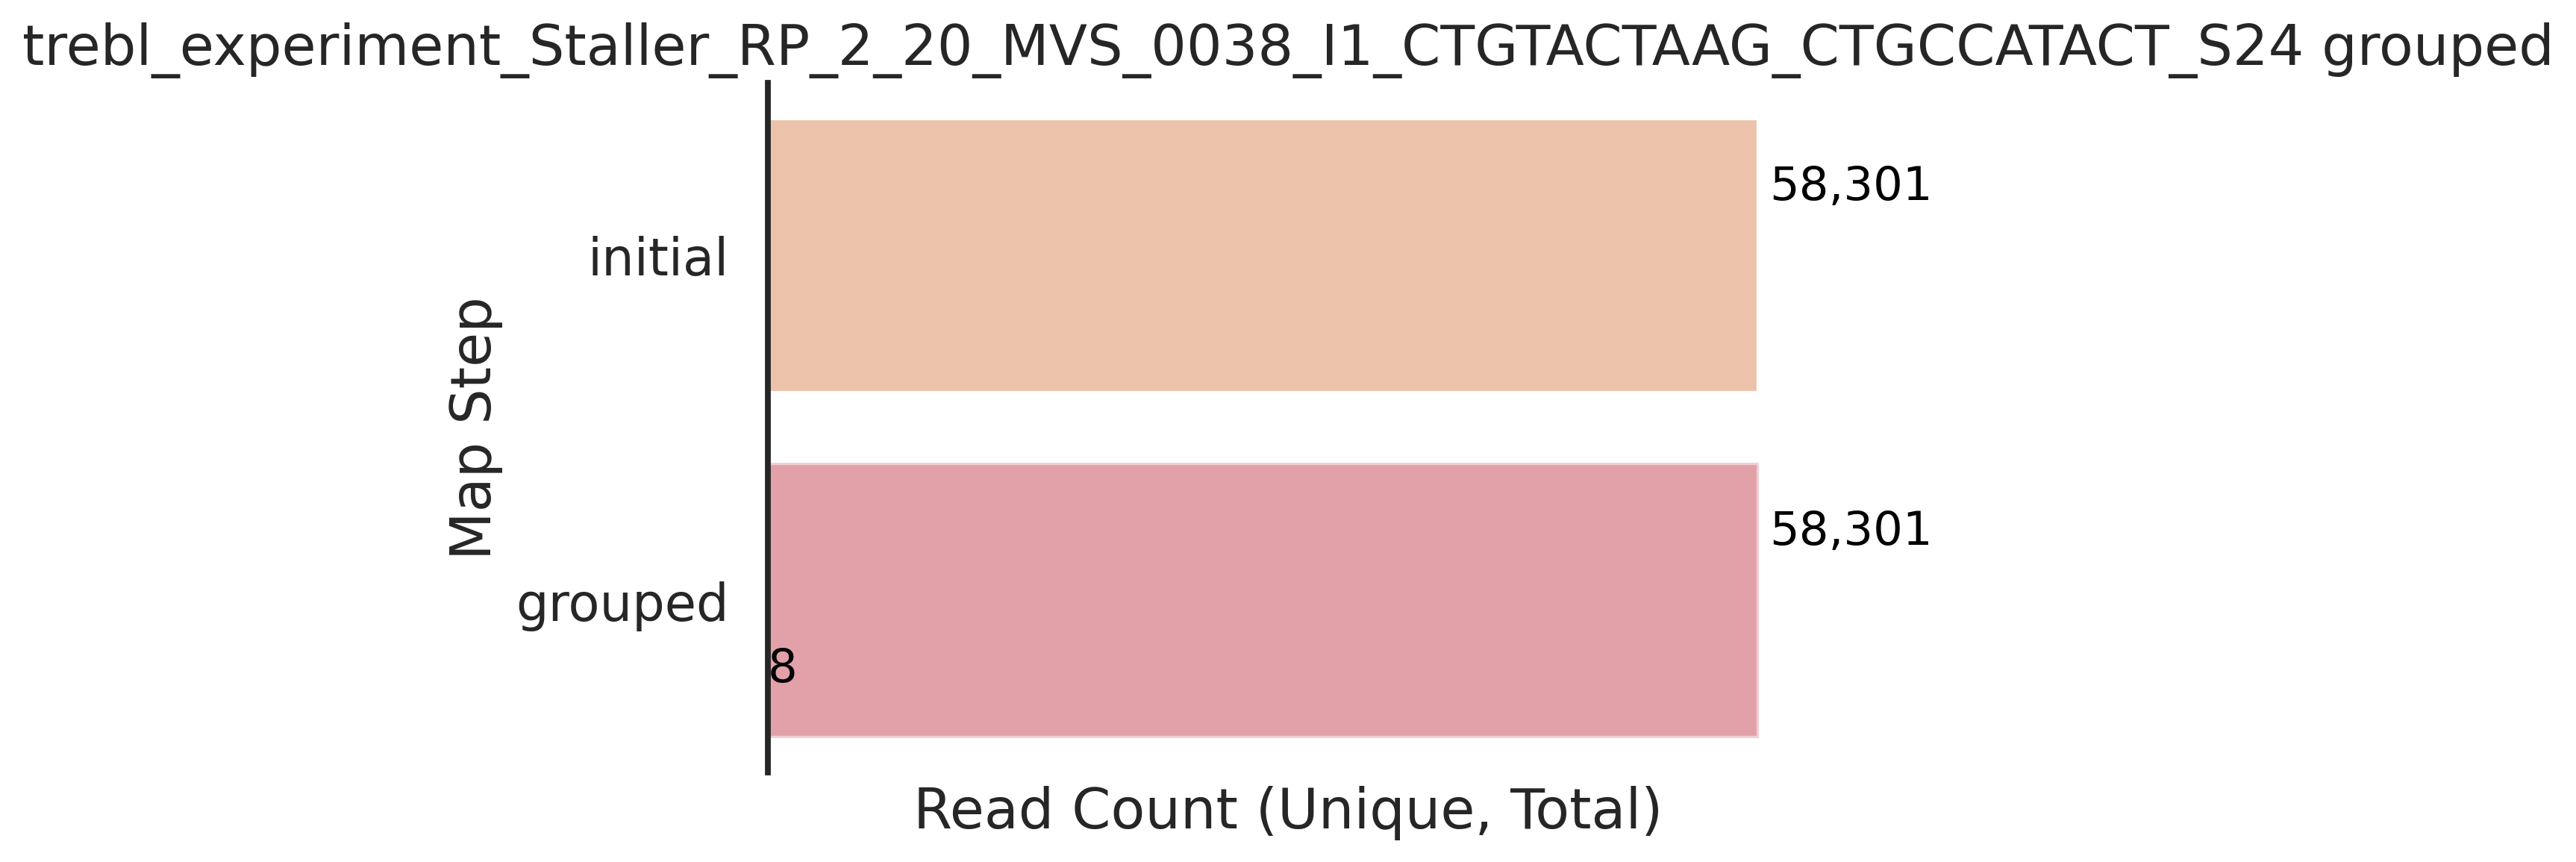

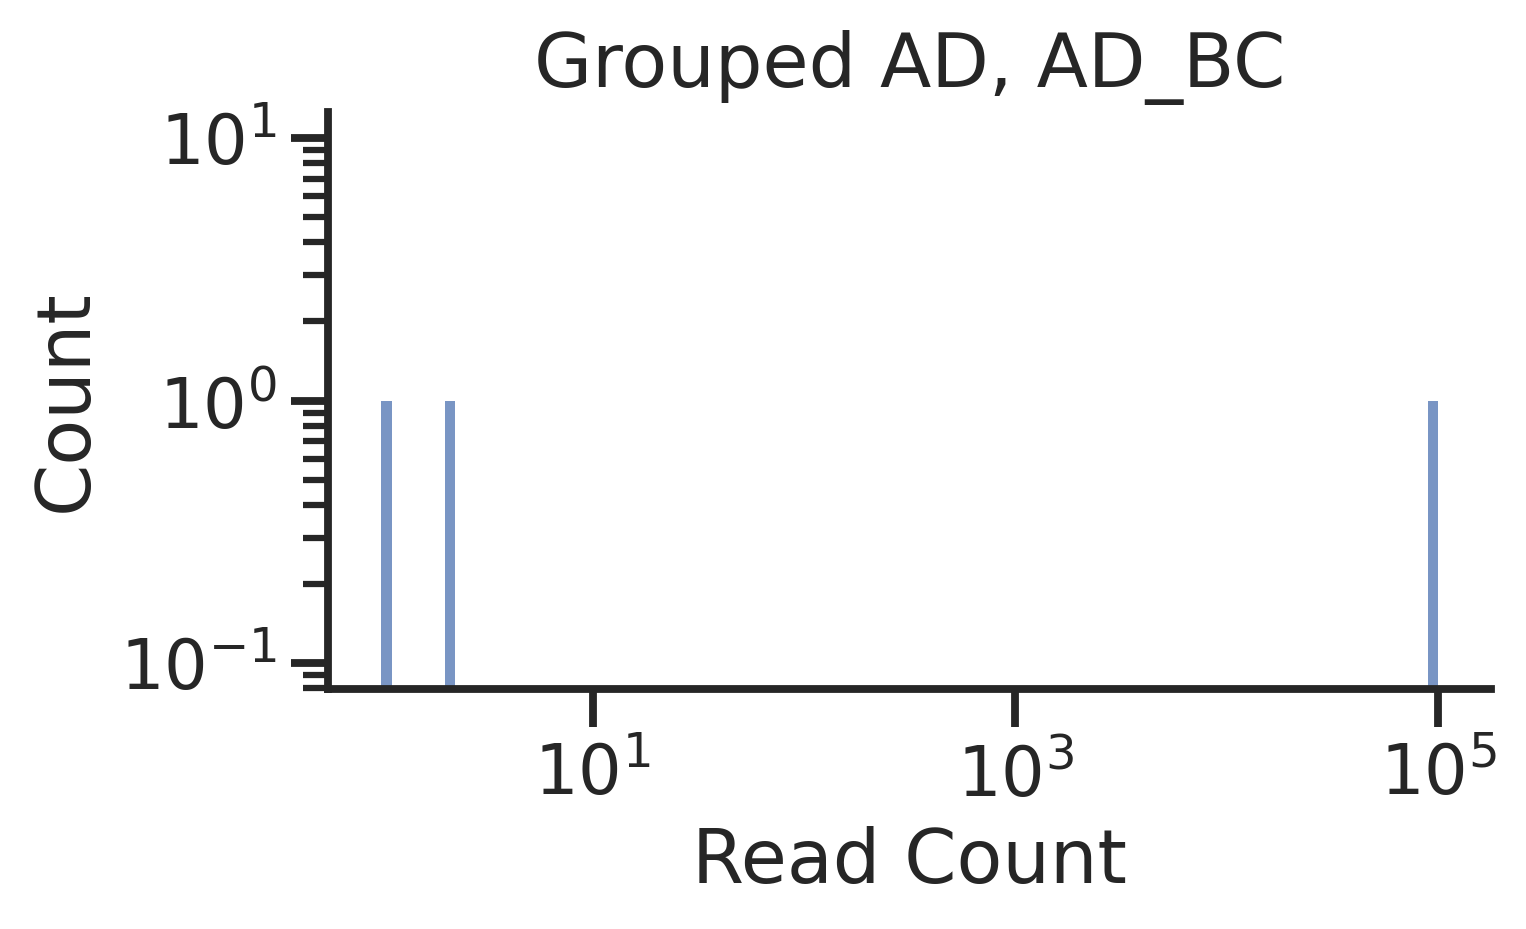

Done in 2.79 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_60_MVS_0058_I1_AGGCGTCCTT_ACTGTCCAAT_S28_AD_AD_BC_loss_summary'
Done in 0.04 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.43 seconds.

Reverse complement of sequences...
Done in 1.29 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.21 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.21 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGATCTA_S23_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGATCTA_S23_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGATCTA_S23_AD_AD_BC_initial...


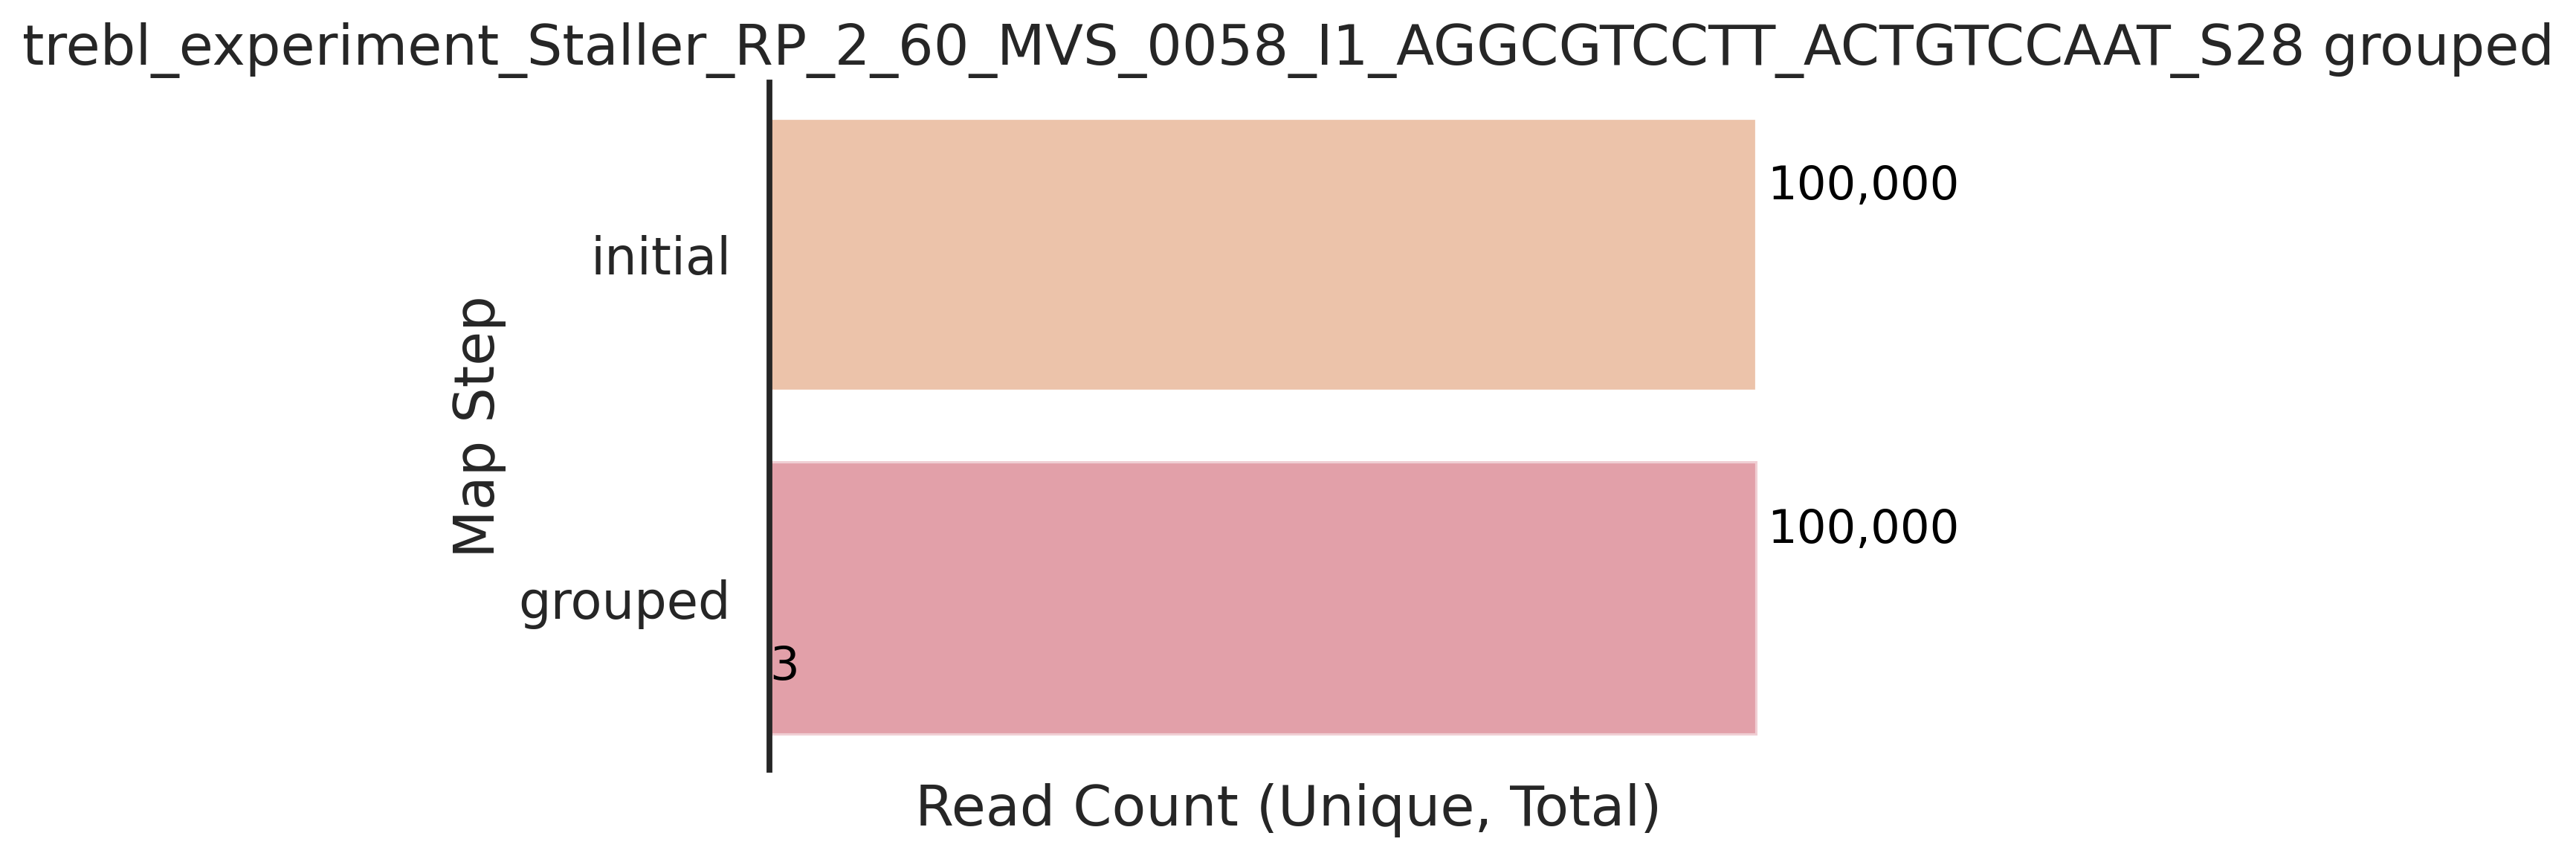

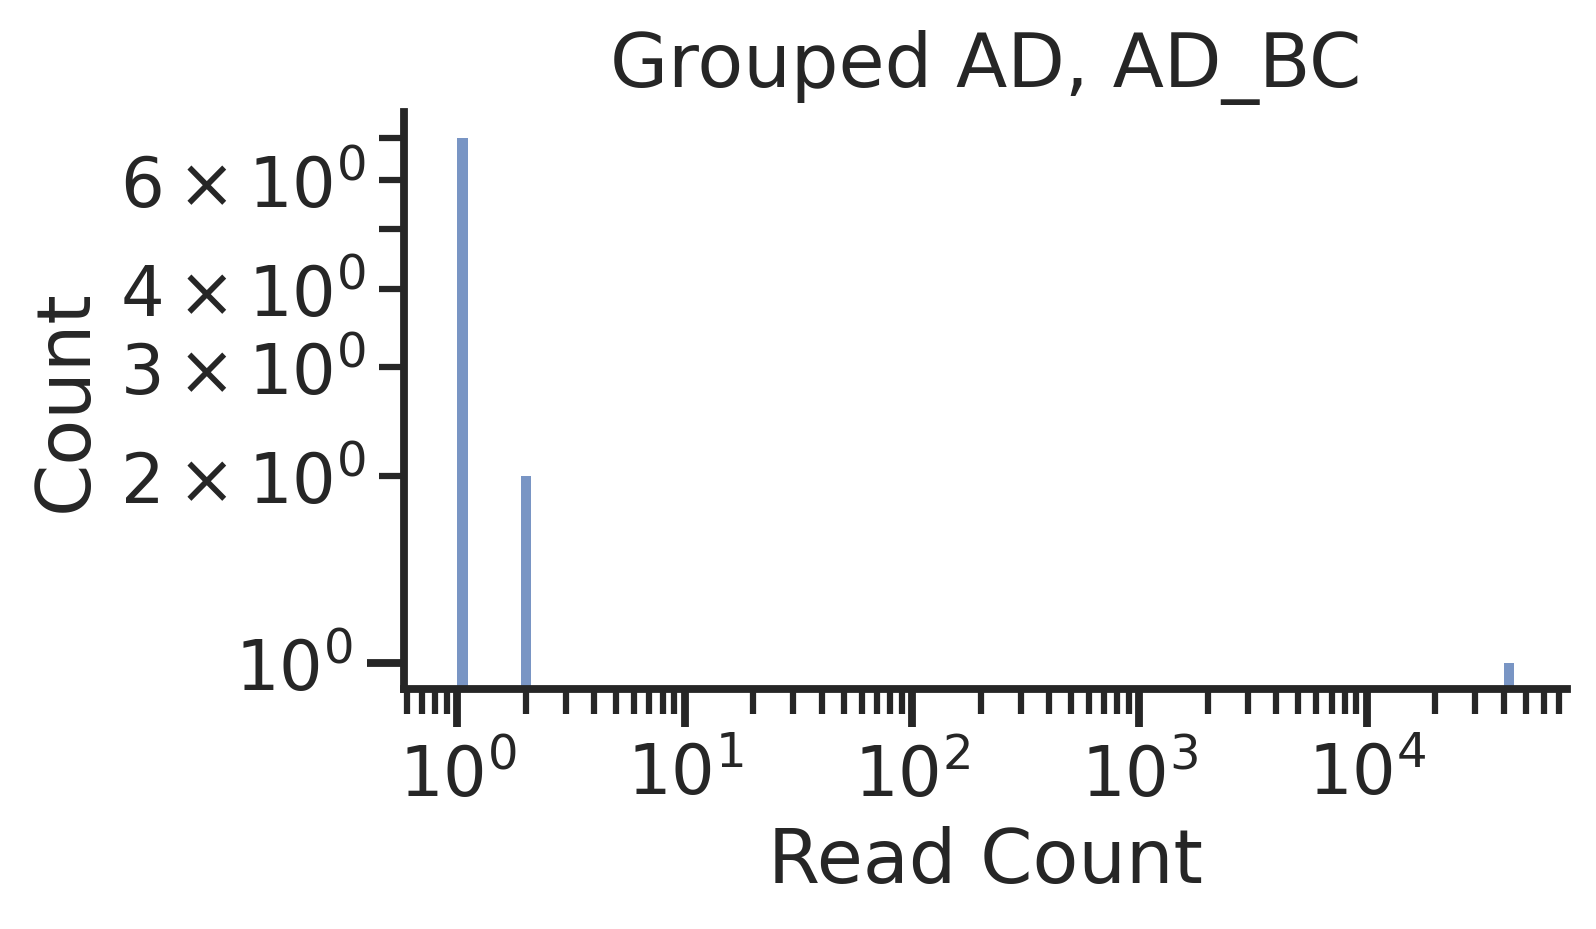

Done in 3.40 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_15_MVS_0037_I1_ATCAGTGGTC_CTAGGATCTA_S23_AD_AD_BC_loss_summary'
Done in 0.04 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.26 seconds.

Reverse complement of sequences...
Done in 0.18 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.05 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.10 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_0_MVS_0033_I1_AAGAGGCTAA_CGATAAGGCG_S19_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_0_MVS_0033_I1_AAGAGGCTAA_CGATAAGGCG_S19_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_0_MVS_0033_I1_AAGAGGCTAA_CGATAAGGCG_S19_AD_AD_BC_initial...


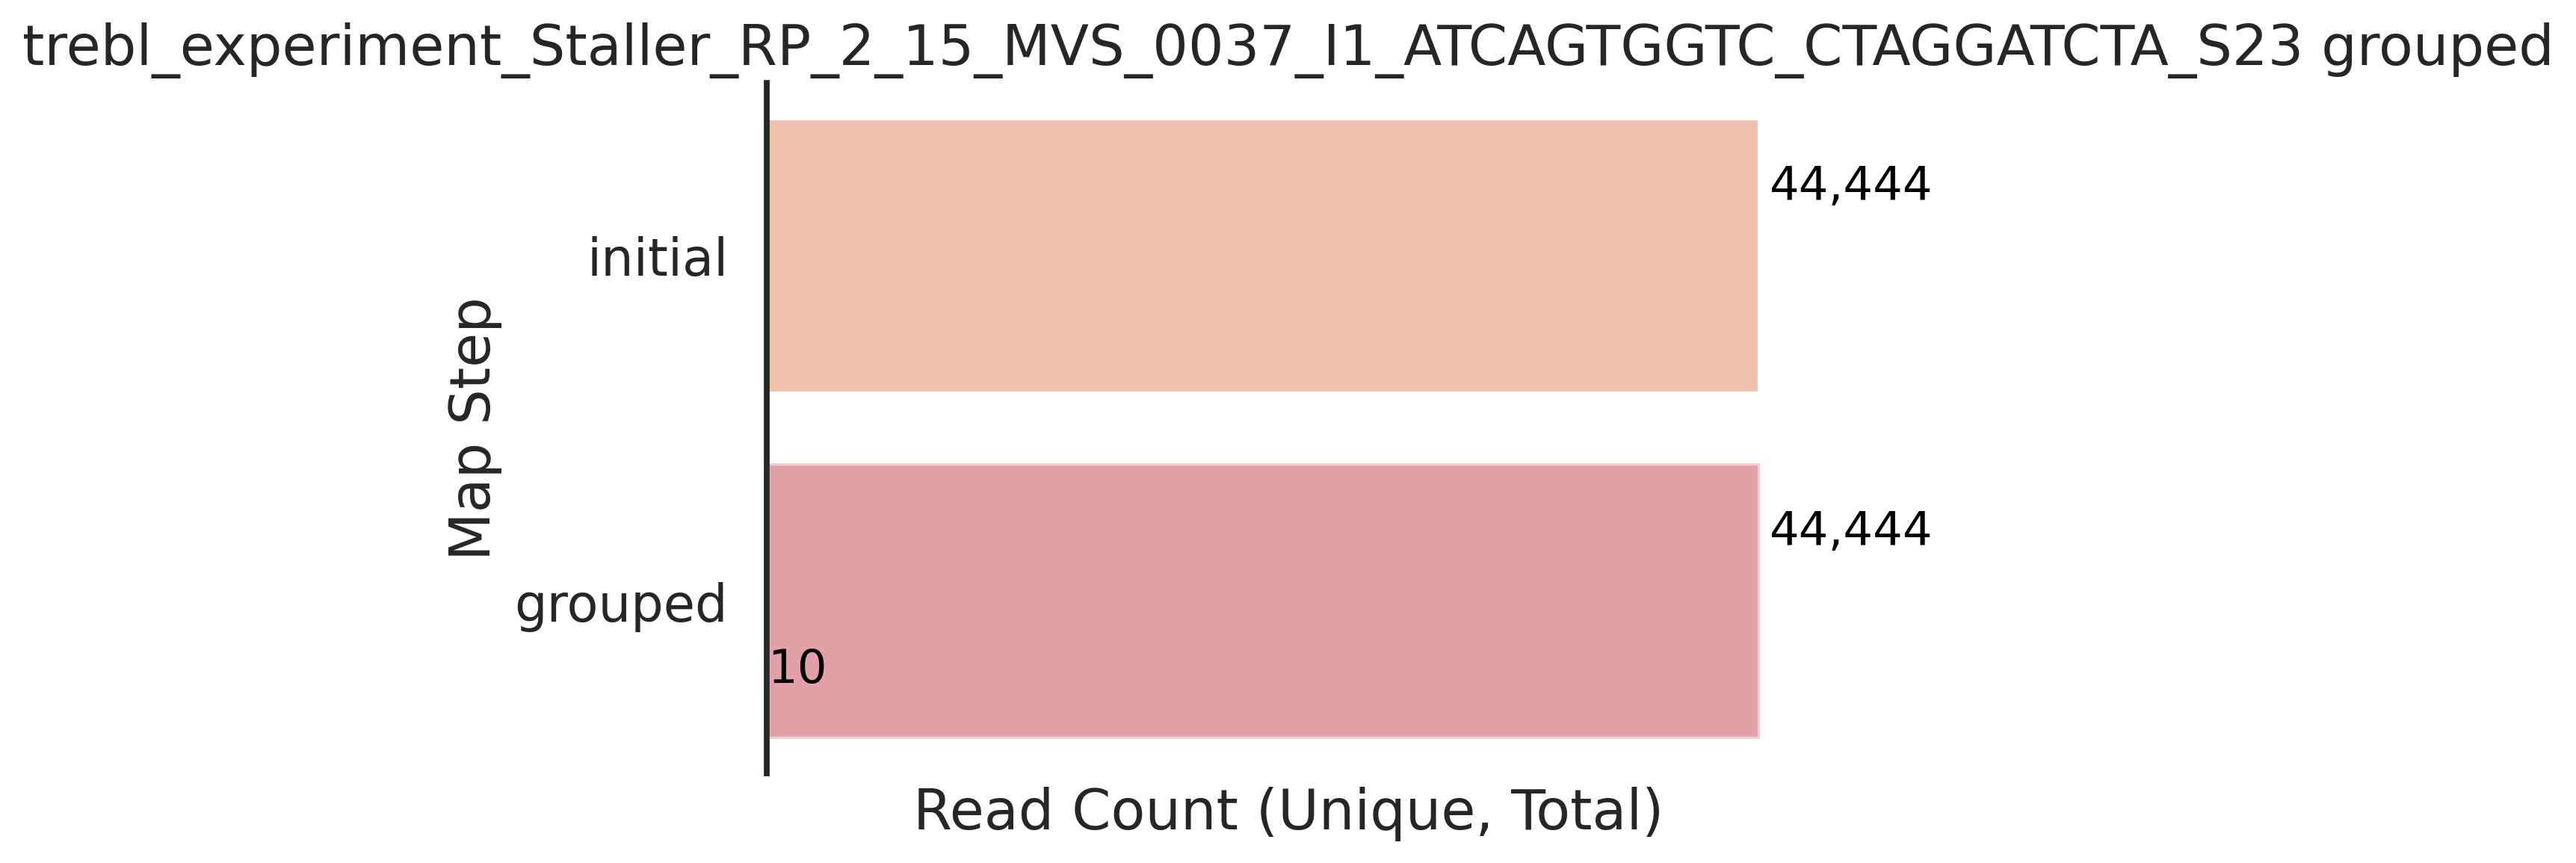

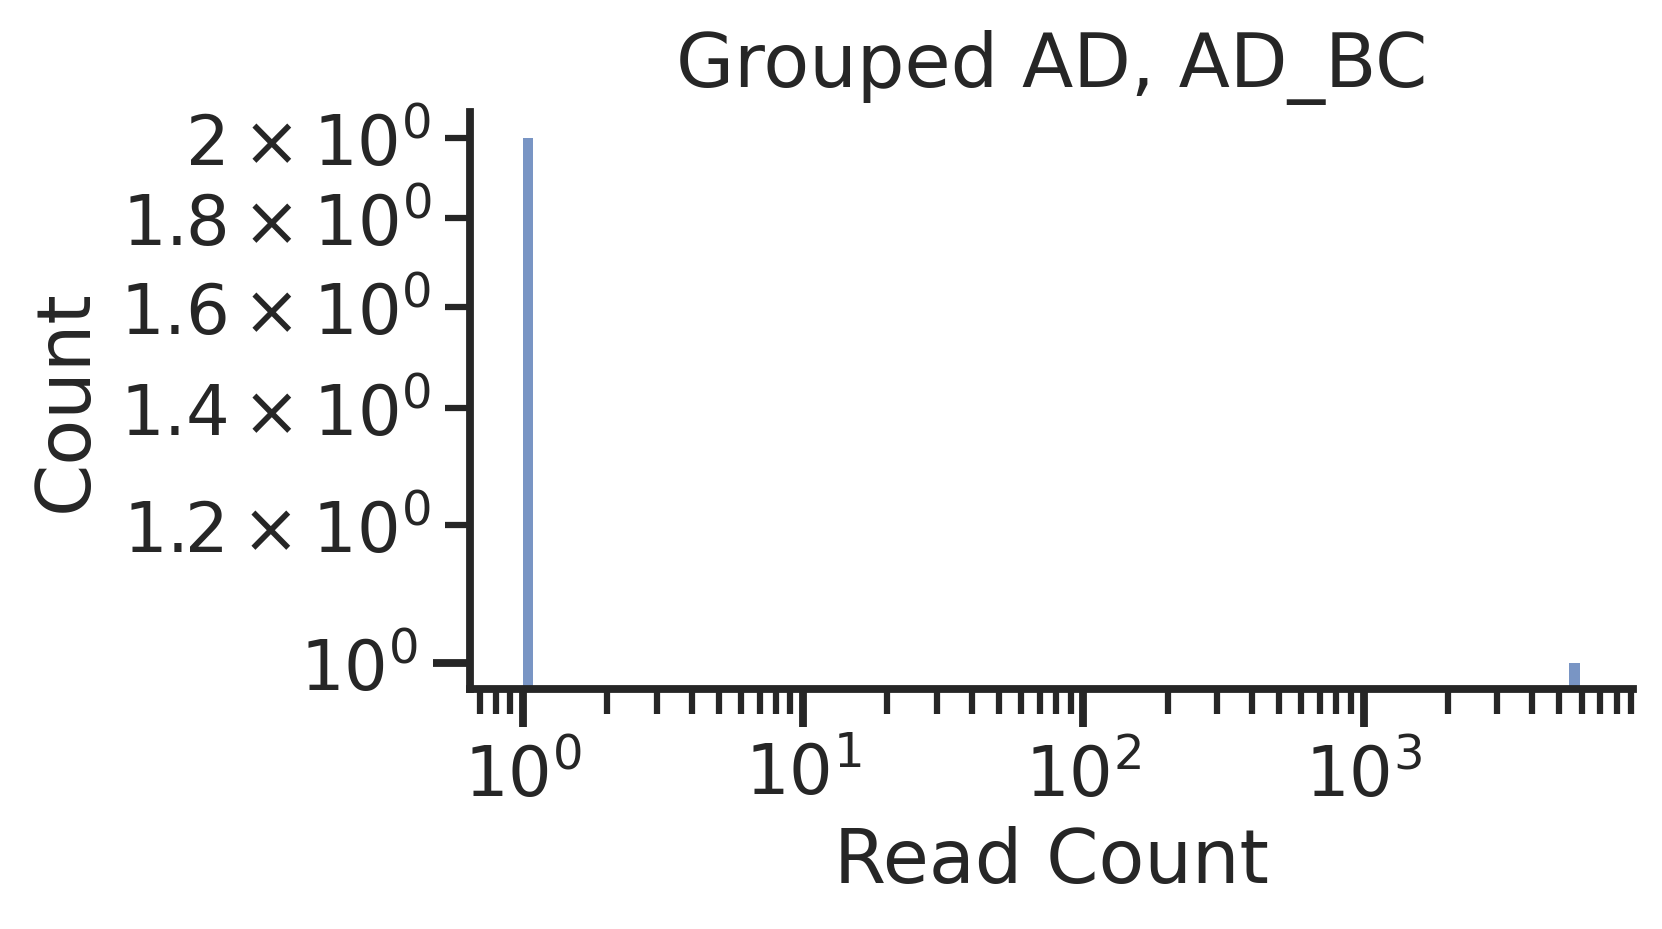

Done in 3.15 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_0_MVS_0033_I1_AAGAGGCTAA_CGATAAGGCG_S19_AD_AD_BC_loss_summary'
Done in 0.03 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.31 seconds.

Reverse complement of sequences...
Done in 1.04 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.18 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.19 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_10_MVS_0036_I1_AGCTTACCTT_CACTTAGCAC_S22_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_10_MVS_0036_I1_AGCTTACCTT_CACTTAGCAC_S22_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_10_MVS_0036_I1_AGCTTACCTT_CACTTAGCAC_S22_AD_AD_BC_initial...


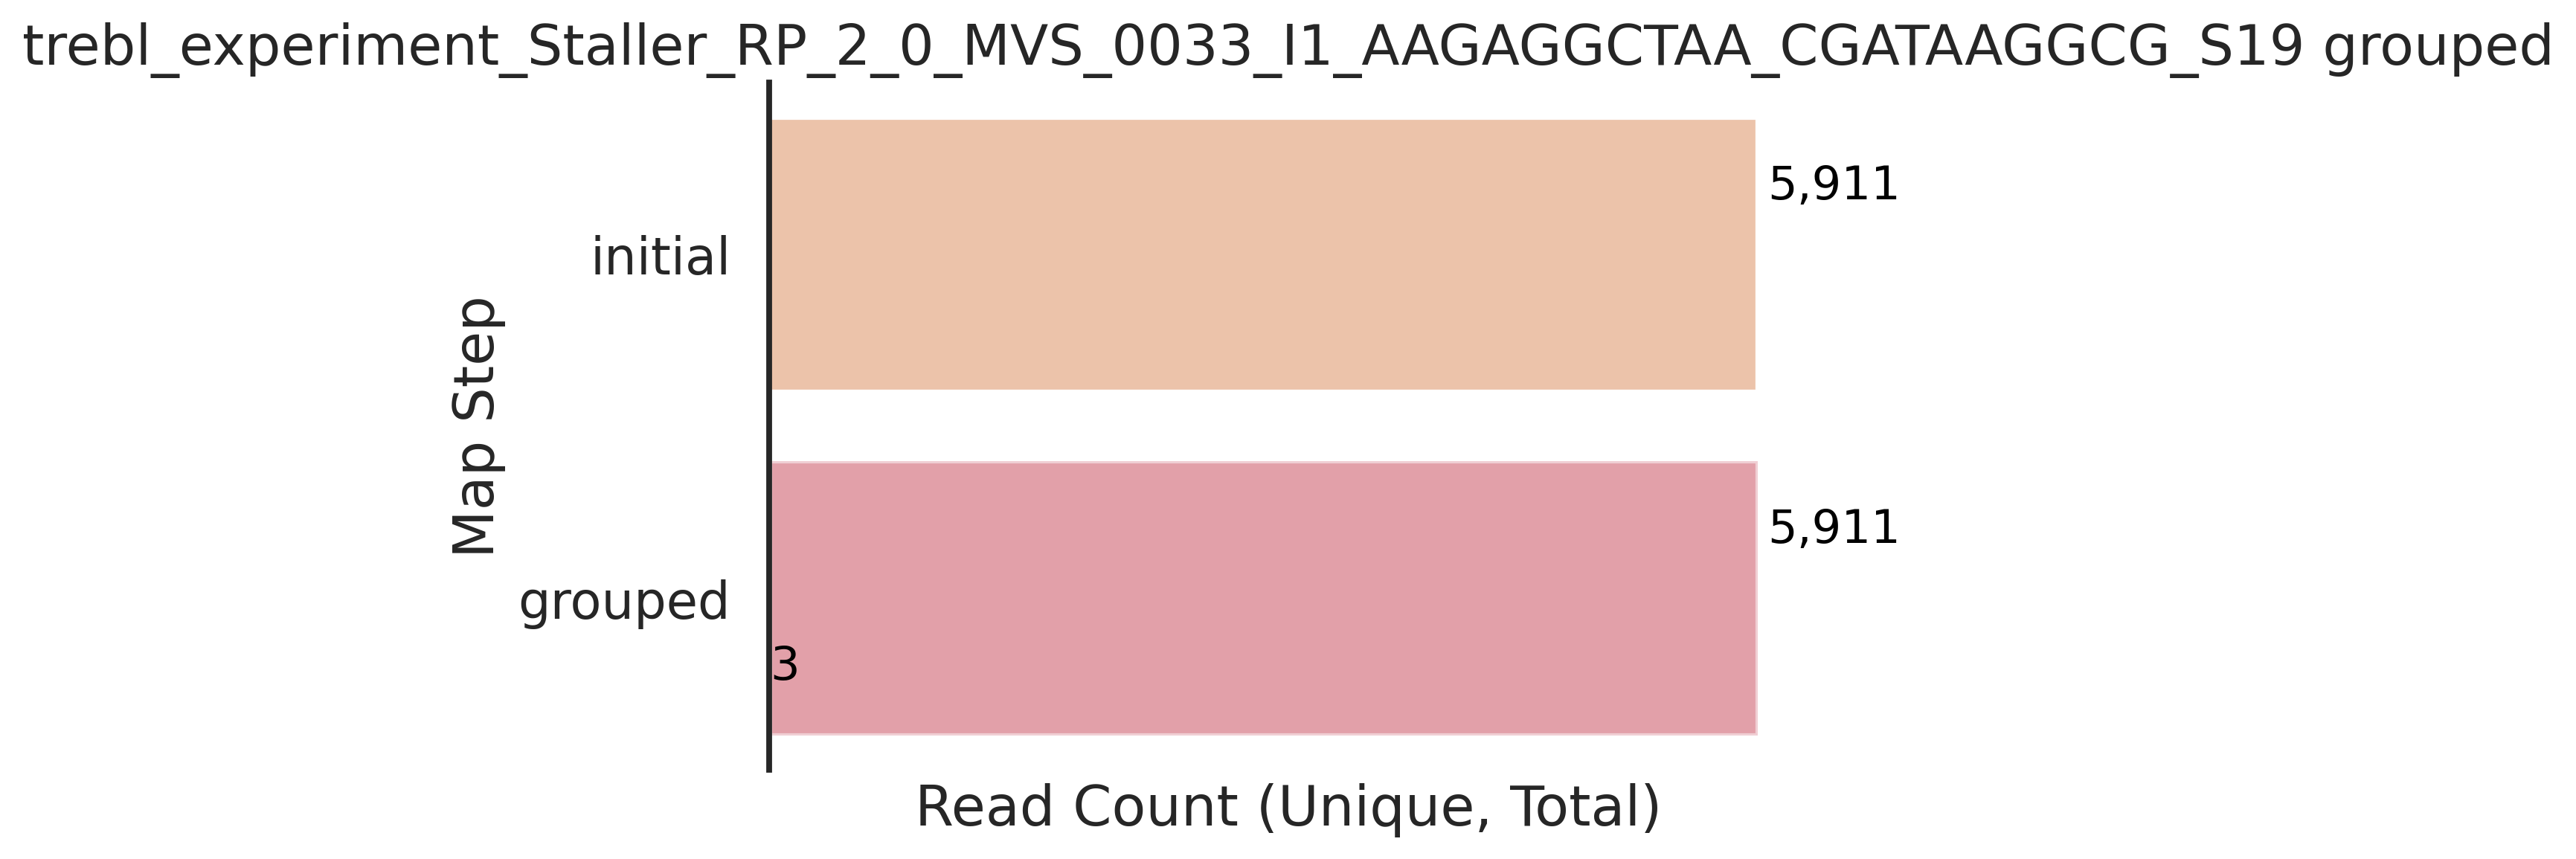

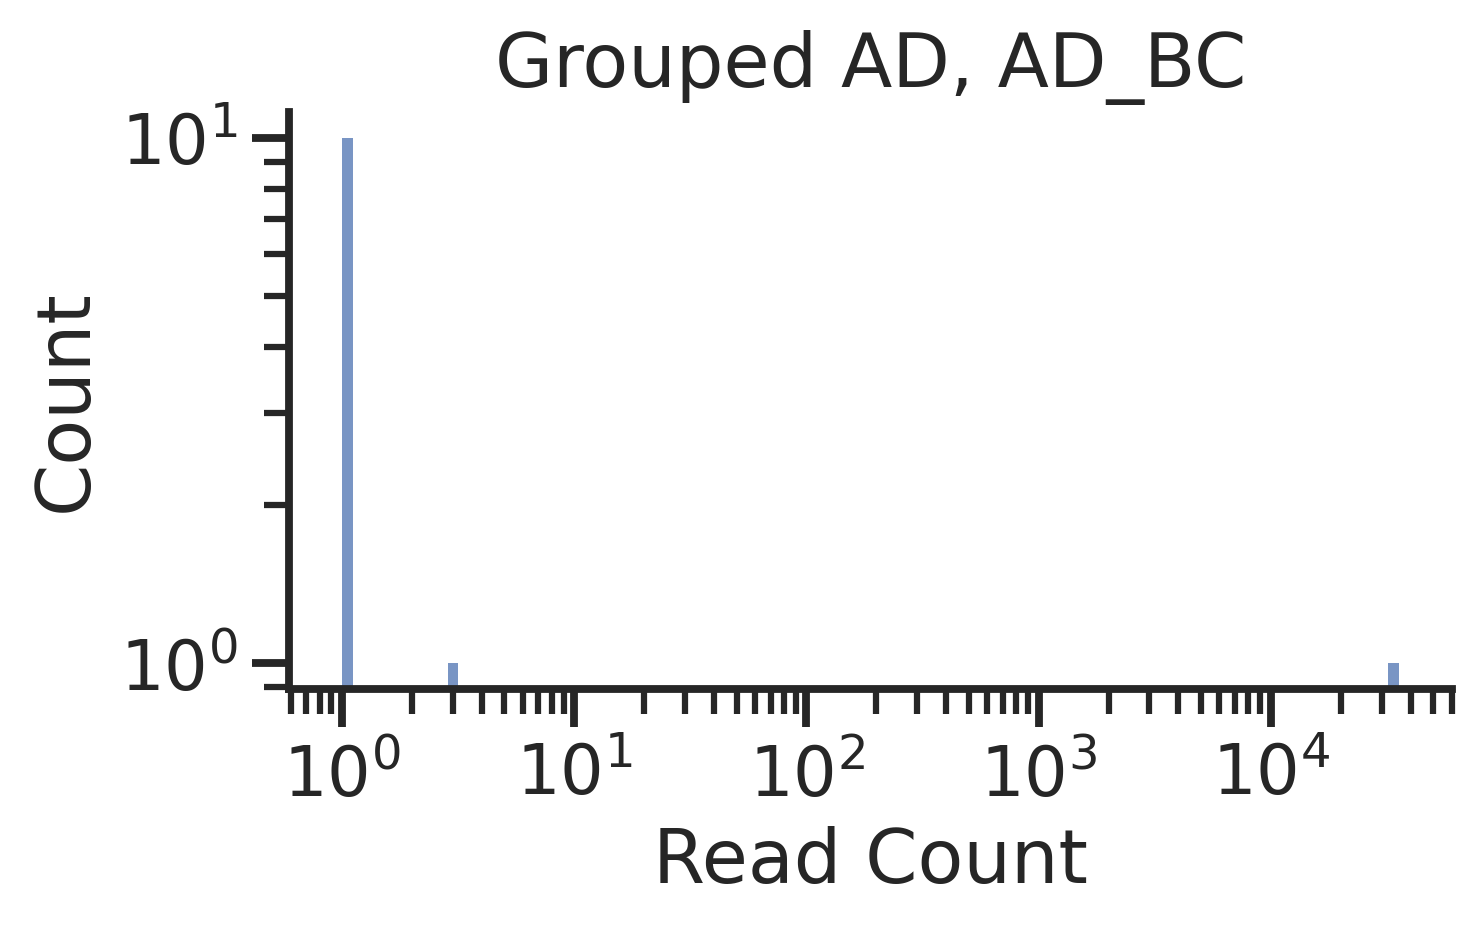

Done in 3.19 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_10_MVS_0036_I1_AGCTTACCTT_CACTTAGCAC_S22_AD_AD_BC_loss_summary'
Done in 0.04 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.69 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.91 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.45 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.33 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGAGTA_S27_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGAGTA_S27_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGAGTA_S27_AD_AD_BC_initial...


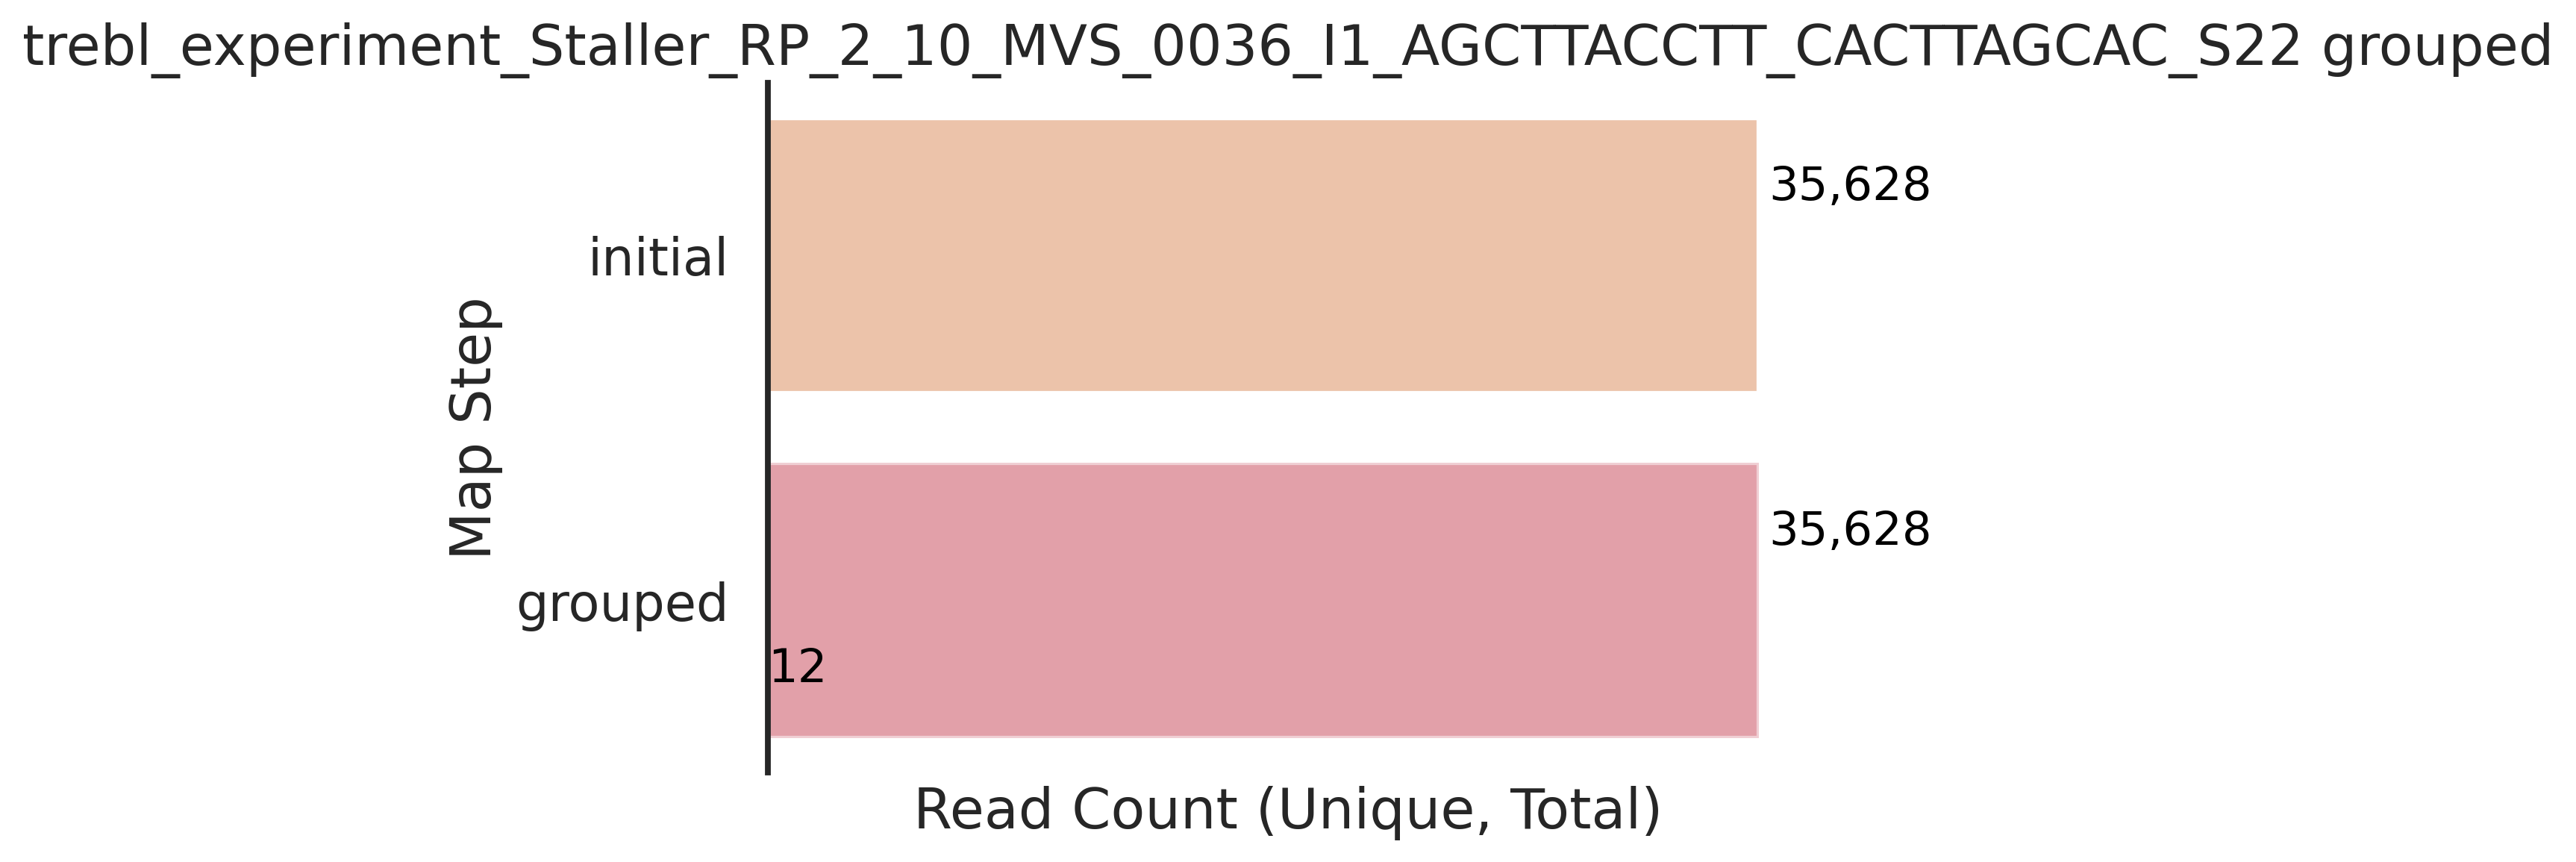

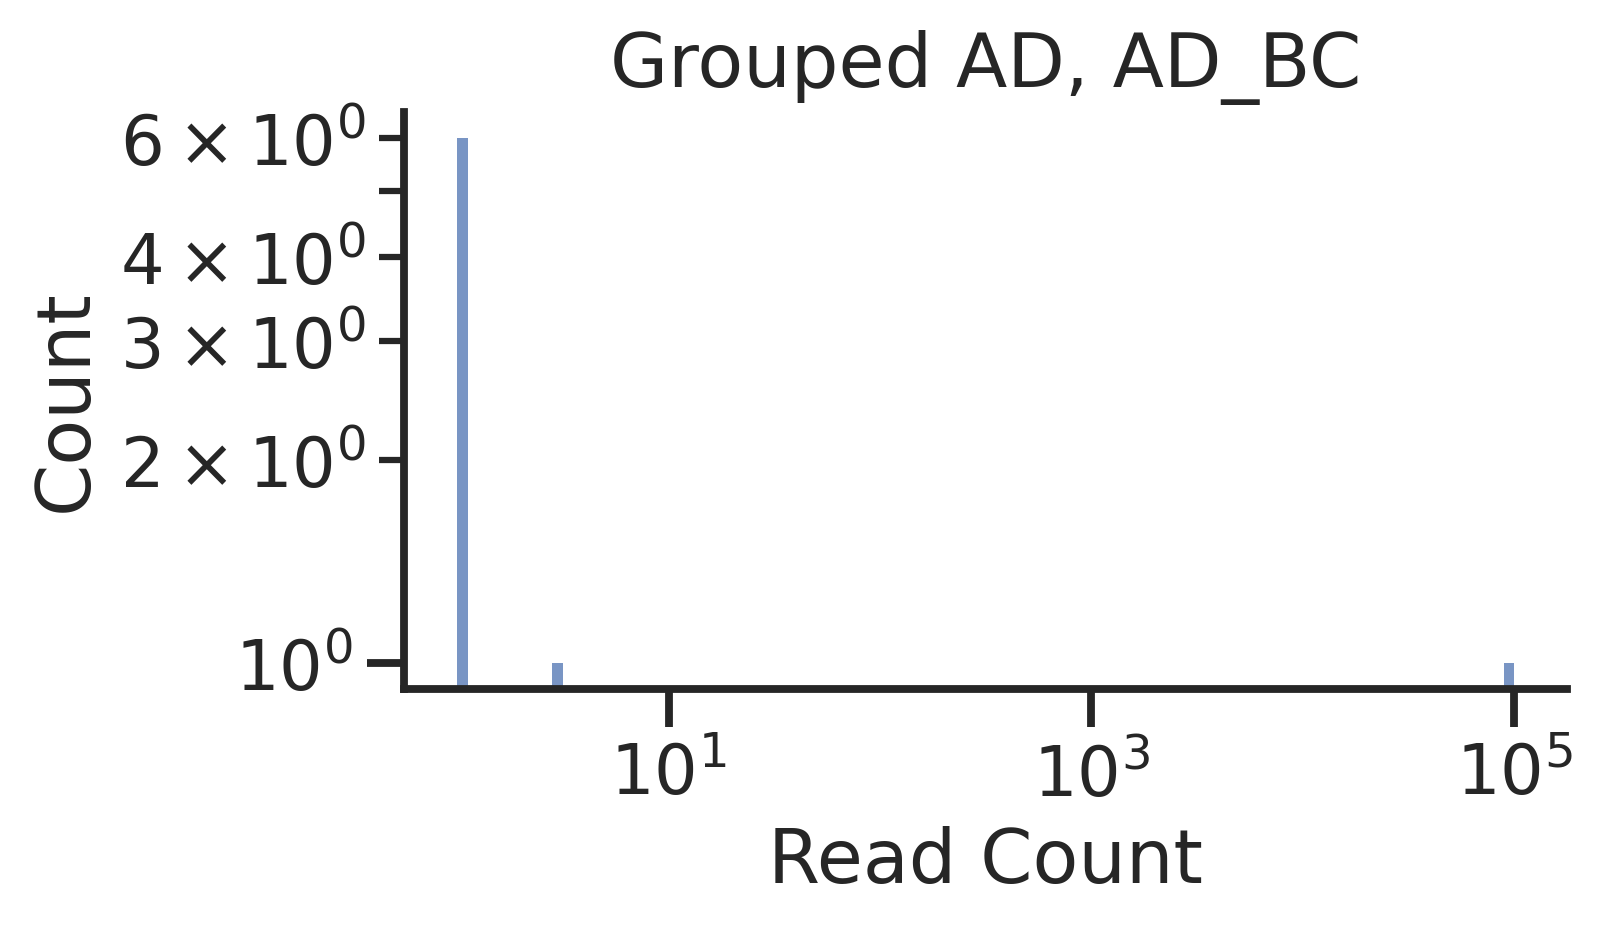

Done in 2.74 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_50_MVS_0057_I1_GATTGGCCAG_CTCATGAGTA_S27_AD_AD_BC_loss_summary'
Done in 0.04 seconds.

Reading 1 FASTQ/TXT file(s)...
Done in 0.23 seconds.

Reverse complement of sequences...
Done in 0.57 seconds.

Extracting 2 barcodes...
Regex for AD: GGCTAGC(.*)TGACTAG
Regex for AD_BC: CGCGCC(.*)GGGCCC
Done in 0.11 seconds.

Done in 0.00 seconds.

Merging with design file...
Done in 0.15 seconds.

Mapping complete.
Base prefix (stable across descriptors): trebl_experiment_Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAACA_S21_AD_AD_BC_
Full prefix for this instance: trebl_experiment_Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAACA_S21_AD_AD_BC_

Using the following step order:
1. initial
2. grouped

Grouping trebl_experiment_Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAACA_S21_AD_AD_BC_initial...


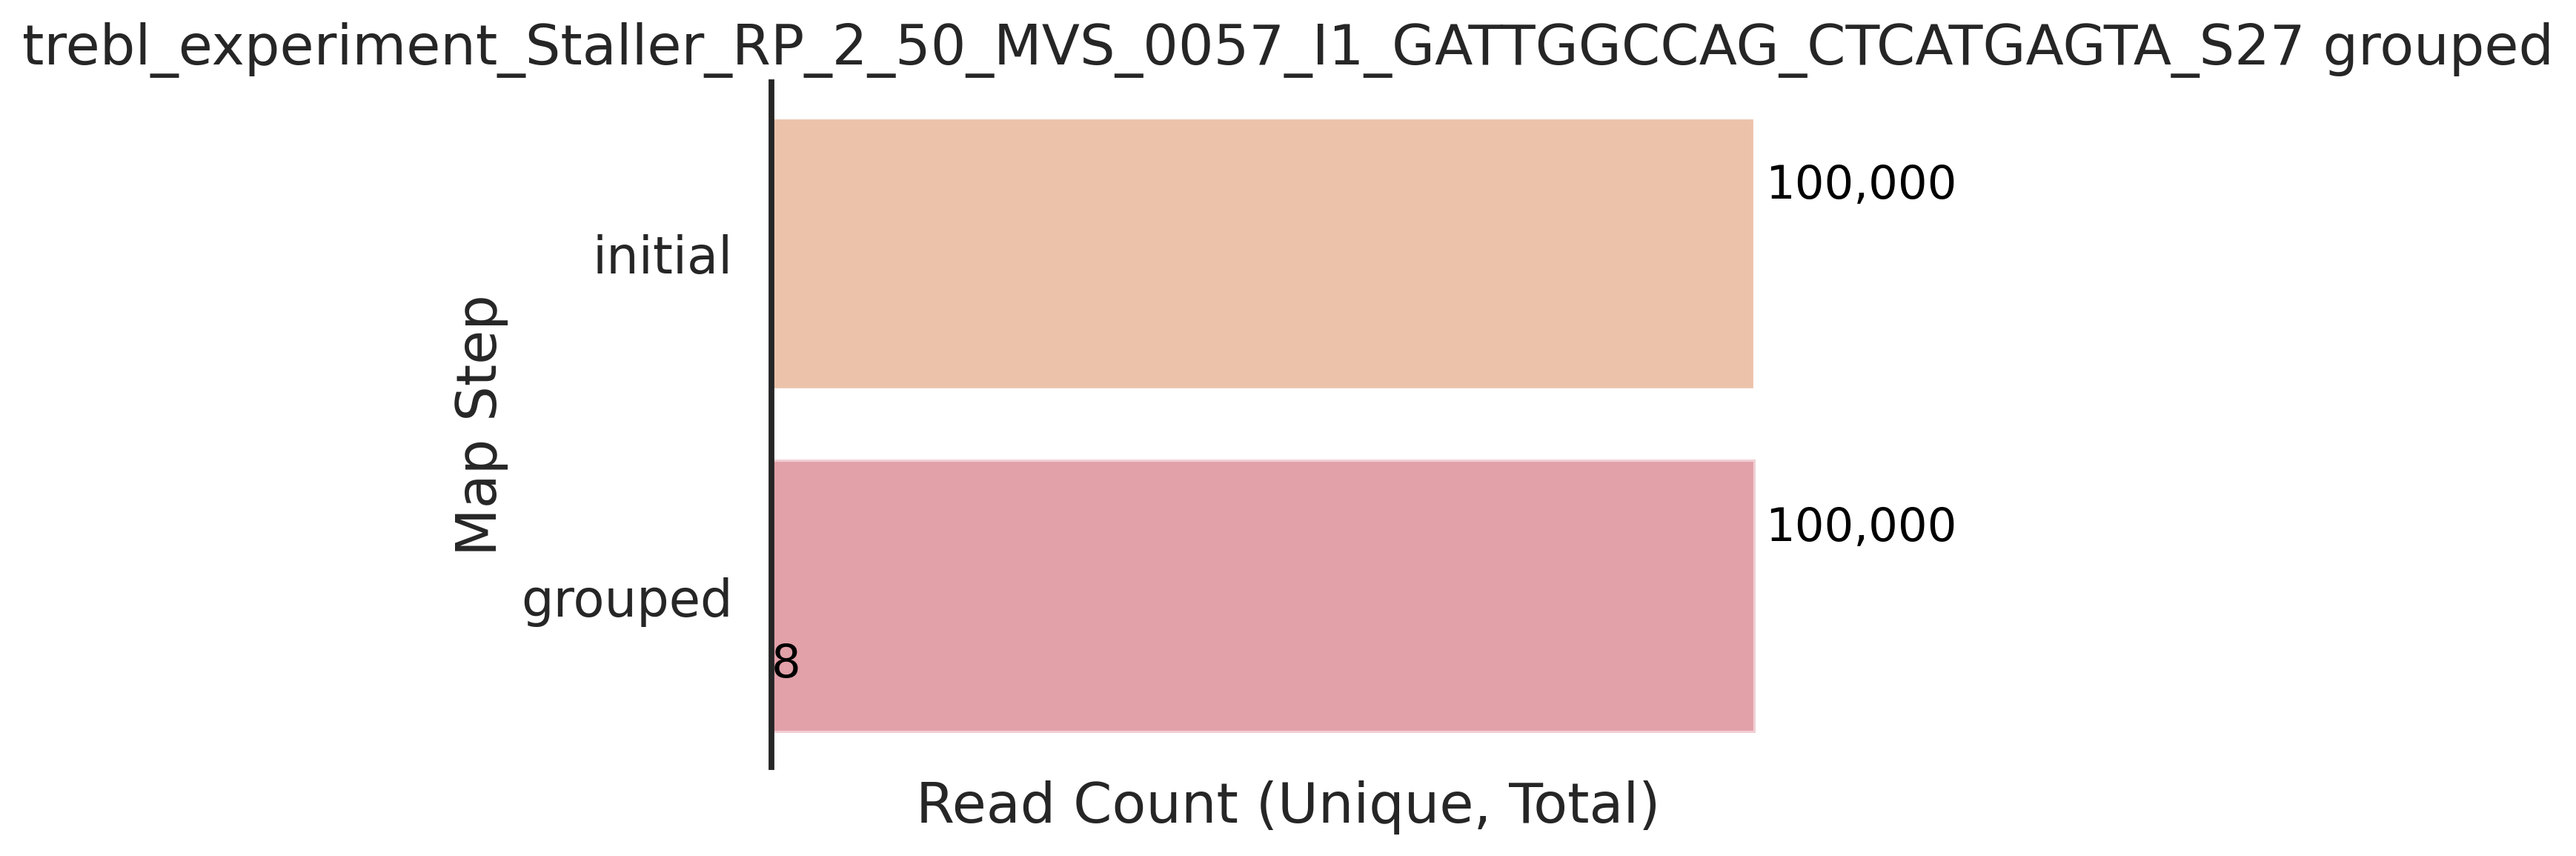

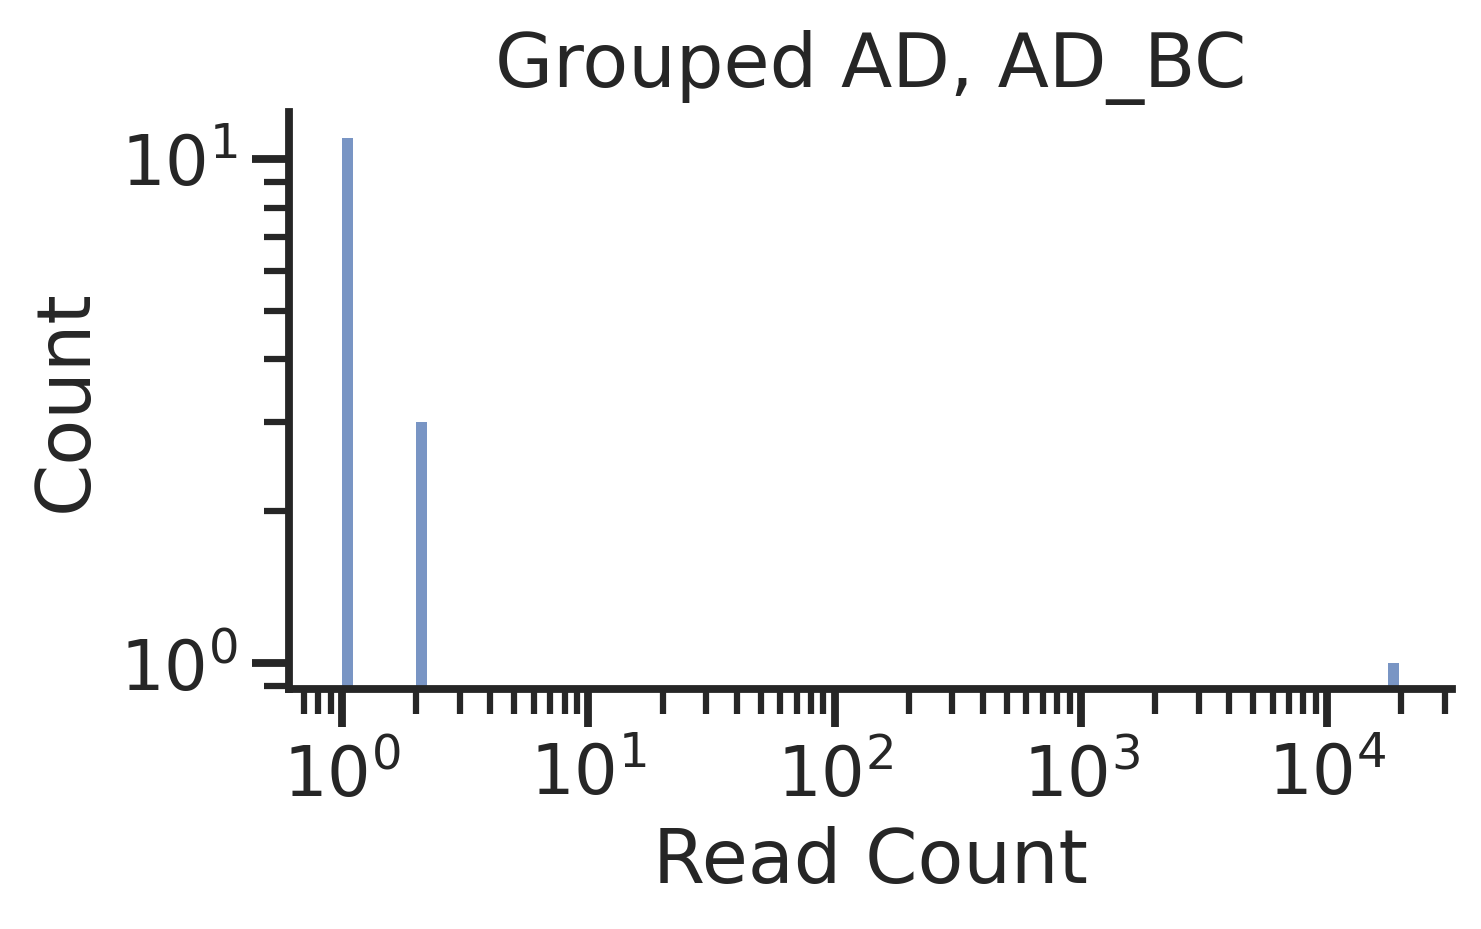

Done in 3.14 seconds.

Done.
Saved loss summary table as 'trebl_experiment_Staller_RP_2_5_MVS_0035_I1_TTGTCACCAA_CGCACGAACA_S21_AD_AD_BC_loss_summary'
Done in 0.03 seconds.



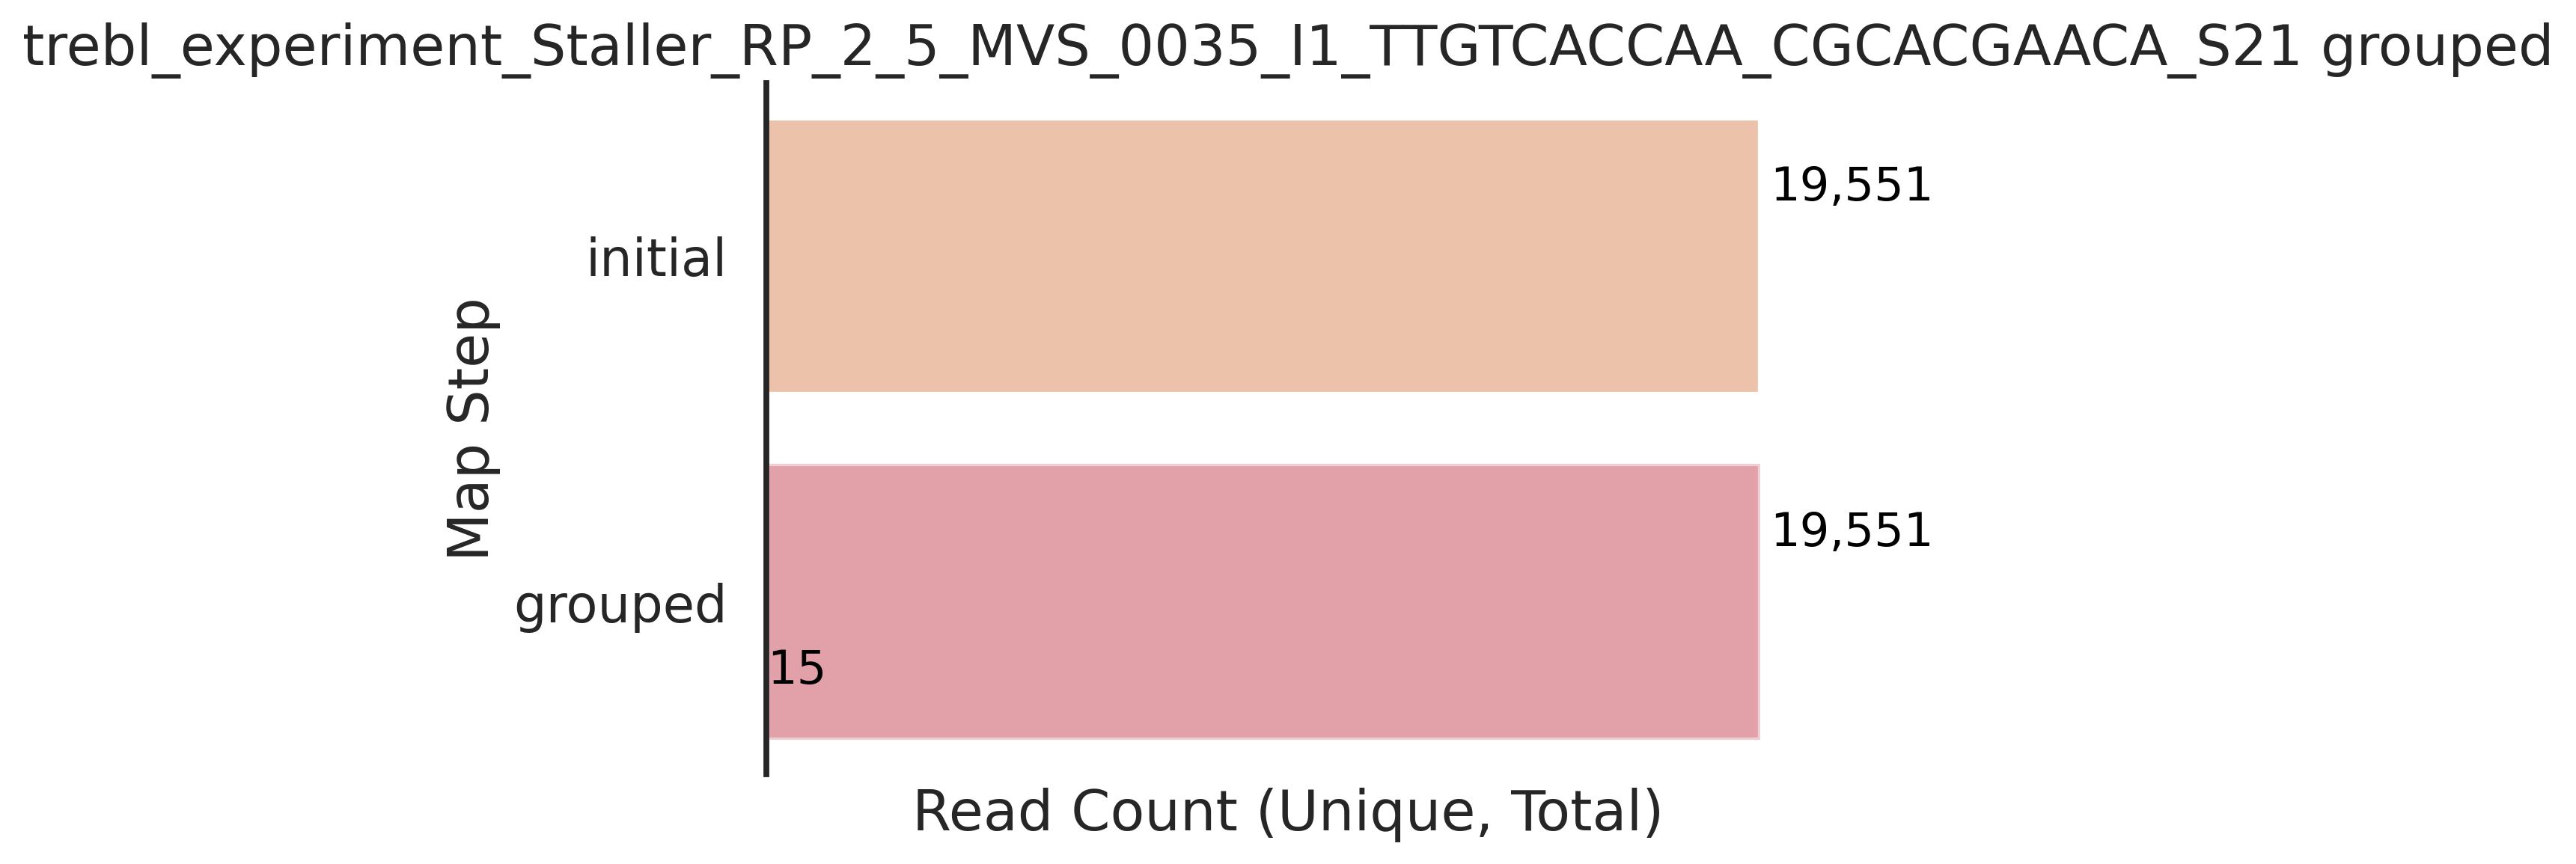

In [24]:
pipeline.trebl_experiment_reads_distribution(
        trebl_AD_seq_files,
        [AD, AD_BC],
        trebl_RT_seq_files,
        [RPTR_BC],
        reverse_complement = True
    )

In [ ]:
pipeline.trebl_experiment_analysis(
        trebl_AD_seq_files,
        [AD, AD_BC],
        trebl_RT_seq_files,
        [RPTR_BC],
        reverse_complement = True,
        step1_map_name = "step1_AD_AD_BC_RPTR_BC_designed",
        AD_umi_object=None,
        RT_umi_object=None,
        reads_threshold_AD=1,
        reads_threshold_RT=1,
        step_name_prefix="trebl_experiment_",
    )